# e.g. 12: Compare monthly nino34 time-series from daily/monthly inputs from 1 forecast run & assim & ETKF & control & 2 observations

# last edited 8 November 2018

# to be run on vm32 (or potentially any machine including raijin)

# 1.  first major JN cell does computations 2. second major JN cell pickles data objects, optionally writes them out, and reads them back in, and plots them.

# this notebook generates figure that Terry used in Jclim paper.

# Added v3 forecast no other major changes in upper part.

# In lower part copied plotting stuff to new cell and changed v0 to v3, then modified plot as required for paper. Perhaps keep them both for now.

In [39]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [40]:
print('BEGIN')

import socket
import re
import os
import sys
import inspect
import pickle
import glob
import bz2

print('sys.version=',sys.version)

hostname=socket.gethostname()

print('hostname=',hostname)

__file__='jupyter_notebook' #this can be deleted when written to a python script and loaded as module.

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import numpy as np
import numpy.ma as ma
from matplotlib.mlab import griddata

from decadal_diag import \
  fractional_year_from_num2date, \
  generate_daily_month_indices, \
  shade_2d_latlon, \
  get_timestamp_number, \
  shade_2d_curvilinear, \
  shade_2d_simple, \
  nino_indices, \
  plot_xy, \
  file_sort_ripf

###

from n_data_funcs import n_data_funcs

cafe_experiment_titles = {4:'v0_forecast', 1:'v1_forecast', 3:'v2_forecast', 9:'v1', \
  5:'v2', 6:'v3', 7:'aug17p', 2:'v1_assim', 10:'etkf', 11:'nov17n', 12:'jul18b', 13:'v0', 16:'v3_forecast'}

nino_index_k=0
# nino_index_k=1
# nino_index_k=2
# nino_index_k=3

#note: now I am reading in control (r1), so these are available but need to be ignored for ensemble statistics.
#max_ensemble=3 #this will utilise first two ensembles.
#max_ensemble=2 #this will utilise first ensemble (could be issues as array's might collapse...)
max_ensemble=11 #this will utilise all ensembles.

%matplotlib inline

CRED = '\033[91m'
CEND = '\033[0m'

ALL_ON=False #will depend upon each SWITCH_OFF setting.
ALL_ON=True #this will override any SWITCH_OFF=True setting

print('END')

BEGIN
sys.version= 3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 17:14:51) 
[GCC 7.2.0]
hostname= oa-35-cdc
END


In [19]:
# import netCDF4
# import shutil
# from nco import Nco
# from cdo import *

# # on raijin:
# # ncks -A -v time_bnds /short/v14/mac599/ncep2/prate.sfc.gauss.1982.nc /short/v14/mac599/ncep2/skt.sfc.gauss.1982.nc


# #https://code.mpimet.mpg.de/projects/cdo/wiki/Cdo%7Brbpy%7D
  
# print('Current Working Directory=',os.getcwd())

# #os.environ['APP_OUTPATH'] = '.'
# print(os.getenv('LD_LIBRARY_PATH'))

# #ncks -A -v time_bnds prate.sfc.gauss.1982.nc test.nc

# shutil.copy('/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1982.nc','test.nc')

# cdo = Cdo()

# #help(cdo.sinfov)


# # nco = Nco()
# # nco.ncks(input='/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/prate.sfc.gauss.1982.nc', output='test.nc', variable='time_bnds', options=('-A'))

# #https://groups.google.com/a/continuum.io/forum/#!topic/conda/-5Sn2z5snPs
# #/OSM/CBR/OA_DCFP/work/col414$ ls /OSM/CBR/OA_DCFP/apps/col414/anaconda3/envs/cafepp_27_scipy/lib/

# # ifils=[['/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1980.nc', \
# #  '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1981.nc']]
# # ifils=[['/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1980.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1981.nc','/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1982.nc','/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1983.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1984.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1985.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1986.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1987.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1988.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1989.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1990.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1991.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1992.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1993.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1994.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1995.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1996.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1997.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1998.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1999.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2000.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2001.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2002.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2003.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2004.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2005.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2006.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2007.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2008.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2009.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2010.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2011.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2012.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2013.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2014.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2015.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2016.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2017.nc']]
# #         #, '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1982.nc']]
# # ifhN=netCDF4.MFDataset(ifils[0][:])

# print('END')

BEGIN
sys.version= 3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 17:14:51) 
[GCC 7.2.0]
hostname= oa-35-cdc
this is vm32
Current Working Directory= /OSM/CBR/OA_DCFP/work/col414/cafepp
ncepr2_monthly_files= [['/OSM/CBR/OA_DCFP/work/col414/CAFEPP/short/r67/mac599/data/NCEP_R1/skt.mon.mean.nc']]
ncepr2_daily_files= [['/OSM/CBR/OA_DCFP/work/col414/CAFEPP/short/v14/mac599/ncep2/daily_averages/skt.sfc.gauss.1979.nc', '/OSM/CBR/OA_DCFP/work/col414/CAFEPP/short/v14/mac599/ncep2/daily_averages/skt.sfc.gauss.1980.nc', '/OSM/CBR/OA_DCFP/work/col414/CAFEPP/short/v14/mac599/ncep2/daily_averages/skt.sfc.gauss.1981.nc', '/OSM/CBR/OA_DCFP/work/col414/CAFEPP/short/v14/mac599/ncep2/daily_averages/skt.sfc.gauss.1982.nc', '/OSM/CBR/OA_DCFP/work/col414/CAFEPP/short/v14/mac599/ncep2/daily_averages/skt.sfc.gauss.1983.nc', '/OSM/CBR/OA_DCFP/work/col414/CAFEPP/short/v14/mac599/ncep2/daily_averages/skt.sfc.gauss.1984.nc', '/OSM/CBR/OA_DCFP/work/col414/CAFEPP/short/v14/mac599/ncep2/daily_averages/skt.sfc.gauss.1

cafe_daily_files_etkf= [['/OSM/CBR/OA_DCFP/work/col414/CAFEPP/CMIP6/CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p10f1/Oday/tos/gn/v20171025/tos_Oday_historical_CAFE-1-0_r1i1p10f1_gn_20030101-20091231.nc'], ['/OSM/CBR/OA_DCFP/work/col414/CAFEPP/CMIP6/CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r2i1p10f1/Oday/tos/gn/v20171025/tos_Oday_historical_CAFE-1-0_r2i1p10f1_gn_20030101-20091231.nc'], ['/OSM/CBR/OA_DCFP/work/col414/CAFEPP/CMIP6/CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r3i1p10f1/Oday/tos/gn/v20171025/tos_Oday_historical_CAFE-1-0_r3i1p10f1_gn_20030101-20091231.nc'], ['/OSM/CBR/OA_DCFP/work/col414/CAFEPP/CMIP6/CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r4i1p10f1/Oday/tos/gn/v20171025/tos_Oday_historical_CAFE-1-0_r4i1p10f1_gn_20030101-20091231.nc'], ['/OSM/CBR/OA_DCFP/work/col414/CAFEPP/CMIP6/CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r5i1p10f1/Oday/tos/gn/v20171025/tos_Oday_historical_CAFE-1-0_r5i1p10f1_gn_20030101-20091231.nc'], ['/OSM/CBR/OA_DCFP/work/col414/CAFEPP/CMIP6/CMIP6/CMIP/CSIRO/CAFE-1-0/historical/

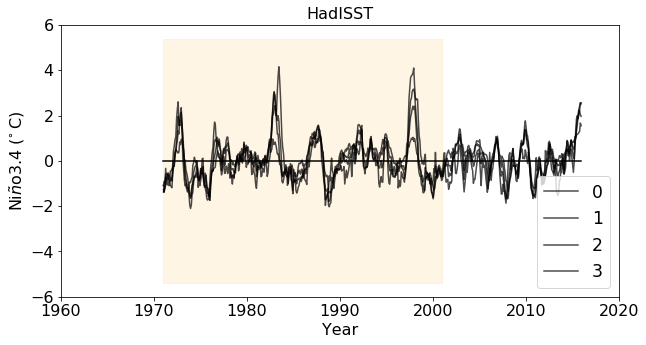

Processing monthly NCEP...
class nino_indices: Number of nino indices defined= 4
n_data_funcs.init: no ensembles in this example.
calculate_filedatetime_info: case 1: no ensembles, one input file.
class nino_indices.auto_lat_lon: overwriting pre-defined nino lat/lon indices.
calculate_quantity: Turning on diagnostics.
calculate_quantity: Diag= True
calculate_quantity: key,value= quantity nino
calculate_quantity: calculating a quantity...
calculate_quantity: value_split= ['nino']
calculate_quantity: nino chosen.
Diag= False
monthly_clim_anom: There are missing months in the set. 0 at beginning and 6 at end.
monthly_clim_anom: Currently years with missing months are not used in generating long term monthly climatology.
monthly_clim_anom: And missing months will be set to missing in the final time-series.
monthly_clim_anom: ydiff_monthly,missing_months_beg,last_month_index= 71 0 846
Diag= False
monthly_clim_anom: There are missing months in the set. 0 at beginning and 6 at end.
monthly_cl

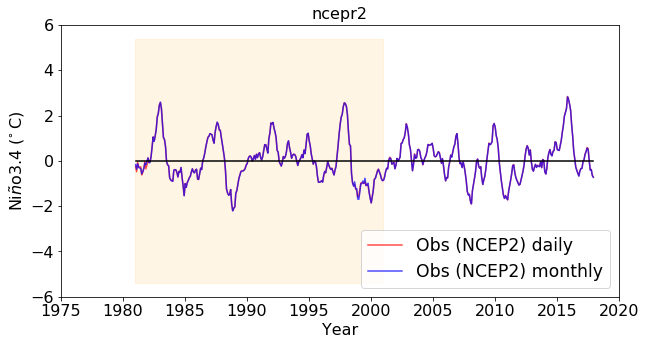

Processing daily assim...
class nino_indices: Number of nino indices defined= 4
n_data_funcs.init: no ensembles in this example.
calculate_filedatetime_info: case 1: no ensembles, one input file.
class nino_indices.auto_lat_lon: overwriting pre-defined nino lat/lon indices.
calculate_quantity: value_split= ['nino']
daily_to_monthly: Discarding beg&/end month if they exist.
daily_to_monthly: type#4
Diag= False
monthly_clim_anom: All years have 12 months.
Diag= False
monthly_clim_anom: All years have 12 months.
Processing monthly assim...
n_data_funcs.init: no ensembles in this example.
calculate_filedatetime_info: case 1: no ensembles, one input file.
class nino_indices.auto_lat_lon: overwriting pre-defined nino lat/lon indices.
calculate_quantity: value_split= ['nino']
Diag= False
monthly_clim_anom: All years have 12 months.
Diag= False
monthly_clim_anom: All years have 12 months.
plot_xy: Diagnostics turned on.
Inputing input_datas.
Inputing input_xvals.
Inputing title.
Inputing units

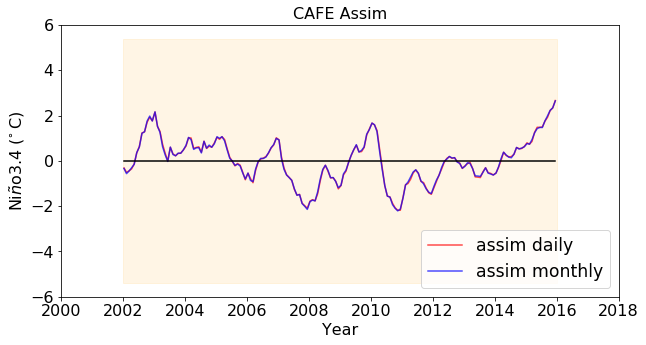

Processing daily v0...
class nino_indices: Number of nino indices defined= 4
n_data_funcs.init: ensembles in this example.
calculate_filedatetime_info: case 3: ensembles but only one file for each ensemble.
class nino_indices.auto_lat_lon: overwriting pre-defined nino lat/lon indices.
calculate_quantity: value_split= ['nino']


/OSM/CBR/OA_DCFP/apps/col414/anaconda3/envs/cafepp_36_new/lib/python3.6/site-packages/numpy/lib/function_base.py:1128: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/OSM/CBR/OA_DCFP/apps/col414/anaconda3/envs/cafepp_36_new/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


daily_to_monthly: Discarding beg&/end month if they exist.
daily_to_monthly: type#4
Diag= True
monthly_clim_anom: Diagnostics turned on.
monthly_clim_anom: Zeroing climatlogy in anomaly calculation.
monthly_clim_anom: self.daily_to_monthly_test= True
monthly_clim_anom: bbb
monthly_clim_anom: ybeg,yend= 2007 2012
monthly_clim_anom: first,last_month= 1 12
monthly_clim_anom: All years have 12 months.
monthly_clim_anom: input.shape= (72, 11, 4)
monthly_clim_anom: cbeg,cend= 2007 2012
monthly_clim_anom: ybeg,yend= 2007 2012
monthly_clim_anom: Input data over years 2007-2012
monthly_clim_anom: Climatology years 2007-2012
monthly_clim_anom: Anomaly years 2007-2012
monthly_clim_anom: icbeg,icend= 0 71
monthly_clim_anom: iabeg,iaend= 0 71
monthly_clim_anom: output_shape_climatology= [12, 11, 4]
monthly_clim_anom: output_shape_anomaly= [72, 11, 4]
monthly_clim_anom: input_full.shape= (72, 11, 4)
monthly_clim_anom: to_shape_monthly= [6, 12, 11, 4]
monthly_clim_anom: self.monthly_climatology.shape

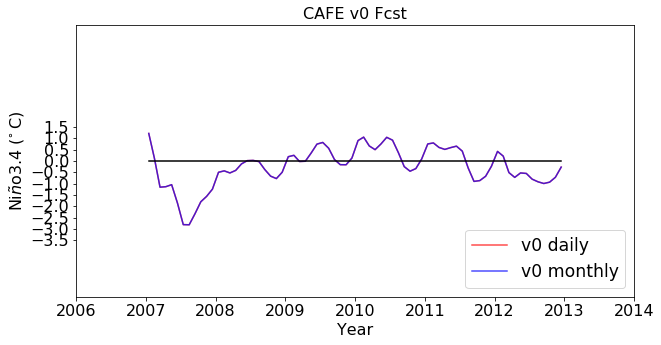

Processing daily v1...
class nino_indices: Number of nino indices defined= 4
n_data_funcs.init: ensembles in this example.
calculate_filedatetime_info: case 3: ensembles but only one file for each ensemble.
class nino_indices.auto_lat_lon: overwriting pre-defined nino lat/lon indices.
calculate_quantity: value_split= ['nino']
daily_to_monthly: Discarding beg&/end month if they exist.
daily_to_monthly: type#4
Diag= False
monthly_clim_anom: All years have 12 months.
Diag= False
monthly_clim_anom: Reading in climatology rather than calculating it.
monthly_clim_anom: All years have 12 months.
Processing monthly v1...
n_data_funcs.init: ensembles in this example.
calculate_filedatetime_info: case 3: ensembles but only one file for each ensemble.
calculate_quantity: value_split= ['nino']
Diag= False
monthly_clim_anom: All years have 12 months.
Diag= False
monthly_clim_anom: Reading in climatology rather than calculating it.
monthly_clim_anom: All years have 12 months.


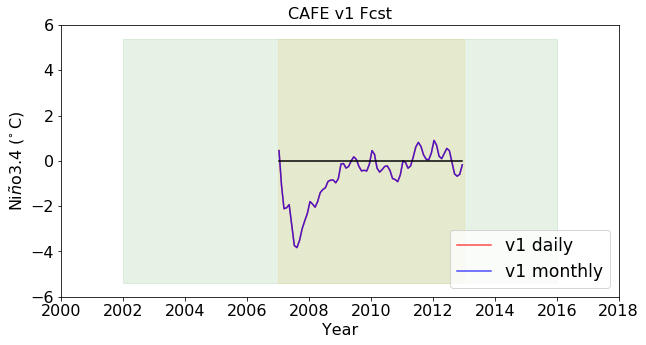

Processing daily v3...
class nino_indices: Number of nino indices defined= 4
n_data_funcs.init: ensembles in this example.
calculate_filedatetime_info: case 3: ensembles but only one file for each ensemble.
class nino_indices.auto_lat_lon: overwriting pre-defined nino lat/lon indices.
calculate_quantity: value_split= ['nino']
daily_to_monthly: Discarding beg&/end month if they exist.
daily_to_monthly: type#4
Diag= True
monthly_clim_anom: Diagnostics turned on.
monthly_clim_anom: Zeroing climatlogy in anomaly calculation.
monthly_clim_anom: self.daily_to_monthly_test= True
monthly_clim_anom: bbb
monthly_clim_anom: ybeg,yend= 2007 2008
monthly_clim_anom: first,last_month= 1 12
monthly_clim_anom: All years have 12 months.
monthly_clim_anom: input.shape= (24, 11, 4)
monthly_clim_anom: cbeg,cend= 2007 2008
monthly_clim_anom: ybeg,yend= 2007 2008
monthly_clim_anom: Input data over years 2007-2008
monthly_clim_anom: Climatology years 2007-2008
monthly_clim_anom: Anomaly years 2007-2008
monthl

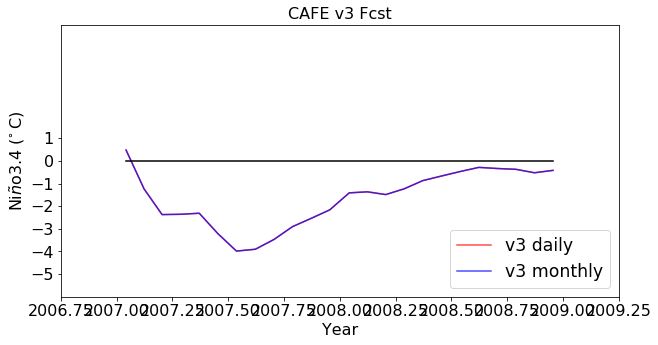

Processing daily etkf...
class nino_indices: Number of nino indices defined= 4
n_data_funcs.init: ensembles in this example.
calculate_filedatetime_info: case 3: ensembles but only one file for each ensemble.
class nino_indices.auto_lat_lon: overwriting pre-defined nino lat/lon indices.
calculate_quantity: value_split= ['nino']
daily_to_monthly: Discarding beg&/end month if they exist.
daily_to_monthly: type#4
Diag= False
monthly_clim_anom: All years have 12 months.
Diag= False
monthly_clim_anom: Reading in climatology rather than calculating it.
monthly_clim_anom: All years have 12 months.


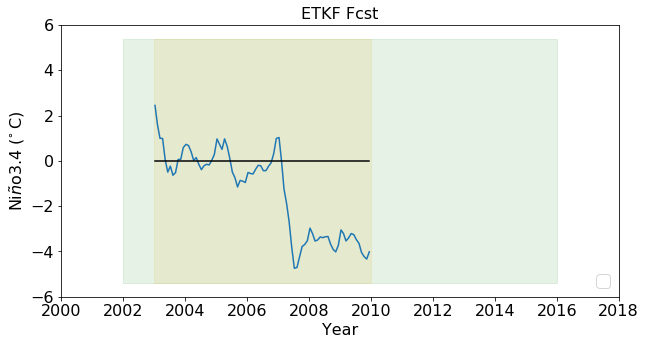

Doing some integrity checks...
ok
END


In [41]:
print('BEGIN')

import socket
import re
import os
import sys

print('sys.version=',sys.version)

hostname=socket.gethostname()

print('hostname=',hostname)

if(re.match('raijin',hostname)):
  print('this is rajin')
  rundir='/short/v14/mac599/cafepp/rundir'
  topdir=''
elif(re.match('oa-3.-cdc',hostname)):
  print('this is vm32')
  rundir='/OSM/CBR/OA_DCFP/work/col414/cafepp'
  topdir='/OSM/CBR/OA_DCFP/data/CAFEPP/CMIP6'
  topdir='/OSM/CBR/OA_DCFP/work/col414/CAFEPP/CMIP6'
  topdir_ncep='/OSM/CBR/OA_DCFP/data/CAFEPP/'
  topdir_ncep='/OSM/CBR/OA_DCFP/work/col414/CAFEPP/'
else:
  raise SystemExit('host not known:'+__file__+' line number: '+str(inspect.stack()[0][2]))

os.chdir(rundir)

os.chdir('/OSM/CBR/OA_DCFP/work/col414/cafepp')

print('Current Working Directory=',os.getcwd())

SWITCH_OFF=True #temporary for easy skipping of this section.
SWITCH_OFF=False

if(not SWITCH_OFF):
  
#===============================================================================

  product='ncepr2'

  ivar_str_ncepr2='skt';ifil_prefix_ncepr2='skt';offset=0.0;scale=1.0;long_name='Surface Temperature';units='degC'

  grid_label='ncep_r1'
  ncepr2_calendar='proleptic_gregorian'

  #monthly inputs
  idir=topdir_ncep+'short/r67/mac599/data/NCEP_R1'
  ncepr2_monthly_files=[[idir+'/'+ifil_prefix_ncepr2+'.mon.mean.nc']]
    
  #daily inputs
  idir=topdir_ncep+'short/v14/mac599/ncep2/daily_averages'
  ncepr2_daily_files=[sorted( \
    glob.glob(idir+'/'+ifil_prefix_ncepr2+'.sfc.gauss.197?.nc')+ \
    glob.glob(idir+'/'+ifil_prefix_ncepr2+'.sfc.gauss.198?.nc')+ \
    glob.glob(idir+'/'+ifil_prefix_ncepr2+'.sfc.gauss.199?.nc')+ \
    glob.glob(idir+'/'+ifil_prefix_ncepr2+'.sfc.gauss.200?.nc')+ \
    glob.glob(idir+'/'+ifil_prefix_ncepr2+'.sfc.gauss.201?.nc') \
    )]
  
  #print(idir)
  print('ncepr2_monthly_files=',ncepr2_monthly_files)
  print('ncepr2_daily_files=',ncepr2_daily_files)
  
  #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))
  
#===============================================================================

  product='HadISST'

  ivar_str_hadisst='tos';ifil_prefix_hadisst='tos';offset=273.15;scale=1.0;long_name='Surface Temperature';units='degC'

  grid_label='hadisst'
  hadisst_calendar='proleptic_gregorian'

  hadisst_files=[]
  idir=topdir_ncep+'g/data/r67/CMIP5/common_restricted/CMIP5/output/Hadley/HadISST/1d/mon/ocean/Omon/r1i1p1/v20170110/tos'
  ifils=[ifil_prefix_hadisst+'_Omon_HadISST_1d_r1i1p1_187001-201512.nc']
  for file in ifils:
    if(not os.path.exists(idir+'/'+file)):
      raise SystemExit(idir+'/'+file+' doesnt exist:'+__file__+' line number: '+str(inspect.stack()[0][2]))
    else:
      hadisst_files.append(idir+'/'+file)  
  hadisst_files=[hadisst_files]

  print('hadisst_files=',hadisst_files)
  
  #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

#==============================================================================

  model='CAFE'
  nino_index_k=0
  
  grid_label='gn'
  cafe_calendar='julian'
    
  ivar_str_cafe='tos';offset=0.0;scale=1.0;long_name='Sea Surface Temperature';short_name='SST';units='degC';table='Oday'

  ensemble=1
  pval=2 #v1_assim
  cafe_daily_files_assim=[]
  idir=topdir+'/'+'CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r'+str(ensemble)+'i1p'+str(pval)+'f1/'+table+ \
    '/'+ivar_str_cafe+'/'+grid_label+'/v20171025'
  daily_ifils_assim=[ivar_str_cafe+'_'+table+'_historical_CAFE-1-0_r'+str(ensemble)+'i1p'+str(pval)+'f1_'+ \
    grid_label+'_20020101-20151231.nc']
  for file in daily_ifils_assim:
    if(not os.path.exists(idir+'/'+file)):
      raise SystemExit(idir+'/'+file+' doesnt exist:'+__file__+' line number: '+str(inspect.stack()[0][2]))
    else:
      cafe_daily_files_assim.append(idir+'/'+file)
  cafe_daily_files_assim=[cafe_daily_files_assim]

  ivar_str_cafe='tos';offset=0.0;scale=1.0;long_name='Sea Surface Temperature';short_name='SST';units='degC';table='Omon'

  ensemble=1
  pval=2 #v1_assim
  cafe_monthly_files_assim=[]
  idir=topdir+'/'+'CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r'+str(ensemble)+'i1p'+str(pval)+'f1/'+table+ \
    '/'+ivar_str_cafe+'/'+grid_label+'/v20171025'
  monthly_ifils_assim=[ivar_str_cafe+'_'+table+'_historical_CAFE-1-0_r'+str(ensemble)+'i1p'+str(pval)+'f1_'+ \
    grid_label+'_200201-201512.nc']
  for file in monthly_ifils_assim:
    if(not os.path.exists(idir+'/'+file)):
      raise SystemExit(idir+'/'+file+' doesnt exist:'+__file__+' line number: '+str(inspect.stack()[0][2]))
    else:
      cafe_monthly_files_assim.append(idir+'/'+file)
  cafe_monthly_files_assim=[cafe_monthly_files_assim]
  
  
  print('cafe_daily_files_assim=',cafe_daily_files_assim)
  print('cafe_monthly_files_assim=',cafe_monthly_files_assim)
  
  #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

#===============================================================================

  model='CAFE'
  nino_index_k=0
  
  grid_label='gn'
  cafe_calendar='julian'
      
  ivar_str_cafe='tos';offset=0.0;scale=1.0;long_name='Sea Surface Temperature';short_name='SST';units='degC';table='Oday'

  pval=4 #v0_forecast
  cafe_daily_files_v0forc=[]
  for ensemble in range(1,max_ensemble+1):
    cafe_inner_daily_files_v0forc=[]
    idir=topdir+'/'+'CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r'+str(ensemble)+'i1p'+str(pval)+'f1/'+table+ \
      '/'+ivar_str_cafe+'/'+grid_label+'/v20171025'
    daily_ifils_v0forc=[ivar_str_cafe+'_'+table+'_historical_CAFE-1-0_r'+str(ensemble)+'i1p'+str(pval)+'f1_'+ \
      grid_label+'_20070101-20121231.nc']
    for file in daily_ifils_v0forc:
      if(not os.path.exists(idir+'/'+file)):
        raise SystemExit(idir+'/'+file+' doesnt exist:'+__file__+' line number: '+str(inspect.stack()[0][2]))
      else:
        cafe_inner_daily_files_v0forc.append(idir+'/'+file)
    cafe_daily_files_v0forc.append(cafe_inner_daily_files_v0forc)

    #note monthly have 1 year less ATM.
    
  ivar_str_cafe='tos';offset=0.0;scale=1.0;long_name='Sea Surface Temperature';short_name='SST';units='degC';table='Omon'

  pval=4 #v0_forecast
  cafe_monthly_files_v0forc=[]
  for ensemble in range(1,max_ensemble+1):
    cafe_inner_monthly_files_v0forc=[]
    idir=topdir+'/'+'CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r'+str(ensemble)+'i1p'+str(pval)+'f1/'+table+ \
      '/'+ivar_str_cafe+'/'+grid_label+'/v20171025'
    monthly_ifils_v0forc=[ivar_str_cafe+'_'+table+'_historical_CAFE-1-0_r'+str(ensemble)+'i1p'+str(pval)+'f1_'+ \
      grid_label+'_200701-201212.nc']
    for file in monthly_ifils_v0forc:
      if(not os.path.exists(idir+'/'+file)):
        raise SystemExit(idir+'/'+file+' doesnt exist:'+__file__+' line number: '+str(inspect.stack()[0][2]))
      else:
        cafe_inner_monthly_files_v0forc.append(idir+'/'+file)
    cafe_monthly_files_v0forc.append(cafe_inner_monthly_files_v0forc)

  #sort by ripf, then overwrite var name
  cafe_daily_files_v0forc_tmp=file_sort_ripf([input_file[0] for input_file in cafe_daily_files_v0forc],False)
  cafe_daily_files_v0forc=[] #need to put into ensemble list form [[,,],[,,],[,,]]
  for input_file in cafe_daily_files_v0forc_tmp:
    cafe_daily_files_v0forc.append([input_file])
    
  cafe_monthly_files_v0forc_tmp=file_sort_ripf([input_file[0] for input_file in cafe_monthly_files_v0forc],False)
  cafe_monthly_files_v0forc=[] #need to put into ensemble list form [[,,],[,,],[,,]]
  for input_file in cafe_monthly_files_v0forc_tmp:
    cafe_monthly_files_v0forc.append([input_file])
        
  print('cafe_daily_files_v0forc=',cafe_daily_files_v0forc)
  print('cafe_monthly_files_v0forc=',cafe_monthly_files_v0forc)
  
  #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

#===============================================================================

  model='CAFE'
  nino_index_k=0
  
  grid_label='gn'
  cafe_calendar='julian'
      
  ivar_str_cafe='tos';offset=0.0;scale=1.0;long_name='Sea Surface Temperature';short_name='SST';units='degC';table='Oday'

  pval=1 #v1_forecast
  cafe_daily_files_v1forc=[]
  for ensemble in range(1,max_ensemble+1):
    cafe_inner_daily_files_v1forc=[]
    idir=topdir+'/'+'CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r'+str(ensemble)+'i1p'+str(pval)+'f1/'+table+ \
      '/'+ivar_str_cafe+'/'+grid_label+'/v20171025'
    daily_ifils_v1forc=[ivar_str_cafe+'_'+table+'_historical_CAFE-1-0_r'+str(ensemble)+'i1p'+str(pval)+'f1_'+ \
      grid_label+'_20070101-20121231.nc']
    for file in daily_ifils_v1forc:
      if(not os.path.exists(idir+'/'+file)):
        raise SystemExit(idir+'/'+file+' doesnt exist:'+__file__+' line number: '+str(inspect.stack()[0][2]))
      else:
        cafe_inner_daily_files_v1forc.append(idir+'/'+file)
    cafe_daily_files_v1forc.append(cafe_inner_daily_files_v1forc)

    #note monthly have 1 year less ATM.
    
  ivar_str_cafe='tos';offset=0.0;scale=1.0;long_name='Sea Surface Temperature';short_name='SST';units='degC';table='Omon'

  pval=1 #v1_forecast
  cafe_monthly_files_v1forc=[]
  for ensemble in range(1,max_ensemble+1):
    cafe_inner_monthly_files_v1forc=[]
    idir=topdir+'/'+'CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r'+str(ensemble)+'i1p'+str(pval)+'f1/'+table+ \
      '/'+ivar_str_cafe+'/'+grid_label+'/v20171025'
    monthly_ifils_v1forc=[ivar_str_cafe+'_'+table+'_historical_CAFE-1-0_r'+str(ensemble)+'i1p'+str(pval)+'f1_'+ \
      grid_label+'_200701-201212.nc']
    for file in monthly_ifils_v1forc:
      if(not os.path.exists(idir+'/'+file)):
        raise SystemExit(idir+'/'+file+' doesnt exist:'+__file__+' line number: '+str(inspect.stack()[0][2]))
      else:
        cafe_inner_monthly_files_v1forc.append(idir+'/'+file)
    cafe_monthly_files_v1forc.append(cafe_inner_monthly_files_v1forc)

  #sort by ripf, then overwrite var name
  cafe_daily_files_v1forc_tmp=file_sort_ripf([input_file[0] for input_file in cafe_daily_files_v1forc],False)
  cafe_daily_files_v1forc=[] #need to put into ensemble list form [[,,],[,,],[,,]]
  for input_file in cafe_daily_files_v1forc_tmp:
    cafe_daily_files_v1forc.append([input_file])
    
  cafe_monthly_files_v1forc_tmp=file_sort_ripf([input_file[0] for input_file in cafe_monthly_files_v1forc],False)
  cafe_monthly_files_v1forc=[] #need to put into ensemble list form [[,,],[,,],[,,]]
  for input_file in cafe_monthly_files_v1forc_tmp:
    cafe_monthly_files_v1forc.append([input_file])

  print('cafe_daily_files_v1forc=',cafe_daily_files_v1forc)
  print('cafe_monthly_files_v1forc=',cafe_monthly_files_v1forc)

  #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))
  
#===============================================================================

  model='CAFE'
  nino_index_k=0
  
  grid_label='gn'
  cafe_calendar='julian'
      
  ivar_str_cafe='tos';offset=0.0;scale=1.0;long_name='Sea Surface Temperature';short_name='SST';units='degC';table='Oday'

  pval=16 #v3_forecast
  cafe_daily_files_v3forc=[]
  for ensemble in range(1,max_ensemble+1):
    cafe_inner_daily_files_v3forc=[]
    idir=topdir+'/'+'CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r'+str(ensemble)+'i1p'+str(pval)+'f1/'+table+ \
      '/'+ivar_str_cafe+'/'+grid_label+'/v20171025'
    daily_ifils_v3forc=[ivar_str_cafe+'_'+table+'_historical_CAFE-1-0_r'+str(ensemble)+'i1p'+str(pval)+'f1_'+ \
      grid_label+'_20070101-20081231.nc']
    for file in daily_ifils_v3forc:
      if(not os.path.exists(idir+'/'+file)):
        raise SystemExit(idir+'/'+file+' doesnt exist:'+__file__+' line number: '+str(inspect.stack()[0][2]))
      else:
        cafe_inner_daily_files_v3forc.append(idir+'/'+file)
    cafe_daily_files_v3forc.append(cafe_inner_daily_files_v3forc)

    #note monthly have 1 year less ATM.
    
  ivar_str_cafe='tos';offset=0.0;scale=1.0;long_name='Sea Surface Temperature';short_name='SST';units='degC';table='Omon'

  pval=16 #v3_forecast
  cafe_monthly_files_v3forc=[]
  for ensemble in range(1,max_ensemble+1):
    cafe_inner_monthly_files_v3forc=[]
    idir=topdir+'/'+'CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r'+str(ensemble)+'i1p'+str(pval)+'f1/'+table+ \
      '/'+ivar_str_cafe+'/'+grid_label+'/v20171025'
    monthly_ifils_v3forc=[ivar_str_cafe+'_'+table+'_historical_CAFE-1-0_r'+str(ensemble)+'i1p'+str(pval)+'f1_'+ \
      grid_label+'_200701-200812.nc']
    for file in monthly_ifils_v3forc:
      if(not os.path.exists(idir+'/'+file)):
        raise SystemExit(idir+'/'+file+' doesnt exist:'+__file__+' line number: '+str(inspect.stack()[0][2]))
      else:
        cafe_inner_monthly_files_v3forc.append(idir+'/'+file)
    cafe_monthly_files_v3forc.append(cafe_inner_monthly_files_v3forc)

  #sort by ripf, then overwrite var name
  cafe_daily_files_v3forc_tmp=file_sort_ripf([input_file[0] for input_file in cafe_daily_files_v3forc],False)
  cafe_daily_files_v3forc=[] #need to put into ensemble list form [[,,],[,,],[,,]]
  for input_file in cafe_daily_files_v3forc_tmp:
    cafe_daily_files_v3forc.append([input_file])
    
  cafe_monthly_files_v3forc_tmp=file_sort_ripf([input_file[0] for input_file in cafe_monthly_files_v3forc],False)
  cafe_monthly_files_v3forc=[] #need to put into ensemble list form [[,,],[,,],[,,]]
  for input_file in cafe_monthly_files_v3forc_tmp:
    cafe_monthly_files_v3forc.append([input_file])
        
  print('cafe_daily_files_v3forc=',cafe_daily_files_v3forc)
  print('cafe_monthly_files_v3forc=',cafe_monthly_files_v3forc)
  
  #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

#===============================================================================

  model='CAFE'
  
  grid_label='gn'
  cafe_calendar='julian'
      
  ivar_str_cafe='tos';offset=0.0;scale=1.0;long_name='Sea Surface Temperature';short_name='SST';units='degC';table='Oday'

  pval=10 #etkf
  cafe_daily_files_etkf=[]
  for ensemble in range(1,max_ensemble+1):
    cafe_inner_daily_files_etkf=[]
    idir=topdir+'/'+'CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r'+str(ensemble)+'i1p'+str(pval)+'f1/'+table+ \
      '/'+ivar_str_cafe+'/'+grid_label+'/v20171025'
    daily_ifils_etkf=[ivar_str_cafe+'_'+table+'_historical_CAFE-1-0_r'+str(ensemble)+'i1p'+str(pval)+'f1_'+ \
      grid_label+'_20030101-20091231.nc']
    for file in daily_ifils_etkf:
      if(not os.path.exists(idir+'/'+file)):
        raise SystemExit(idir+'/'+file+' doesnt exist:'+__file__+' line number: '+str(inspect.stack()[0][2]))
      else:
        cafe_inner_daily_files_etkf.append(idir+'/'+file)
    cafe_daily_files_etkf.append(cafe_inner_daily_files_etkf)

  print('cafe_daily_files_etkf=',cafe_daily_files_etkf)
  
  #sort by ripf, then overwrite var name
  cafe_daily_files_etkf_tmp=file_sort_ripf([input_file[0] for input_file in cafe_daily_files_etkf],False)
  cafe_daily_files_etkf=[] #need to put into ensemble list form [[,,],[,,],[,,]]
  for input_file in cafe_daily_files_etkf_tmp:
    cafe_daily_files_etkf.append([input_file])
    
  print('cafe_daily_files_etkf=',cafe_daily_files_etkf)
  
  #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))
  
#===============================================================================

  print(CRED+'Processing monthly hadisst...'+CEND)

  SWITCH_OFF=True #temporary for easy skipping of this section.
#  SWITCH_OFF=False

  if(ALL_ON or not SWITCH_OFF):
    
    cbeg_hadisst=1971
    cend_hadisst=2000
    abeg_hadisst=1971
    aend_hadisst=2015

    grid_label='hadisst'
    hadisst_nino_indices=nino_indices(Diag=True,grid_label=grid_label,index_selection='ALL')

    hadisst_file_var=n_data_funcs(Diag=False,input_files=hadisst_files,input_var_name=ivar_str_hadisst)

    hadisst_file_var.calculate_filedatetime_info(Diag=False,calendar=hadisst_calendar)

    hadisst_file_var.get_latlon_info(Diag=False)

    hadisst_nino_indices.auto_lat_lon(Diag=False, instance_nino=hadisst_nino_indices, instance_data=hadisst_file_var)

    #hadisst_nino_indices.check_lat_lon(Diag=False, instance_nino=hadisst_nino_indices, instance_data=hadisst_file_var)

    hadisst_monthly_nino=hadisst_file_var.calculate_quantity(hadisst_nino_indices,Diag=True,quantity='nino')*scale-offset

    hadisst_nino_monthlyclimatology,hadisst_nino_monthly=hadisst_file_var.monthly_clim_anom( \
      Diag=False,input=hadisst_monthly_nino,AnnOut=False,ZeroClim=True,cbeg=cbeg_hadisst,cend=cend_hadisst,abeg=abeg_hadisst,aend=aend_hadisst)    

    hadisst_nino_monthlyclimatology,hadisst_nino_monthlyanomaly=hadisst_file_var.monthly_clim_anom( \
      Diag=False,input=hadisst_monthly_nino,AnnOut=False,ZeroClim=False,cbeg=cbeg_hadisst,cend=cend_hadisst,abeg=abeg_hadisst,aend=aend_hadisst)

    input_datas=(hadisst_nino_monthlyanomaly[:,nino_index_k],)
    input_xvals=(hadisst_file_var.year_fraction_anomaly,)

    input_xval=hadisst_file_var.year_fraction_anomaly
    input_datas,input_xvals = (),()
    for n in range(0,4):
      input_datas = input_datas + (hadisst_nino_monthlyanomaly[:,n],)
      input_xvals = input_xvals + (input_xval,)

    plot_xy(Diag=False,input_data=input_datas,input_xvals=input_xvals, \
      title='HadISST', \
      units='$\!^\circ$C', \
      xlab='Year', \
      ylab=hadisst_nino_indices.indices_label[nino_index_k]+' ('+'$\!^\circ$C'+')', \
      zero2=True, \
      reverse_xaxis=False, \
      reverse_yaxis=False, \
  #    vertical_lines=([cbeg_hadisst, cend_hadisst+1],['red','red'],[':',':']), \
      ylim=[-6,6], \
      box_overlay=([[cbeg_hadisst, cend_hadisst+1,-5,5]],['orange'],[0.1]), \
      xysize=(10,5))

    #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

#===============================================================================

  print(CRED+'Processing monthly NCEP...'+CEND) #1948-2018

  SWITCH_OFF=True #temporary for easy skipping of this section.
#  SWITCH_OFF=False

  if(ALL_ON or not SWITCH_OFF):
    cbeg_ncepr2=1981
    cend_ncepr2=2000
    abeg_ncepr2=1981
    aend_ncepr2=2017

    #choose same clim. period as assim:
  #   cbeg_ncepr2=2002
  #   cend_ncepr2=2015
  #   abeg_ncepr2=2000
  #   aend_ncepr2=2017

    #monthly inputs
    grid_label='ncep2'
    ncepr2_nino_indices=nino_indices(Diag=True,grid_label=grid_label,index_selection='ALL')

    ncepr2_file_var_from_monthly=n_data_funcs(Diag=False,input_files=ncepr2_monthly_files,input_var_name=ivar_str_ncepr2)

    ncepr2_file_var_from_monthly.calculate_filedatetime_info(Diag=False,calendar=ncepr2_calendar)

    ncepr2_file_var_from_monthly.get_latlon_info(Diag=False)

    ncepr2_nino_indices.auto_lat_lon(Diag=False, instance_nino=ncepr2_nino_indices, instance_data=ncepr2_file_var_from_monthly)

    #ncepr2_nino_indices.check_lat_lon(Diag=False, instance_nino=ncepr2_nino_indices, instance_data=ncepr2_file_var)

    ncepr2_monthly_nino_from_monthly=ncepr2_file_var_from_monthly.calculate_quantity(ncepr2_nino_indices,Diag=True,quantity='nino')

    ncepr2_nino_monthlyclimatology_from_monthly, ncepr2_nino_monthly_from_monthly=ncepr2_file_var_from_monthly.monthly_clim_anom( \
      Diag=False,input=ncepr2_monthly_nino_from_monthly,AnnOut=False,ZeroClim=True,cbeg=cbeg_ncepr2,cend=cend_ncepr2,abeg=abeg_ncepr2,aend=aend_ncepr2)  

    ncepr2_nino_monthlyclimatology_from_monthly, ncepr2_nino_monthlyanomaly_from_monthly=ncepr2_file_var_from_monthly.monthly_clim_anom( \
      Diag=False,input=ncepr2_monthly_nino_from_monthly,AnnOut=False,ZeroClim=False,cbeg=cbeg_ncepr2,cend=cend_ncepr2,abeg=abeg_ncepr2,aend=aend_ncepr2)

    print(CRED+'Processing daily NCEP...'+CEND) #1948-2018

    #daily inputs  
    ncepr2_file_var_from_daily=n_data_funcs(Diag=False,input_files=ncepr2_daily_files,input_var_name=ivar_str_ncepr2)

    ncepr2_file_var_from_daily.calculate_filedatetime_info(Diag=False,calendar=ncepr2_calendar)

    ncepr2_file_var_from_daily.get_latlon_info(Diag=False)

    ncepr2_nino_indices.auto_lat_lon(Diag=False, instance_nino=ncepr2_nino_indices, instance_data=ncepr2_file_var_from_daily)

    #ncepr2_nino_indices.check_lat_lon(Diag=False, instance_nino=ncepr2_nino_indices, instance_data=ncepr2_file_var)

    ncepr2_nino_daily=ncepr2_file_var_from_daily.calculate_quantity(ncepr2_nino_indices, quantity='nino')

    ncepr2_file_var_from_daily.daily_monthly_indices_info(timesep=24) #would be 1 for daily data and 24 for hourly data.

    ncepr2_monthly_nino_from_daily=ncepr2_file_var_from_daily.daily_to_monthly(EndOption=1,input=ncepr2_nino_daily)

    #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

    ncepr2_nino_monthlyclimatology_from_daily, ncepr2_nino_monthly_from_daily=ncepr2_file_var_from_daily.monthly_clim_anom( \
      Diag=False,input=ncepr2_monthly_nino_from_daily,AnnOut=False,ZeroClim=True,cbeg=cbeg_ncepr2,cend=cend_ncepr2,abeg=abeg_ncepr2,aend=aend_ncepr2)  

    ncepr2_nino_monthlyclimatology_from_daily, ncepr2_nino_monthlyanomaly_from_daily=ncepr2_file_var_from_daily.monthly_clim_anom( \
      Diag=False,input=ncepr2_monthly_nino_from_daily,AnnOut=False,ZeroClim=False,cbeg=cbeg_ncepr2,cend=cend_ncepr2,abeg=abeg_ncepr2,aend=aend_ncepr2)

    ncepr2_nino_monthly_from_daily=ncepr2_nino_monthly_from_daily-273.15

    #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

    input_datas=(ncepr2_nino_monthlyanomaly_from_daily[:,nino_index_k],)
    #input_datas=(ncepr2_nino_monthly_from_daily[:,nino_index_k],)
    input_xvals=(ncepr2_file_var_from_daily.year_fraction_anomaly,)

    input_datas = input_datas + (ncepr2_nino_monthlyanomaly_from_monthly[:,nino_index_k],)
    input_xvals = input_xvals + (ncepr2_file_var_from_monthly.year_fraction_anomaly,)

  #   input_xval=ncepr2_file_var_from_daily.year_fraction_anomaly
  #   input_datas,input_xvals = (),()
  #   for n in range(0,4):
  #     input_datas = input_datas + (ncepr2_nino_monthlyanomaly_from_daily[:,n],)
  #     #input_datas = input_datas + (ncepr2_nino_monthly_from_daily[:,n],)
  #     input_xvals = input_xvals + (input_xval,)

    plot_xy(Diag=False,input_data=input_datas,input_xvals=input_xvals, \
      title='ncepr2', \
      units='$\!^\circ$C', \
      xlab='Year', \
      ylab=ncepr2_nino_indices.indices_label[nino_index_k]+' ('+'$\!^\circ$C'+')', \
      zero2=True, \
      reverse_xaxis=False, \
      reverse_yaxis=False, \
      line_colors=['red','blue'], \
      line_labels=['Obs (NCEP2) daily','Obs (NCEP2) monthly'], \
  #    vertical_lines=([cbeg_ncepr2, cend_ncepr2+1],['red','red'],[':',':']), \
      ylim=[-6,6], \
      box_overlay=([[cbeg_ncepr2, cend_ncepr2+1,-5,5]],['orange'],[0.1]), \
      xysize=(10,5))

    #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

#===============================================================================

  print(CRED+'Processing daily assim...'+CEND)

  SWITCH_OFF=True #temporary for easy skipping of this section.
  SWITCH_OFF=False

  if(ALL_ON or not SWITCH_OFF):
    cbeg_assim=2002
    cend_assim=2015
    abeg_assim=2002
    aend_assim=2015

    grid_label='gn'

    cafe_assim_nino_indices=nino_indices(Diag=True,grid_label=grid_label,index_selection='ALL')

    cafe_daily_files_assim=n_data_funcs(input_files=cafe_daily_files_assim,input_var_name=ivar_str_cafe)

    cafe_daily_files_assim.calculate_filedatetime_info(calendar=cafe_calendar)

    cafe_daily_files_assim.get_latlon_info(Diag=False,lat='latitude',lon='longitude')

    cafe_assim_nino_indices.auto_lat_lon(Diag=False, instance_nino=cafe_assim_nino_indices, instance_data=cafe_daily_files_assim)

    #cafe_assim_nino_indices.check_lat_lon(instance_nino=cafe_assim_nino_indices, instance_data=cafe_daily_files_assim)

    #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

    cafe_nino_daily_assim=cafe_daily_files_assim.calculate_quantity(cafe_assim_nino_indices, quantity='nino')

    cafe_daily_files_assim.daily_monthly_indices_info(timesep=1) #would be 1 for daily data and 24 for hourly data.

    cafe_monthly_nino_from_daily_assim=cafe_daily_files_assim.daily_to_monthly(EndOption=1,input=cafe_nino_daily_assim)

    cafe_nino_monthlyclimatology_from_daily_assim, cafe_nino_monthly_from_daily_assim=cafe_daily_files_assim.monthly_clim_anom( \
      Diag=False, input=cafe_monthly_nino_from_daily_assim, AnnOut=False, ZeroClim=True, \
      cbeg=cbeg_assim, cend=cend_assim, abeg=abeg_assim, aend=aend_assim)

    cafe_nino_monthlyclimatology_from_daily_assim, cafe_nino_monthlyanomaly_from_daily_assim=cafe_daily_files_assim.monthly_clim_anom( \
      Diag=False, input=cafe_monthly_nino_from_daily_assim, AnnOut=False, ZeroClim=False, \
      cbeg=cbeg_assim, cend=cend_assim, abeg=abeg_assim, aend=aend_assim)

    print(CRED+'Processing monthly assim...'+CEND)

    cafe_monthly_files_assim=n_data_funcs(input_files=cafe_monthly_files_assim,input_var_name=ivar_str_cafe)

    cafe_monthly_files_assim.calculate_filedatetime_info(calendar=cafe_calendar)

    cafe_monthly_files_assim.get_latlon_info(Diag=False,lat='latitude',lon='longitude')

    cafe_assim_nino_indices.auto_lat_lon(Diag=False, instance_nino=cafe_assim_nino_indices, instance_data=cafe_monthly_files_assim)

    cafe_nino_monthly_assim=cafe_monthly_files_assim.calculate_quantity(cafe_assim_nino_indices, quantity='nino')

    cafe_nino_monthlyclimatology_from_monthly_assim, cafe_nino_monthly_from_monthly_assim=cafe_monthly_files_assim.monthly_clim_anom( \
      Diag=False, input=cafe_nino_monthly_assim, AnnOut=False, ZeroClim=True, \
      cbeg=cbeg_assim, cend=cend_assim, abeg=abeg_assim, aend=aend_assim)

    cafe_nino_monthlyclimatology_from_monthly_assim, cafe_nino_monthlyanomaly_from_monthly_assim=cafe_monthly_files_assim.monthly_clim_anom( \
      Diag=False, input=cafe_nino_monthly_assim, AnnOut=False, ZeroClim=False, \
      cbeg=cbeg_assim, cend=cend_assim, abeg=abeg_assim, aend=aend_assim)

    #print('cafe_nino_monthly_anomaly_from_daily_assim.shape=',cafe_nino_monthly_anomaly_from_daily_assim.shape)

    #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

    input_datas = (cafe_nino_monthlyanomaly_from_daily_assim[:,nino_index_k],)
    input_xvals = (cafe_daily_files_assim.year_fraction_anomaly,)

    input_datas = input_datas + (cafe_nino_monthlyanomaly_from_monthly_assim[:,nino_index_k],)
    input_xvals = input_xvals + (cafe_monthly_files_assim.year_fraction_anomaly,)

    plot_xy(Diag=True,input_data=input_datas,input_xvals=input_xvals, \
      title='CAFE Assim', \
      units='$\!^\circ$C', \
      xlab='Year', \
      ylab=cafe_assim_nino_indices.indices_label[nino_index_k]+' ('+'$\!^\circ$C'+')', \
      zero2=True, \
      reverse_xaxis=False, \
      reverse_yaxis=False, \
      xysize=(10,5), \
      line_colors=['red','blue'], \
  #    vertical_lines=([cbeg_assim, cend_assim+1],['red','red'],[':',':']), \
      ylim=[-6,6], \
      box_overlay=([[cbeg_assim, cend_assim+1,-5,5]],['orange'],[0.1]), \
      line_labels=['assim daily','assim monthly'])

    #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

#===============================================================================
  
  print(CRED+'Processing daily v0...'+CEND)

  SWITCH_OFF=True #temporary for easy skipping of this section.
  SWITCH_OFF=False

  if(ALL_ON or not SWITCH_OFF):
    cbeg_v0=2007
    cend_v0=2012
    abeg_v0=2007
    aend_v0=2012

    grid_label='gn'

    cafe_v0_nino_indices=nino_indices(Diag=True,grid_label=grid_label,index_selection='ALL')

    cafe_daily_files_v0=n_data_funcs(input_files=cafe_daily_files_v0forc,input_var_name=ivar_str_cafe)

    cafe_daily_files_v0.calculate_filedatetime_info(calendar=cafe_calendar)

    cafe_daily_files_v0.get_latlon_info(Diag=False,lat='latitude',lon='longitude')

    cafe_v0_nino_indices.auto_lat_lon(Diag=False, instance_nino=cafe_v0_nino_indices, instance_data=cafe_daily_files_v0)

    #cafe_v0_nino_indices.check_lat_lon(instance_nino=cafe_v0_nino_indices, instance_data=cafe_daily_files_v0)

    cafe_nino_daily_v0=cafe_daily_files_v0.calculate_quantity(cafe_v0_nino_indices, quantity='nino')

    cafe_daily_files_v0.daily_monthly_indices_info(timesep=1) #would be 1 for daily data and 24 for hourly data.

    cafe_monthly_nino_from_daily_v0=cafe_daily_files_v0.daily_to_monthly(EndOption=1,input=cafe_nino_daily_v0)

    cafe_nino_monthlyclimatology_from_daily_v0, cafe_nino_monthly_from_daily_v0=cafe_daily_files_v0.monthly_clim_anom( \
      Diag=True, input=cafe_monthly_nino_from_daily_v0, AnnOut=False, ZeroClim=True, \
      cbeg=cbeg_v0, cend=cend_v0, abeg=abeg_v0, aend=aend_v0)

    #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

    #need to build up clim as assim 1 ensemble whereas v0 N.
    clim_for_v0=ma.zeros((cafe_daily_files_v0.nmy,cafe_daily_files_v0.nfiles,cafe_v0_nino_indices.nindices_nino),dtype='f')
    for enow in range(cafe_daily_files_v0.nfiles):
      clim_for_v0[:,enow,:]=cafe_nino_monthlyclimatology_from_daily_assim

    cafe_nino_monthlyanomaly_from_daily_v0=cafe_daily_files_v0.monthly_clim_anom( \
      Diag=False, input=cafe_monthly_nino_from_daily_v0, AnnOut=False, ZeroClim=False, \
      cbeg=cbeg_v0, cend=cend_v0, abeg=abeg_v0, aend=aend_v0, clim=clim_for_v0)

  #   cafe_nino_monthlyclimatology_from_daily_v0,cafe_nino_monthlyanomaly_from_daily_v0=cafe_daily_files_v0.monthly_clim_anom( \
  #     Diag=True, input=cafe_monthly_nino_from_daily_v0, AnnOut=False, ZeroClim=False, \
  #     cbeg=cbeg, cend=cend, abeg=abeg, aend=aend)

  # #   print('cafe_nino_monthlyanomaly_from_daily_v0.shape=',cafe_nino_monthlyanomaly_from_daily_v0.shape)
  # #   print('cafe_nino_monthlyclimatology_from_daily_v0.shape=',cafe_nino_monthlyclimatology_from_daily_v0.shape)

  # #   raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

    print(CRED+'Processing monthly v0...'+CEND)

    cafe_monthly_files_v0=n_data_funcs(input_files=cafe_monthly_files_v0forc,input_var_name=ivar_str_cafe)

    cafe_monthly_files_v0.calculate_filedatetime_info(calendar=cafe_calendar)

    cafe_monthly_files_v0.get_latlon_info(Diag=False,lat='latitude',lon='longitude')

    cafe_nino_monthly_v0=cafe_monthly_files_v0.calculate_quantity(cafe_v0_nino_indices, quantity='nino')

    cafe_nino_monthlyclimatology_from_monthly_v0, cafe_nino_monthly_from_monthly_v0=cafe_monthly_files_v0.monthly_clim_anom( \
      Diag=False, input=cafe_nino_monthly_v0, AnnOut=False, ZeroClim=True, \
      cbeg=cbeg_v0, cend=cend_v0, abeg=abeg_v0, aend=aend_v0)

  #   #already done above, don't need twice.
  #   #need to build up clim as assim 1 ensemble whereas v0 N.
  #   clim_for_v0=ma.zeros((cafe_monthly_files_v0.nmy,cafe_monthly_files_v0.nfiles,cafe_v0_nino_indices.nindices_nino),dtype='f')
  #   for enow in range(cafe_monthly_files_v0.nfiles):
  # #     clim_for_v0[:,enow,:]=cafe_nino_monthlyclimatology_from_daily_assim
  #     clim_for_v0[:,enow,:]=cafe_nino_monthlyclimatology_from_monthly_assim
  
    cafe_nino_monthlyanomaly_from_monthly_v0=cafe_monthly_files_v0.monthly_clim_anom( \
      Diag=False, input=cafe_nino_monthly_v0, AnnOut=False, ZeroClim=False, \
      cbeg=cbeg_v0, cend=cend_v0, abeg=abeg_v0, aend=aend_v0, clim=clim_for_v0)

    input_datas = (np.average(cafe_nino_monthlyanomaly_from_daily_v0[:,:,nino_index_k],axis=1),)
    input_xvals = (cafe_daily_files_v0.year_fraction_anomaly,)

    input_datas = input_datas + (np.average(cafe_nino_monthlyanomaly_from_monthly_v0[:,:,nino_index_k],axis=1),)
    input_xvals = input_xvals + (cafe_monthly_files_v0.year_fraction_anomaly,)

    plot_xy(Diag=False,input_data=input_datas,input_xvals=input_xvals, \
      title='CAFE v0 Fcst', \
      units='$\!^\circ$C', \
      xlab='Year', \
      ylab=cafe_v0_nino_indices.indices_label[nino_index_k]+' ('+'$\!^\circ$C'+')', \
      zero2=True, \
      reverse_xaxis=False, \
      reverse_yaxis=False, \
      xysize=(10,5), \
      line_colors=['red','blue'], \
  #    vertical_lines=([cbeg_v0,cend_v0+1,cbeg_assim,cend_assim+1],['red','red','green','green'],[':',':',':',':']), \
      ylim=[-6,6], \
  #     box_overlay=([[cbeg_v0, cend_v0+1,-5,5],[cbeg_assim, cend_assim+1,-5,5]],['orange','green'],[0.1,0.1]), \
      line_labels=['v0 daily','v0 monthly']) \

#       raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

#===============================================================================
  
  print(CRED+'Processing daily v1...'+CEND)

  SWITCH_OFF=True #temporary for easy skipping of this section.
  SWITCH_OFF=False

  if(ALL_ON or not SWITCH_OFF):
    cbeg_v1=2007
    cend_v1=2012
    abeg_v1=2007
    aend_v1=2012

    grid_label='gn'

    cafe_v1_nino_indices=nino_indices(Diag=True,grid_label=grid_label,index_selection='ALL')

    cafe_daily_files_v1=n_data_funcs(input_files=cafe_daily_files_v1forc,input_var_name=ivar_str_cafe)

    cafe_daily_files_v1.calculate_filedatetime_info(calendar=cafe_calendar)

    cafe_daily_files_v1.get_latlon_info(Diag=False,lat='latitude',lon='longitude')

    cafe_v1_nino_indices.auto_lat_lon(Diag=False, instance_nino=cafe_v1_nino_indices, instance_data=cafe_daily_files_v1)

    #cafe_v1_nino_indices.check_lat_lon(instance_nino=cafe_v1_nino_indices, instance_data=cafe_daily_files_v1)

    cafe_nino_daily_v1=cafe_daily_files_v1.calculate_quantity(cafe_v1_nino_indices, quantity='nino')

    cafe_daily_files_v1.daily_monthly_indices_info(timesep=1) #would be 1 for daily data and 24 for hourly data.

    cafe_monthly_nino_from_daily_v1=cafe_daily_files_v1.daily_to_monthly(EndOption=1,input=cafe_nino_daily_v1)

    cafe_nino_monthlyclimatology_from_daily_v1, cafe_nino_monthly_from_daily_v1=cafe_daily_files_v1.monthly_clim_anom( \
      Diag=False, input=cafe_monthly_nino_from_daily_v1, AnnOut=False, ZeroClim=True, \
      cbeg=cbeg_v1, cend=cend_v1, abeg=abeg_v1, aend=aend_v1)

    #need to build up clim as assim 1 ensemble whereas v1 N.
    clim_for_v1=ma.zeros((cafe_daily_files_v1.nmy,cafe_daily_files_v1.nfiles,cafe_v1_nino_indices.nindices_nino),dtype='f')
    for enow in range(cafe_daily_files_v1.nfiles):
      clim_for_v1[:,enow,:]=cafe_nino_monthlyclimatology_from_daily_assim

    cafe_nino_monthlyanomaly_from_daily_v1=cafe_daily_files_v1.monthly_clim_anom( \
      Diag=False, input=cafe_monthly_nino_from_daily_v1, AnnOut=False, ZeroClim=False, \
      cbeg=cbeg_v1, cend=cend_v1, abeg=abeg_v1, aend=aend_v1, clim=clim_for_v1)

  #   cafe_nino_monthlyclimatology_from_daily_v1,cafe_nino_monthlyanomaly_from_daily_v1=cafe_daily_files_v1.monthly_clim_anom( \
  #     Diag=True, input=cafe_monthly_nino_from_daily_v1, AnnOut=False, ZeroClim=False, \
  #     cbeg=cbeg, cend=cend, abeg=abeg, aend=aend)

  #   print('cafe_nino_monthlyanomaly_from_daily_v1.shape=',cafe_nino_monthlyanomaly_from_daily_v1.shape)
  #   print('cafe_nino_monthlyclimatology_from_daily_v1.shape=',cafe_nino_monthlyclimatology_from_daily_v1.shape)

  #   raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

    print(CRED+'Processing monthly v1...'+CEND) #1948-2018

    cafe_monthly_files_v1=n_data_funcs(input_files=cafe_monthly_files_v1forc,input_var_name=ivar_str_cafe)

    cafe_monthly_files_v1.calculate_filedatetime_info(calendar=cafe_calendar)

    cafe_monthly_files_v1.get_latlon_info(Diag=False,lat='latitude',lon='longitude')

    cafe_nino_monthly_v1=cafe_monthly_files_v1.calculate_quantity(cafe_v1_nino_indices, quantity='nino')

    cafe_nino_monthlyclimatology_from_monthly_v1, cafe_nino_monthly_from_monthly_v1=cafe_monthly_files_v1.monthly_clim_anom( \
      Diag=False, input=cafe_nino_monthly_v1, AnnOut=False, ZeroClim=True, \
      cbeg=cbeg_v1, cend=cend_v1, abeg=abeg_v1, aend=aend_v1)

    #already done above, don't need twice.
    #need to build up clim as assim 1 ensemble whereas v1 N.
  #   clim_for_v1=ma.zeros((cafe_monthly_files_v1.nmy,cafe_monthly_files_v1.nfiles,cafe_v1_nino_indices.nindices_nino),dtype='f')
  #   for enow in range(cafe_monthly_files_v1.nfiles):
  #     clim_for_v1[:,enow,:]=cafe_nino_monthlyclimatology_from_monthly_assim

    cafe_nino_monthlyanomaly_from_monthly_v1=cafe_monthly_files_v1.monthly_clim_anom( \
      Diag=False, input=cafe_nino_monthly_v1, AnnOut=False, ZeroClim=False, \
      cbeg=cbeg_v1, cend=cend_v1, abeg=abeg_v1, aend=aend_v1, clim=clim_for_v1)

    input_datas = (np.average(cafe_nino_monthlyanomaly_from_daily_v1[:,:,nino_index_k],axis=1),)
    input_xvals = (cafe_daily_files_v1.year_fraction_anomaly,)

    input_datas = input_datas + (np.average(cafe_nino_monthlyanomaly_from_monthly_v1[:,:,nino_index_k],axis=1),)
    input_xvals = input_xvals + (cafe_monthly_files_v1.year_fraction_anomaly,)

    plot_xy(Diag=False,input_data=input_datas,input_xvals=input_xvals, \
      title='CAFE v1 Fcst', \
      units='$\!^\circ$C', \
      xlab='Year', \
      ylab=cafe_v1_nino_indices.indices_label[nino_index_k]+' ('+'$\!^\circ$C'+')', \
      zero2=True, \
      reverse_xaxis=False, \
      reverse_yaxis=False, \
      xysize=(10,5), \
      line_colors=['red','blue'], \
  #    vertical_lines=([cbeg_v1,cend_v1+1,cbeg_assim,cend_assim+1],['red','red','green','green'],[':',':',':',':']), \
      ylim=[-6,6], \
      box_overlay=([[cbeg_v1, cend_v1+1,-5,5],[cbeg_assim, cend_assim+1,-5,5]],['orange','green'],[0.1,0.1]), \
      line_labels=['v1 daily','v1 monthly']) \

    #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

#===============================================================================
  
  print(CRED+'Processing daily v3...'+CEND)

  SWITCH_OFF=True #temporary for easy skipping of this section.
  SWITCH_OFF=False

  if(ALL_ON or not SWITCH_OFF):
    cbeg_v3=2007
    cend_v3=2008
    abeg_v3=2007
    aend_v3=2008

    grid_label='gn'

    cafe_v3_nino_indices=nino_indices(Diag=True,grid_label=grid_label,index_selection='ALL')

    cafe_daily_files_v3=n_data_funcs(input_files=cafe_daily_files_v3forc,input_var_name=ivar_str_cafe)

    cafe_daily_files_v3.calculate_filedatetime_info(calendar=cafe_calendar)

    cafe_daily_files_v3.get_latlon_info(Diag=False,lat='latitude',lon='longitude')

    cafe_v3_nino_indices.auto_lat_lon(Diag=False, instance_nino=cafe_v3_nino_indices, instance_data=cafe_daily_files_v3)

    #cafe_v3_nino_indices.check_lat_lon(instance_nino=cafe_v3_nino_indices, instance_data=cafe_daily_files_v3)

    cafe_nino_daily_v3=cafe_daily_files_v3.calculate_quantity(cafe_v3_nino_indices, quantity='nino')

    cafe_daily_files_v3.daily_monthly_indices_info(timesep=1) #would be 1 for daily data and 24 for hourly data.

    cafe_monthly_nino_from_daily_v3=cafe_daily_files_v3.daily_to_monthly(EndOption=1,input=cafe_nino_daily_v3)

    cafe_nino_monthlyclimatology_from_daily_v3, cafe_nino_monthly_from_daily_v3=cafe_daily_files_v3.monthly_clim_anom( \
      Diag=True, input=cafe_monthly_nino_from_daily_v3, AnnOut=False, ZeroClim=True, \
      cbeg=cbeg_v3, cend=cend_v3, abeg=abeg_v3, aend=aend_v3)

    #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

    #need to build up clim as assim 1 ensemble whereas v3 N.
    clim_for_v3=ma.zeros((cafe_daily_files_v3.nmy,cafe_daily_files_v3.nfiles,cafe_v3_nino_indices.nindices_nino),dtype='f')
    for enow in range(cafe_daily_files_v3.nfiles):
      clim_for_v3[:,enow,:]=cafe_nino_monthlyclimatology_from_daily_assim

    cafe_nino_monthlyanomaly_from_daily_v3=cafe_daily_files_v3.monthly_clim_anom( \
      Diag=False, input=cafe_monthly_nino_from_daily_v3, AnnOut=False, ZeroClim=False, \
      cbeg=cbeg_v3, cend=cend_v3, abeg=abeg_v3, aend=aend_v3, clim=clim_for_v3)

  #   cafe_nino_monthlyclimatology_from_daily_v3,cafe_nino_monthlyanomaly_from_daily_v3=cafe_daily_files_v3.monthly_clim_anom( \
  #     Diag=True, input=cafe_monthly_nino_from_daily_v3, AnnOut=False, ZeroClim=False, \
  #     cbeg=cbeg, cend=cend, abeg=abeg, aend=aend)

  # #   print('cafe_nino_monthlyanomaly_from_daily_v3.shape=',cafe_nino_monthlyanomaly_from_daily_v3.shape)
  # #   print('cafe_nino_monthlyclimatology_from_daily_v3.shape=',cafe_nino_monthlyclimatology_from_daily_v3.shape)

  # #   raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

    print(CRED+'Processing monthly v3...'+CEND)

    cafe_monthly_files_v3=n_data_funcs(input_files=cafe_monthly_files_v3forc,input_var_name=ivar_str_cafe)

    cafe_monthly_files_v3.calculate_filedatetime_info(calendar=cafe_calendar)

    cafe_monthly_files_v3.get_latlon_info(Diag=False,lat='latitude',lon='longitude')

    cafe_nino_monthly_v3=cafe_monthly_files_v3.calculate_quantity(cafe_v3_nino_indices, quantity='nino')

    cafe_nino_monthlyclimatology_from_monthly_v3, cafe_nino_monthly_from_monthly_v3=cafe_monthly_files_v3.monthly_clim_anom( \
      Diag=False, input=cafe_nino_monthly_v3, AnnOut=False, ZeroClim=True, \
      cbeg=cbeg_v3, cend=cend_v3, abeg=abeg_v3, aend=aend_v3)

  #   #already done above, don't need twice.
  #   #need to build up clim as assim 1 ensemble whereas v3 N.
  #   clim_for_v3=ma.zeros((cafe_monthly_files_v3.nmy,cafe_monthly_files_v3.nfiles,cafe_v3_nino_indices.nindices_nino),dtype='f')
  #   for enow in range(cafe_monthly_files_v3.nfiles):
  # #     clim_for_v3[:,enow,:]=cafe_nino_monthlyclimatology_from_daily_assim
  #     clim_for_v3[:,enow,:]=cafe_nino_monthlyclimatology_from_monthly_assim
  
    cafe_nino_monthlyanomaly_from_monthly_v3=cafe_monthly_files_v3.monthly_clim_anom( \
      Diag=False, input=cafe_nino_monthly_v3, AnnOut=False, ZeroClim=False, \
      cbeg=cbeg_v3, cend=cend_v3, abeg=abeg_v3, aend=aend_v3, clim=clim_for_v3)

    input_datas = (np.average(cafe_nino_monthlyanomaly_from_daily_v3[:,:,nino_index_k],axis=1),)
    input_xvals = (cafe_daily_files_v3.year_fraction_anomaly,)

    input_datas = input_datas + (np.average(cafe_nino_monthlyanomaly_from_monthly_v3[:,:,nino_index_k],axis=1),)
    input_xvals = input_xvals + (cafe_monthly_files_v3.year_fraction_anomaly,)

    plot_xy(Diag=False,input_data=input_datas,input_xvals=input_xvals, \
      title='CAFE v3 Fcst', \
      units='$\!^\circ$C', \
      xlab='Year', \
      ylab=cafe_v3_nino_indices.indices_label[nino_index_k]+' ('+'$\!^\circ$C'+')', \
      zero2=True, \
      reverse_xaxis=False, \
      reverse_yaxis=False, \
      xysize=(10,5), \
      line_colors=['red','blue'], \
  #    vertical_lines=([cbeg_v3,cend_v3+1,cbeg_assim,cend_assim+1],['red','red','green','green'],[':',':',':',':']), \
      ylim=[-6,6], \
  #     box_overlay=([[cbeg_v3, cend_v3+1,-5,5],[cbeg_assim, cend_assim+1,-5,5]],['orange','green'],[0.1,0.1]), \
      line_labels=['v3 daily','v3 monthly']) \

#       raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

#===============================================================================
    
  print(CRED+'Processing daily etkf...'+CEND)

  SWITCH_OFF=True #temporary for easy skipping of this section.
  SWITCH_OFF=False

  if(ALL_ON or not SWITCH_OFF):
    
    #note we are using climatolgy from assim run over all its years.

    cbeg_etkf=2003
    cend_etkf=2009
    abeg_etkf=2003
    aend_etkf=2009

    grid_label='gn'

    cafe_etkf_nino_indices=nino_indices(Diag=True,grid_label=grid_label,index_selection='ALL')

    cafe_daily_files_etkf=n_data_funcs(input_files=cafe_daily_files_etkf,input_var_name=ivar_str_cafe)

    cafe_daily_files_etkf.calculate_filedatetime_info(calendar=cafe_calendar)

    cafe_daily_files_etkf.get_latlon_info(Diag=False,lat='latitude',lon='longitude')

    cafe_etkf_nino_indices.auto_lat_lon(Diag=False, instance_nino=cafe_etkf_nino_indices, instance_data=cafe_daily_files_etkf)

    #cafe_etkf_nino_indices.check_lat_lon(instance_nino=cafe_etkf_nino_indices, instance_data=cafe_daily_files_etkf)

    cafe_nino_daily_etkf=cafe_daily_files_etkf.calculate_quantity(cafe_etkf_nino_indices, quantity='nino')

    cafe_daily_files_etkf.daily_monthly_indices_info(timesep=1) #would be 1 for daily data and 24 for hourly data.

    cafe_monthly_nino_from_daily_etkf=cafe_daily_files_etkf.daily_to_monthly(EndOption=1,input=cafe_nino_daily_etkf)

    cafe_nino_monthlyclimatology_from_daily_etkf, cafe_nino_monthly_from_daily_etkf=cafe_daily_files_etkf.monthly_clim_anom( \
      Diag=False, input=cafe_monthly_nino_from_daily_etkf, AnnOut=False, ZeroClim=True, \
      cbeg=cbeg_etkf, cend=cend_etkf, abeg=abeg_etkf, aend=aend_etkf)

    #need to build up clim as assim 1 ensemble whereas etkf N.
    clim_for_etkf=ma.zeros((cafe_daily_files_etkf.nmy,cafe_daily_files_etkf.nfiles,cafe_etkf_nino_indices.nindices_nino),dtype='f')
    for enow in range(cafe_daily_files_etkf.nfiles):
      clim_for_etkf[:,enow,:]=cafe_nino_monthlyclimatology_from_daily_assim
    cafe_nino_monthlyanomaly_from_daily_etkf=cafe_daily_files_etkf.monthly_clim_anom( \
      Diag=False, input=cafe_monthly_nino_from_daily_etkf, AnnOut=False, ZeroClim=False, \
      cbeg=cbeg_etkf, cend=cend_etkf, abeg=abeg_etkf, aend=aend_etkf, clim=clim_for_etkf)

    #print('cafe_nino_monthly_anomaly_from_daily_etkf.shape=',cafe_nino_monthly_anomaly_from_daily_etkf.shape)
    #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

    input_datas = (np.average(cafe_nino_monthlyanomaly_from_daily_etkf[:,:,nino_index_k],axis=1),)
    input_xvals = (cafe_daily_files_etkf.year_fraction_anomaly,)

    plot_xy(Diag=False,input_data=input_datas,input_xvals=input_xvals, \
      title='ETKF Fcst', \
      units='$\!^\circ$C', \
      xlab='Year', \
      ylab=cafe_etkf_nino_indices.indices_label[nino_index_k]+' ('+'$\!^\circ$C'+')', \
      zero2=True, \
      reverse_xaxis=False, \
      reverse_yaxis=False, \
  #     vertical_lines=([cbeg_etkf,cend_etkf+1,cbeg_assim,cend_assim+1],['red','red','green','green'],[':',':',':',':']), \
      ylim=[-6,6], \
      box_overlay=([[cbeg_etkf, cend_etkf+1,-5,5],[cbeg_assim, cend_assim+1,-5,5]],['orange','green'],[0.1,0.1]), \
      xysize=(10,5))

    #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

#===============================================================================

print('Doing some integrity checks...')

if(ncepr2_nino_indices.indices_label== \
  cafe_v0_nino_indices.indices_label== \
  cafe_v1_nino_indices.indices_label== \
  cafe_v3_nino_indices.indices_label== \
  cafe_etkf_nino_indices.indices_label== \
  cafe_assim_nino_indices.indices_label== \
  hadisst_nino_indices.indices_label):
  print('ok')
else:
  raise SystemExit('Issue with nino_indices:'+__file__+' line number: '+str(inspect.stack()[0][2]))
  
#===============================================================================

print('END')

BEGIN
sys.version= 3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 17:14:51) 
[GCC 7.2.0]
hostname= oa-35-cdc
this is vm32
Current Working Directory= /OSM/CBR/OA_DCFP/work/col414/cafepp
overwriting output PKL file cafe_eg12.pkl and regenerating...
Pkl file exists and deleting...
opening & write & close small
Pkl read from new or existing cafe_eg12.pkl ...create different output names compared to input...
aligning model and observational times...
generating daily/monthly bias...
generating anom MINUS daily/monthly bias...
enow= 0
enow= 1
enow= 2
enow= 3
enow= 4
enow= 5
enow= 6
enow= 7
enow= 8
enow= 9
enow= 10
reconstructing model data from daily/monthly data and bias...
generating model anomalies from reconstructed data...
Diag= False
monthly_clim_anom: All years have 12 months.
Diag= False
monthly_clim_anom: All years have 12 months.
Diag= False
monthly_clim_anom: All years have 12 months.
Diag= False
monthly_clim_anom: All years have 12 months.


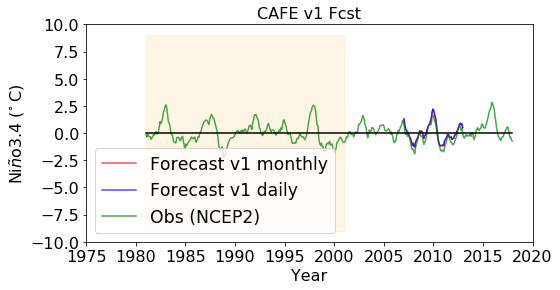

Diag= False
monthly_clim_anom: All years have 12 months.


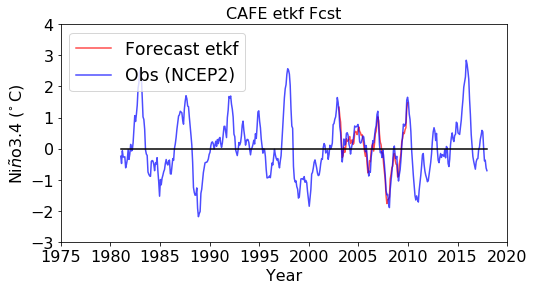

Diag= False
monthly_clim_anom: All years have 12 months.
Diag= False
monthly_clim_anom: All years have 12 months.


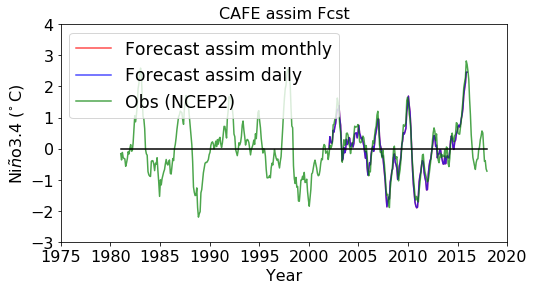

plotting...
Image saved to  panel1.png
Image saved to  panel2.png
Image saved to  panel3.png
Image saved to  panel4.png
Image saved to  panel5.png
Image saved to  panel6.png
Image saved to  panel7.png
END


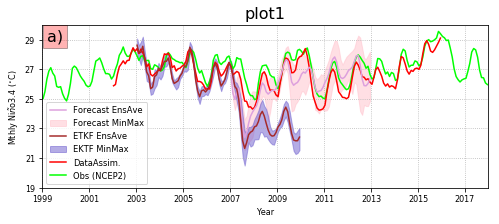

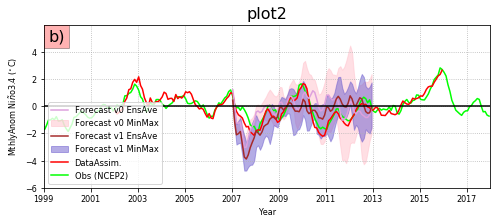

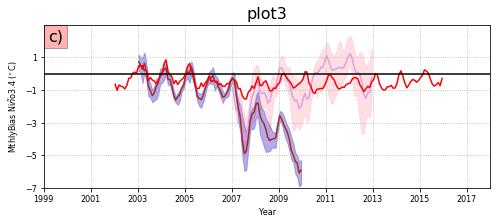

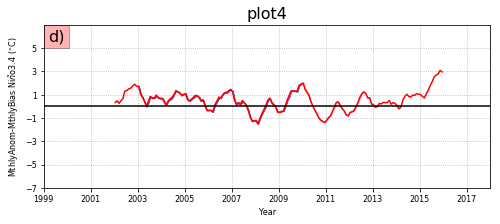

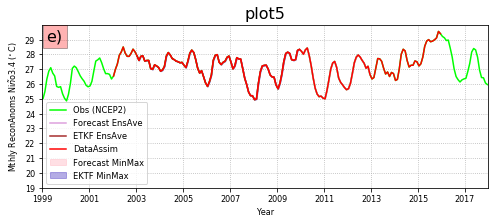

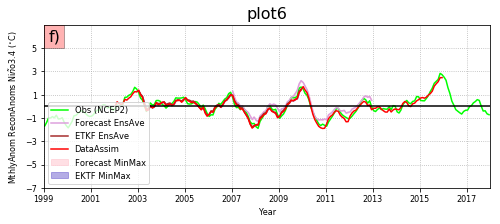

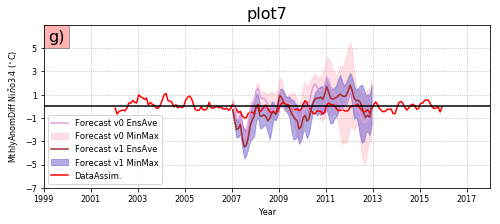

In [25]:
print('BEGIN')

import socket
import re
import os
import sys

print('sys.version=',sys.version)

hostname=socket.gethostname()

print('hostname=',hostname)

if(re.match('raijin',hostname)):
  print('this is rajin')
  rundir='/short/v14/mac599/cafepp/rundir'
  topdir=''
elif(re.match('oa-3.-cdc',hostname)):
  print('this is vm32')
  rundir='/OSM/CBR/OA_DCFP/work/col414/cafepp'
  topdir='/OSM/CBR/OA_DCFP/data/CAFEPP/CMIP6'
  topdir='/OSM/CBR/OA_DCFP/work/col414/CAFEPP/CMIP6'
  topdir_ncep='/OSM/CBR/OA_DCFP/data/CAFEPP/'
else:
  raise SystemExit('host not known:'+__file__+' line number: '+str(inspect.stack()[0][2]))

os.chdir(rundir)

os.chdir('/OSM/CBR/OA_DCFP/work/col414/cafepp')

print('Current Working Directory=',os.getcwd())

Clobber=False
Clobber=True

output_name='cafe_eg12.pkl'
input_name=output_name

output_type='pdf'
output_type='png'

title=True
#title=False #turn off title across whole set.

###

if(Clobber):

  print(CRED+'overwriting output PKL file '+output_name+' and regenerating...'+CEND)
    
  nino_indice_labels=ncepr2_nino_indices.indices_label
    
  ncepr2_year_fraction_from_daily=ncepr2_file_var_from_daily.year_fraction_anomaly
  ncepr2_year_fraction_from_monthly=ncepr2_file_var_from_monthly.year_fraction_anomaly
  hadisst_year_fraction_from_monthly=hadisst_file_var.year_fraction_anomaly
  cafe_assim_year_fraction_from_daily=cafe_daily_files_assim.year_fraction_anomaly
  cafe_assim_year_fraction_from_monthly=cafe_monthly_files_assim.year_fraction_anomaly
  cafe_v0_year_fraction_from_daily=cafe_daily_files_v0.year_fraction_anomaly
  cafe_v0_year_fraction_from_monthly=cafe_monthly_files_v0.year_fraction_anomaly
  cafe_v1_year_fraction_from_daily=cafe_daily_files_v1.year_fraction_anomaly
  cafe_v1_year_fraction_from_monthly=cafe_monthly_files_v1.year_fraction_anomaly
  cafe_etkf_year_fraction_from_daily=cafe_daily_files_etkf.year_fraction_anomaly
  
  ncepr2_date_time_stamp_anomaly_from_daily = ncepr2_file_var_from_daily.date_time_stamp_anomaly
  ncepr2_date_time_stamp_anomaly_from_monthly = ncepr2_file_var_from_monthly.date_time_stamp_anomaly
  hadisst_date_time_stamp_anomaly_from_monthly = hadisst_file_var.date_time_stamp_anomaly
  cafe_v0_date_time_stamp_anomaly_from_daily = cafe_daily_files_v0.date_time_stamp_anomaly
  cafe_v0_date_time_stamp_anomaly_from_monthly = cafe_monthly_files_v0.date_time_stamp_anomaly
  cafe_v1_date_time_stamp_anomaly_from_daily = cafe_daily_files_v1.date_time_stamp_anomaly
  cafe_v1_date_time_stamp_anomaly_from_monthly = cafe_monthly_files_v1.date_time_stamp_anomaly
  cafe_etkf_date_time_stamp_anomaly_from_daily = cafe_daily_files_etkf.date_time_stamp_anomaly
  cafe_assim_date_time_stamp_anomaly_from_daily = cafe_daily_files_assim.date_time_stamp_anomaly
  cafe_assim_date_time_stamp_anomaly_from_monthly = cafe_monthly_files_assim.date_time_stamp_anomaly
  
#   print(ncepr2_file_var_from_daily.num_stamp_anomaly)
#   print(cafe_daily_files_v1.num_stamp_anomaly)
  
#   print(len(cafe_monthly_files_v1.num_stamp_anomaly))
#   print(type(cafe_monthly_files_v1.num_stamp_anomaly))
  
#   print(cafe_monthly_files_v1.num_stamp_anomaly)
#   print(cafe_monthly_files_v1.num_stamp_anomaly[0][:])
  
  ncepr2_num_stamp_anomaly_from_daily = ncepr2_file_var_from_daily.num_stamp_anomaly
  ncepr2_num_stamp_anomaly_from_monthly = ncepr2_file_var_from_monthly.num_stamp_anomaly
  hadisst_num_stamp_anomaly_from_monthly = hadisst_file_var.num_stamp_anomaly
  cafe_v0_num_stamp_anomaly_from_daily = cafe_daily_files_v0.num_stamp_anomaly
  cafe_v0_num_stamp_anomaly_from_monthly = cafe_monthly_files_v0.num_stamp_anomaly[0][:]
  cafe_v1_num_stamp_anomaly_from_daily = cafe_daily_files_v1.num_stamp_anomaly
  cafe_v1_num_stamp_anomaly_from_monthly = cafe_monthly_files_v1.num_stamp_anomaly[0][:]
  cafe_etkf_num_stamp_anomaly_from_daily = cafe_daily_files_etkf.num_stamp_anomaly
  cafe_assim_num_stamp_anomaly_from_daily = cafe_daily_files_assim.num_stamp_anomaly
  cafe_assim_num_stamp_anomaly_from_monthly = cafe_monthly_files_assim.num_stamp_anomaly
    
  #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

  ncepr2_nfiles_from_daily = ncepr2_file_var_from_daily.nfiles
  ncepr2_nfiles_from_monthly = ncepr2_file_var_from_monthly.nfiles
  hadisst_nfiles_from_monthly = hadisst_file_var.nfiles
  cafe_v0_nfiles_from_daily = cafe_daily_files_v0.nfiles
  cafe_v0_nfiles_from_monthly = cafe_monthly_files_v0.nfiles
  cafe_v1_nfiles_from_daily = cafe_daily_files_v1.nfiles
  cafe_v1_nfiles_from_monthly = cafe_monthly_files_v1.nfiles
  cafe_etkf_nfiles_from_daily = cafe_daily_files_etkf.nfiles
  cafe_assim_nfiles_from_daily = cafe_daily_files_assim.nfiles
  cafe_assim_nfiles_from_monthly = cafe_monthly_files_assim.nfiles

  ncepr2_nindices_nino = ncepr2_nino_indices.nindices_nino
  hadisst_nindices_nino = hadisst_nino_indices.nindices_nino
  cafe_v0_nindices_nino = cafe_v0_nino_indices.nindices_nino
  cafe_v1_nindices_nino = cafe_v1_nino_indices.nindices_nino
  cafe_etkf_nindices_nino = cafe_etkf_nino_indices.nindices_nino
  cafe_assim_nindices_nino = cafe_assim_nino_indices.nindices_nino
    
  ncepr2_nindices_label = ncepr2_nino_indices.indices_label
  hadisst_nindices_label = hadisst_nino_indices.indices_label
  cafe_v0_nindices_label = cafe_v0_nino_indices.indices_label
  cafe_v1_nindices_label = cafe_v1_nino_indices.indices_label
  cafe_etkf_nindices_label = cafe_etkf_nino_indices.indices_label
  cafe_assim_nindices_label = cafe_assim_nino_indices.indices_label

  ncepr2_date_time_stamp_from_daily=ncepr2_file_var_from_daily.date_time_stamp_monthly
  ncepr2_date_time_stamp_from_monthly=ncepr2_file_var_from_monthly.date_time_stamp_tfreq
  hadiist_date_time_stamp_from_monthly=hadisst_file_var.date_time_stamp_tfreq
  cafe_v0_date_time_stamp_from_daily=cafe_daily_files_v0.date_time_stamp_monthly
  cafe_v0_date_time_stamp_from_monthly=cafe_monthly_files_v0.date_time_stamp_tfreq
  cafe_v1_date_time_stamp_from_daily=cafe_daily_files_v1.date_time_stamp_monthly
  cafe_v1_date_time_stamp_from_monthly=cafe_monthly_files_v1.date_time_stamp_tfreq
  cafe_etkf_date_time_stamp_from_daily=cafe_daily_files_etkf.date_time_stamp_monthly
  cafe_assim_date_time_stamp_from_daily=cafe_daily_files_assim.date_time_stamp_monthly
  cafe_assim_date_time_stamp_from_monthly=cafe_monthly_files_assim.date_time_stamp_tfreq
  
  ncepr2_time_tfreq_units_from_daily=ncepr2_file_var_from_daily.time_tfreq_units 
  ncepr2_time_tfreq_units_from_monthly=ncepr2_file_var_from_monthly.time_tfreq_units
  hadisst_time_tfreq_units_from_monthly=hadisst_file_var.time_tfreq_units
  cafe_v0_time_tfreq_units_from_daily=cafe_daily_files_v0.time_tfreq_units
  cafe_v0_time_tfreq_units_from_monthly=cafe_monthly_files_v0.time_tfreq_units  
  cafe_v1_time_tfreq_units_from_daily=cafe_daily_files_v1.time_tfreq_units
  cafe_v1_time_tfreq_units_from_monthly=cafe_monthly_files_v1.time_tfreq_units  
  cafe_etkf_time_tfreq_units_from_daily=cafe_daily_files_etkf.time_tfreq_units    
  cafe_assim_time_tfreq_units_from_daily=cafe_daily_files_assim.time_tfreq_units  
  cafe_assim_time_tfreq_units_from_monthly=cafe_monthly_files_assim.time_tfreq_units  

  ncepr2_time_tfreq_calendar_from_daily=ncepr2_file_var_from_daily.time_tfreq_calendar
  ncepr2_time_tfreq_calendar_from_monthly=ncepr2_file_var_from_monthly.time_tfreq_calendar
  hadisst_time_tfreq_calendar_from_monthly=hadisst_file_var.time_tfreq_calendar
  cafe_v0_time_tfreq_calendar_from_daily=cafe_daily_files_v0.time_tfreq_calendar 
  cafe_v0_time_tfreq_calendar_from_monthly=cafe_monthly_files_v0.time_tfreq_calendar  
  cafe_v1_time_tfreq_calendar_from_daily=cafe_daily_files_v1.time_tfreq_calendar  
  cafe_v1_time_tfreq_calendar_from_monthly=cafe_monthly_files_v1.time_tfreq_calendar  
  cafe_etkf_time_tfreq_calendar_from_daily=cafe_daily_files_etkf.time_tfreq_calendar    
  cafe_assim_time_tfreq_calendar_from_daily=cafe_daily_files_assim.time_tfreq_calendar  
  cafe_assim_time_tfreq_calendar_from_monthly=cafe_monthly_files_assim.time_tfreq_calendar  
  
  #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

  pkl_objects=( \
    nino_indice_labels, \
    \
    ncepr2_nino_monthly_from_daily, \
    ncepr2_nino_monthly_from_monthly, \
    hadisst_nino_monthly, \
    cafe_nino_monthly_from_daily_v0, \
    cafe_nino_monthly_from_monthly_v0, \
    cafe_nino_monthly_from_daily_v1, \
    cafe_nino_monthly_from_monthly_v1, \
    cafe_nino_monthly_from_daily_etkf, \
    cafe_nino_monthly_from_daily_assim, \
    cafe_nino_monthly_from_monthly_assim, \
    \
    ncepr2_nino_monthlyanomaly_from_daily, \
    ncepr2_nino_monthlyanomaly_from_monthly, \
    hadisst_nino_monthlyanomaly, \
    cafe_nino_monthlyanomaly_from_daily_v0, \
    cafe_nino_monthlyanomaly_from_monthly_v0, \
    cafe_nino_monthlyanomaly_from_daily_v1, \
    cafe_nino_monthlyanomaly_from_monthly_v1, \
    cafe_nino_monthlyanomaly_from_daily_etkf, \
    cafe_nino_monthlyanomaly_from_daily_assim, \
    cafe_nino_monthlyanomaly_from_monthly_assim, \
    \
    ncepr2_year_fraction_from_daily, \
    ncepr2_year_fraction_from_monthly, \
    hadisst_year_fraction_from_monthly, \
    cafe_v0_year_fraction_from_daily, \
    cafe_v0_year_fraction_from_monthly, \
    cafe_v1_year_fraction_from_daily, \
    cafe_v1_year_fraction_from_monthly, \
    cafe_etkf_year_fraction_from_daily, \
    cafe_assim_year_fraction_from_daily, \
    cafe_assim_year_fraction_from_monthly, \
    \
    ncepr2_date_time_stamp_anomaly_from_daily, \
    ncepr2_date_time_stamp_anomaly_from_monthly, \
    hadisst_date_time_stamp_anomaly_from_monthly, \
    cafe_v0_date_time_stamp_anomaly_from_daily, \
    cafe_v0_date_time_stamp_anomaly_from_monthly, \
    cafe_v1_date_time_stamp_anomaly_from_daily, \
    cafe_v1_date_time_stamp_anomaly_from_monthly, \
    cafe_etkf_date_time_stamp_anomaly_from_daily, \
    cafe_assim_date_time_stamp_anomaly_from_daily, \
    cafe_assim_date_time_stamp_anomaly_from_monthly, \
    \
    ncepr2_num_stamp_anomaly_from_daily, \
    ncepr2_num_stamp_anomaly_from_monthly, \
    hadisst_num_stamp_anomaly_from_monthly, \
    cafe_v0_num_stamp_anomaly_from_daily, \
    cafe_v0_num_stamp_anomaly_from_monthly, \
    cafe_v1_num_stamp_anomaly_from_daily, \
    cafe_v1_num_stamp_anomaly_from_monthly, \
    cafe_etkf_num_stamp_anomaly_from_daily, \
    cafe_assim_num_stamp_anomaly_from_daily, \
    cafe_assim_num_stamp_anomaly_from_monthly, \
    \
    ncepr2_nfiles_from_daily, \
    ncepr2_nfiles_from_monthly, \
    hadisst_nfiles_from_monthly, \
    cafe_v0_nfiles_from_daily, \
    cafe_v0_nfiles_from_monthly, \
    cafe_v1_nfiles_from_daily, \
    cafe_v1_nfiles_from_monthly, \
    cafe_etkf_nfiles_from_daily, \
    cafe_assim_nfiles_from_daily, \
    cafe_assim_nfiles_from_monthly, \
    \
    ncepr2_nindices_nino, \
    hadisst_nindices_nino, \
    cafe_v0_nindices_nino, \
    cafe_v1_nindices_nino, \
    cafe_etkf_nindices_nino, \
    cafe_assim_nindices_nino, \
    \
    ncepr2_nindices_label, \
    hadisst_nindices_label, \
    cafe_v0_nindices_label, \
    cafe_v1_nindices_label, \
    cafe_etkf_nindices_label, \
    cafe_assim_nindices_label, \
    \
    ncepr2_date_time_stamp_from_daily, \
    ncepr2_date_time_stamp_from_monthly, \
    hadiist_date_time_stamp_from_monthly, \
    cafe_v0_date_time_stamp_from_daily, \
    cafe_v0_date_time_stamp_from_monthly, \
    cafe_v1_date_time_stamp_from_daily, \
    cafe_v1_date_time_stamp_from_monthly, \
    cafe_etkf_date_time_stamp_from_daily, \
    cafe_assim_date_time_stamp_from_daily, \
    cafe_assim_date_time_stamp_from_monthly, \
    \
    ncepr2_time_tfreq_units_from_daily, \
    ncepr2_time_tfreq_units_from_monthly, \
    hadisst_time_tfreq_units_from_monthly, \
    cafe_v0_time_tfreq_units_from_daily, \
    cafe_v0_time_tfreq_units_from_monthly, \
    cafe_v1_time_tfreq_units_from_daily, \
    cafe_v1_time_tfreq_units_from_monthly, \
    cafe_etkf_time_tfreq_units_from_daily, \
    cafe_assim_time_tfreq_units_from_daily, \
    cafe_assim_time_tfreq_units_from_monthly, \
    \
    ncepr2_time_tfreq_calendar_from_daily, \
    ncepr2_time_tfreq_calendar_from_monthly, \
    hadisst_time_tfreq_calendar_from_monthly, \
    cafe_v0_time_tfreq_calendar_from_daily, \
    cafe_v0_time_tfreq_calendar_from_monthly, \
    cafe_v1_time_tfreq_calendar_from_daily, \
    cafe_v1_time_tfreq_calendar_from_monthly, \
    cafe_etkf_time_tfreq_calendar_from_daily, \
    cafe_assim_time_tfreq_calendar_from_daily, \
    cafe_assim_time_tfreq_calendar_from_monthly \
    )
  
  #print('len(pkl_objects)=',len(pkl_objects))
  
  if(os.path.exists(output_name)):
    print(CRED+'Pkl file exists and deleting...'+CEND)
    os.remove(output_name)

# print('opening & write & close normal')
# pickling_out = open(output_name, 'wb')
# pickle.dump(pkl_objects, pickling_out)
# pickling_out.close()

  print('opening & write & close small')
  pickling_out = bz2.BZ2File(output_name, 'wb')
  pickle.dump(pkl_objects, pickling_out)
  pickling_out.close()

#raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))
  
if(os.path.exists(output_name) and not Clobber):
  print(CRED+'Pkl file '+output_name+' exists and keeping...'+CEND)
    
print(CRED+'Pkl read from new or existing '+input_name+' ...create different output names compared to input...'+CEND)
if(os.path.exists(input_name)):
  pickling_in = bz2.BZ2File(input_name, "rb")
  nino_indice_labels, \
    ncepr2_mondata_from_daily, ncepr2_mondata_from_monthly, hadisst_mondata_from_monthly, cafe_v0_mondata_from_daily, cafe_v0_mondata_from_monthly, cafe_v1_mondata_from_daily, cafe_v1_mondata_from_monthly, cafe_etkf_mondata_from_daily, cafe_assim_mondata_from_daily, cafe_assim_mondata_from_monthly, \
    \
    ncepr2_anomdata_from_daily, ncepr2_anomdata_from_monthly, hadisst_anomdata_from_monthly, cafe_v0_anomdata_from_daily, cafe_v0_anomdata_from_monthly, cafe_v1_anomdata_from_daily, cafe_v1_anomdata_from_monthly, cafe_etkf_anomdata_from_daily, cafe_assim_anomdata_from_daily, cafe_assim_anomdata_from_monthly, \
    \
    ncepr2_time_from_daily, ncepr2_time_from_monthly, hadisst_time_from_monthly, cafe_v0_time_from_daily, cafe_v0_time_from_monthly, cafe_v1_time_from_daily, cafe_v1_time_from_monthly, cafe_etkf_time_from_daily, cafe_assim_time_from_daily, cafe_assim_time_from_monthly, \
    \
    ncepr2_stamp_anomaly_from_daily, ncepr2_stamp_anomaly_from_monthly, hadisst_stamp_anomaly_from_monthly, cafe_v0_stamp_anomaly_from_daily, cafe_v0_stamp_anomaly_from_monthly, cafe_v1_stamp_anomaly_from_daily, cafe_v1_stamp_anomaly_from_monthly, cafe_etkf_stamp_anomaly_from_daily, cafe_assim_stamp_anomaly_from_daily, cafe_assim_stamp_anomaly_from_monthly, \
    \
    ncepr2_num_stamp_anomaly_from_daily, ncepr2_num_stamp_anomaly_from_monthly, hadisst_num_stamp_anomaly_from_monthly, cafe_v0_num_stamp_anomaly_from_daily, cafe_v0_num_stamp_anomaly_from_monthly, cafe_v1_num_stamp_anomaly_from_daily, cafe_v1_num_stamp_anomaly_from_monthly, cafe_etkf_num_stamp_anomaly_from_daily, cafe_assim_num_stamp_anomaly_from_daily, cafe_assim_num_stamp_anomaly_from_monthly, \
    \
    ncepr2_nfil_from_daily, ncepr2_nfil_from_monthly, hadiist_nfil_from_monthly, cafe_v0_nfil_from_daily, cafe_v0_nfil_from_monthly, cafe_v1_nfil_from_daily, cafe_v1_nfil_from_monthly, cafe_etkf_nfil_from_daily, cafe_assim_nfil_from_daily, cafe_assim_nfil_from_monthly, \
    \
    ncepr2_nind, hadiist_nind, cafe_v0_nind, cafe_v1_nind, cafe_etkf_nind, cafe_assim_nind, \
    \
    ncepr2_labs, hadiist_labs, cafe_v0_labs, cafe_v1_labs, cafe_etkf_labs, cafe_assim_labs, \
    \
    ncepr2_stamp_from_daily, ncepr2_stamp_from_monthly, hadiist_stamp_from_monthly, cafe_v0_stamp_from_daily, cafe_v0_stamp_from_monthly, cafe_v1_stamp_from_daily, cafe_v1_stamp_from_monthly, cafe_etkf_stamp_from_daily, cafe_assim_stamp_from_daily, cafe_assim_stamp_from_monthly, \
    \
    ncepr2_time_units_from_daily, ncepr2_time_units_from_monthly, hadisst_time_units_from_monthly, cafe_v0_time_units_from_daily, cafe_v0_time_units_from_monthly, cafe_v1_time_units_from_daily, cafe_v1_time_units_from_monthly, cafe_etkf_time_units_from_daily, cafe_assim_time_units_from_monthly, cafe_assim_time_units_from_daily, \
    \
    ncepr2_time_calendar_from_daily, ncepr2_time_calendar_from_monthly, hadisst_time_calendar_from_monthly, cafe_v0_time_calendar_from_daily, cafe_v0_time_calendar_from_monthly, cafe_v1_time_calendar_from_daily, cafe_v1_time_calendar_from_monthly,  cafe_etkf_time_calendar_from_daily, cafe_assim_time_calendar_from_daily, cafe_assim_time_calendar_from_monthly \
    = pickle.load(pickling_in)
  pickling_in.close()  
  
  #cafe_v1_time_data_from_daily
  #cafe_etkf_time_calendar_from_daily
  
print(CRED+'aligning model and observational times...'+CEND)

ncepr2_years_months_from_daily=[]
for cnt in range(ncepr2_stamp_anomaly_from_daily.size):
  ncepr2_years_months_from_daily.append(ncepr2_stamp_anomaly_from_daily[cnt].year*100+ncepr2_stamp_anomaly_from_daily[cnt].month)

ncepr2_years_months_from_monthly=[]
for cnt in range(ncepr2_stamp_anomaly_from_monthly.size):
  ncepr2_years_months_from_monthly.append(ncepr2_stamp_anomaly_from_monthly[cnt].year*100+ncepr2_stamp_anomaly_from_monthly[cnt].month)

cafe_assim_year_month1_from_daily=cafe_assim_stamp_from_daily[0].year*100+cafe_assim_stamp_from_daily[0].month
cafe_assim_year_monthN_from_daily=cafe_assim_stamp_from_daily[-1].year*100+cafe_assim_stamp_from_daily[-1].month

cafe_assim_year_month1_from_monthly=cafe_assim_stamp_from_monthly[0].year*100+cafe_assim_stamp_from_daily[0].month
cafe_assim_year_monthN_from_monthly=cafe_assim_stamp_from_monthly[-1].year*100+cafe_assim_stamp_from_daily[-1].month

cafe_v0_year_month1_from_daily=cafe_v0_stamp_from_daily[0].year*100+cafe_v0_stamp_from_daily[0].month
cafe_v0_year_monthN_from_daily=cafe_v0_stamp_from_daily[-1].year*100+cafe_v0_stamp_from_daily[-1].month

cafe_v0_year_month1_from_monthly=cafe_v0_stamp_from_monthly[0][0].year*100+cafe_v0_stamp_from_monthly[0][0].month
cafe_v0_year_monthN_from_monthly=cafe_v0_stamp_from_monthly[0][-1].year*100+cafe_v0_stamp_from_monthly[0][-1].month

cafe_v1_year_month1_from_daily=cafe_v1_stamp_from_daily[0].year*100+cafe_v1_stamp_from_daily[0].month
cafe_v1_year_monthN_from_daily=cafe_v1_stamp_from_daily[-1].year*100+cafe_v1_stamp_from_daily[-1].month

cafe_v1_year_month1_from_monthly=cafe_v1_stamp_from_monthly[0][0].year*100+cafe_v1_stamp_from_monthly[0][0].month
cafe_v1_year_monthN_from_monthly=cafe_v1_stamp_from_monthly[0][-1].year*100+cafe_v1_stamp_from_monthly[0][-1].month

cafe_etkf_year_monthN=cafe_etkf_stamp_from_daily[-1].year*100+cafe_etkf_stamp_from_daily[-1].month
cafe_etkf_year_month1=cafe_etkf_stamp_from_daily[0].year*100+cafe_etkf_stamp_from_daily[0].month

cafe_assim_first_index_from_daily=ncepr2_years_months_from_daily.index(cafe_assim_year_month1_from_daily)
cafe_assim_last_index_from_daily=ncepr2_years_months_from_daily.index(cafe_assim_year_monthN_from_daily)

cafe_assim_first_index_from_monthly=ncepr2_years_months_from_monthly.index(cafe_assim_year_month1_from_monthly)
cafe_assim_last_index_from_monthly=ncepr2_years_months_from_monthly.index(cafe_assim_year_monthN_from_monthly)

cafe_v0_first_index_from_daily=ncepr2_years_months_from_daily.index(cafe_v0_year_month1_from_monthly)
cafe_v0_last_index_from_daily=ncepr2_years_months_from_daily.index(cafe_v0_year_monthN_from_monthly)

cafe_v0_first_index_from_monthly=ncepr2_years_months_from_monthly.index(cafe_v0_year_month1_from_monthly)
cafe_v0_last_index_from_monthly=ncepr2_years_months_from_monthly.index(cafe_v0_year_monthN_from_monthly)

cafe_v1_first_index_from_daily=ncepr2_years_months_from_daily.index(cafe_v1_year_month1_from_monthly)
cafe_v1_last_index_from_daily=ncepr2_years_months_from_daily.index(cafe_v1_year_monthN_from_monthly)

cafe_v1_first_index_from_monthly=ncepr2_years_months_from_monthly.index(cafe_v1_year_month1_from_monthly)
cafe_v1_last_index_from_monthly=ncepr2_years_months_from_monthly.index(cafe_v1_year_monthN_from_monthly)

cafe_etkf_first_index=ncepr2_years_months_from_daily.index(cafe_etkf_year_month1)
cafe_etkf_last_index=ncepr2_years_months_from_daily.index(cafe_etkf_year_monthN)
  
#print('cafe_v1_first_index_from_daily,cafe_v1_last_index_from_daily=',cafe_v1_first_index_from_daily,cafe_v1_last_index_from_daily)
#print('cafe_v1_first_index_from_monthly,cafe_v1_last_index_from_monthly=',cafe_v1_first_index_from_monthly,cafe_v1_last_index_from_monthly)

#print(ncepr2_time[cafe_assim_first_index:cafe_assim_last_index+1])

#raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

#===============================================================================

print(CRED+'generating daily/monthly bias...'+CEND)

cafe_v0_bias_data_from_daily = ma.zeros((cafe_v0_last_index_from_daily-cafe_v0_first_index_from_daily+1, cafe_v0_nfil_from_daily, cafe_v1_nind),\
  dtype='f')
cafe_v0_bias_data_from_monthly = ma.zeros((cafe_v0_last_index_from_monthly-cafe_v0_first_index_from_monthly+1, cafe_v0_nfil_from_monthly, cafe_v0_nind),\
  dtype='f')
for enow in range(max_ensemble+0):
  cafe_v0_bias_data_from_monthly[:,enow,:] = cafe_v0_mondata_from_monthly[:,enow,:] - ncepr2_mondata_from_monthly[cafe_v0_first_index_from_monthly:cafe_v0_last_index_from_monthly+1,:]
cafe_v0_time_data_from_daily = ncepr2_time_from_daily[cafe_v0_first_index_from_daily:cafe_v0_last_index_from_daily+1]
cafe_v0_time_data_from_monthly = ncepr2_time_from_monthly[cafe_v0_first_index_from_monthly:cafe_v0_last_index_from_monthly+1]

cafe_v1_bias_data_from_daily = ma.zeros((cafe_v1_last_index_from_daily-cafe_v1_first_index_from_daily+1, cafe_v1_nfil_from_daily, cafe_v1_nind),\
  dtype='f')
cafe_v1_bias_data_from_monthly = ma.zeros((cafe_v1_last_index_from_monthly-cafe_v1_first_index_from_monthly+1, cafe_v1_nfil_from_monthly, cafe_v1_nind),\
  dtype='f')
for enow in range(max_ensemble+0):
  cafe_v1_bias_data_from_daily[:,enow,:] = cafe_v1_mondata_from_daily[:,enow,:] - ncepr2_mondata_from_daily[cafe_v1_first_index_from_daily:cafe_v1_last_index_from_daily+1,:]
  cafe_v1_bias_data_from_monthly[:,enow,:] = cafe_v1_mondata_from_monthly[:,enow,:] - ncepr2_mondata_from_monthly[cafe_v1_first_index_from_monthly:cafe_v1_last_index_from_monthly+1,:]
cafe_v1_time_data_from_daily = ncepr2_time_from_daily[cafe_v1_first_index_from_daily:cafe_v1_last_index_from_daily+1]
cafe_v1_time_data_from_monthly = ncepr2_time_from_monthly[cafe_v1_first_index_from_monthly:cafe_v1_last_index_from_monthly+1]

cafe_etkf_bias_data_from_daily = ma.zeros((cafe_etkf_last_index-cafe_etkf_first_index+1, cafe_etkf_nfil_from_daily, cafe_etkf_nind),\
  dtype='f')
for enow in range(max_ensemble+0):
  cafe_etkf_bias_data_from_daily[:,enow,:] = cafe_etkf_mondata_from_daily[:,enow,:] - ncepr2_mondata_from_daily[cafe_etkf_first_index:cafe_etkf_last_index+1,:]
cafe_etkf_time_data = ncepr2_time_from_daily[cafe_etkf_first_index:cafe_etkf_last_index+1]
cafe_assim_bias_data_from_daily = cafe_assim_mondata_from_daily - ncepr2_mondata_from_daily[cafe_assim_first_index_from_daily:cafe_assim_last_index_from_daily+1,:]
cafe_assim_bias_data_from_monthly = cafe_assim_mondata_from_monthly - ncepr2_mondata_from_monthly[cafe_assim_first_index_from_monthly:cafe_assim_last_index_from_monthly+1,:]
cafe_assim_time_data_from_daily = ncepr2_time_from_daily[cafe_assim_first_index_from_daily:cafe_assim_last_index_from_daily+1]
cafe_assim_time_data_from_monthly = ncepr2_time_from_monthly[cafe_assim_first_index_from_monthly:cafe_assim_last_index_from_monthly+1]

#===============================================================================

print(CRED+'generating anom MINUS daily/monthly bias...'+CEND)

cafe_v0_anomMbias_data_from_daily = ma.zeros((cafe_v0_last_index_from_daily-cafe_v0_first_index_from_daily+1, cafe_v0_nfil_from_daily, cafe_v0_nind),\
  dtype='f')
cafe_v0_anomMbias_data_from_monthly = ma.zeros((cafe_v0_last_index_from_monthly-cafe_v0_first_index_from_monthly+1, cafe_v0_nfil_from_monthly, cafe_v0_nind),\
  dtype='f')
for enow in range(max_ensemble+0):
  cafe_v0_anomMbias_data_from_daily[:,enow,:] = cafe_v0_anomdata_from_daily[:,enow,:] - (cafe_v0_mondata_from_daily[:,enow,:] - ncepr2_mondata_from_daily[cafe_v0_first_index_from_daily:cafe_v0_last_index_from_daily+1,:])
  cafe_v0_anomMbias_data_from_monthly[:,enow,:] = cafe_v0_anomdata_from_monthly[:,enow,:] - (cafe_v0_mondata_from_monthly[:,enow,:] - ncepr2_mondata_from_monthly[cafe_v0_first_index_from_monthly:cafe_v0_last_index_from_monthly+1,:])

cafe_v1_anomMbias_data_from_daily = ma.zeros((cafe_v1_last_index_from_daily-cafe_v1_first_index_from_daily+1, cafe_v1_nfil_from_daily, cafe_v1_nind),\
  dtype='f')
cafe_v1_anomMbias_data_from_monthly = ma.zeros((cafe_v1_last_index_from_monthly-cafe_v1_first_index_from_monthly+1, cafe_v1_nfil_from_monthly, cafe_v1_nind),\
  dtype='f')
for enow in range(max_ensemble+0):
  cafe_v1_anomMbias_data_from_daily[:,enow,:] = cafe_v1_anomdata_from_daily[:,enow,:] - (cafe_v1_mondata_from_daily[:,enow,:] - ncepr2_mondata_from_daily[cafe_v1_first_index_from_daily:cafe_v1_last_index_from_daily+1,:])
  cafe_v1_anomMbias_data_from_monthly[:,enow,:] = cafe_v1_anomdata_from_monthly[:,enow,:] - (cafe_v1_mondata_from_monthly[:,enow,:] - ncepr2_mondata_from_monthly[cafe_v1_first_index_from_monthly:cafe_v1_last_index_from_monthly+1,:])

cafe_etkf_anomMbias_data = ma.zeros((cafe_etkf_last_index-cafe_etkf_first_index+1, cafe_etkf_nfil_from_daily, cafe_etkf_nind),\
  dtype='f')
for enow in range(max_ensemble+0):
  print('enow=',enow)
  cafe_etkf_anomMbias_data[:,enow,:] = cafe_etkf_anomdata_from_daily[:,enow,:] - (cafe_etkf_mondata_from_daily[:,enow,:] - ncepr2_mondata_from_daily[cafe_etkf_first_index:cafe_etkf_last_index+1,:])
cafe_assim_anomMbias_data_from_daily = cafe_assim_anomdata_from_daily[:,:] - (cafe_assim_mondata_from_daily[:,:] - ncepr2_mondata_from_daily[cafe_assim_first_index_from_daily:cafe_assim_last_index_from_daily+1,:])
cafe_assim_anomMbias_data_from_monthly = cafe_assim_anomdata_from_monthly[:,:] - (cafe_assim_mondata_from_monthly[:,:] - ncepr2_mondata_from_monthly[cafe_assim_first_index_from_monthly:cafe_assim_last_index_from_monthly+1,:])

# anom minus bias = mod_mon - mod_clim,n + ncep_mon - mod_mon = ncep_mon - mod_clim,n: n is repeating monthly clim for every year n.
#===============================================================================

print(CRED+'reconstructing model data from daily/monthly data and bias...'+CEND)

cafe_v0_reconstructed_from_daily = cafe_v0_mondata_from_daily - cafe_v0_bias_data_from_daily
cafe_v0_reconstructed_from_monthly = cafe_v0_mondata_from_monthly - cafe_v0_bias_data_from_monthly
cafe_v1_reconstructed_from_daily = cafe_v1_mondata_from_daily - cafe_v1_bias_data_from_daily
cafe_v1_reconstructed_from_monthly = cafe_v1_mondata_from_monthly - cafe_v1_bias_data_from_monthly
cafe_etkf_reconstructed_from_daily = cafe_etkf_mondata_from_daily - cafe_etkf_bias_data_from_daily
cafe_assim_reconstructed_from_daily = cafe_assim_mondata_from_daily - cafe_assim_bias_data_from_daily
cafe_assim_reconstructed_from_monthly = cafe_assim_mondata_from_monthly - cafe_assim_bias_data_from_monthly

# reconstructed = mod_mon - mod_mon - ncep_mon = ncep_mon

#===============================================================================

# input_datas=(ncepr2_mondata[:,nino_index_k],)
# input_xvals=(ncepr2_time,)

# input_datas = input_datas + (cafe_assim_reconstructed[:,nino_index_k],)
# input_xvals = input_xvals + (cafe_assim_time_data,)

# plot_xy(Diag=False,input_data=input_datas,input_xvals=input_xvals, \
#   title='CAFE Fcst', \
#   units='$\!^\circ$C', \
#   xlab='Year', \
#   ylab=cafe_etkf_nino_indices.indices_label[nino_index_k]+' ('+'$\!^\circ$C'+')', \
#   zero2=True, \
#   reverse_xaxis=False, \
#   reverse_yaxis=False, \
#   line_colors=['red','blue'], \
#   line_labels=['Obs (NCEP2)','Assim'], \
#   legend_position='best', \
#   xysize=(10,5))

#===============================================================================

#This was old way of calculating anomalies, but I have modified n_data_funcs to have a 'dummy_mode'. This tricks it to doing monthly_clim_anom functionality by providing minimum of self.data objects.
#this old way was problematic, when PKLing, as needed to keep original n_data_funcs instances, which cannot be PKLed.

# cbeg=2007
# cend=2012
# abeg=2007
# aend=2012

# cafe_nino_monthlyclimatology_from_daily_v1_reconstructed,cafe_nino_monthlyanomaly_from_daily_v1_reconstructed=cafe_daily_files_v1.monthly_clim_anom( \
#     Diag=True, input=cafe_v1_reconstructed, AnnOut=False, ZeroClim=False, \
#     cbeg=cbeg, cend=cend, abeg=abeg, aend=aend)


# cbeg=2003
# cend=2009
# abeg=2003
# aend=2009
  
# cafe_nino_monthlyclimatology_from_daily_etkf_reconstructed,cafe_nino_monthlyanomaly_from_daily_etkf_reconstructed=cafe_daily_files_etkf.monthly_clim_anom( \
#     Diag=True, input=cafe_etkf_reconstructed, AnnOut=False, ZeroClim=False, \
#     cbeg=cbeg, cend=cend, abeg=abeg, aend=aend)

# input_datas=(ncepr2_nino_monthlyanomaly[:,nino_index_k],)
# input_xvals=(ncepr2_year_fraction,)

# input_datas = input_datas + (np.average(cafe_nino_monthlyanomaly_from_daily_v1_reconstructed[:,:,nino_index_k],axis=1),)
# input_xvals = input_xvals + (cafe_v1_time_data,)

# input_datas = input_datas + (np.average(cafe_nino_monthlyanomaly_from_daily_etkf_reconstructed[:,:,nino_index_k],axis=1),)
# input_xvals = input_xvals + (cafe_etkf_time_data,)

# plot_xy(Diag=False,input_data=input_datas,input_xvals=input_xvals, \
#   title='CAFE Fcst', \
#   units='$\!^\circ$C', \
#   xlab='Year', \
#   ylab=cafe_etkf_nino_indices.indices_label[nino_index_k]+' ('+'$\!^\circ$C'+')', \
#   zero2=True, \
#   reverse_xaxis=False, \
#   reverse_yaxis=False, \
#   line_colors=['red','blue','green'], \
#   line_labels=['Obs (NCEP2)','Forecast','ETKF'], \
#   legend_position='best', \
#   xysize=(10,5))

#===============================================================================

print(CRED+'generating model anomalies from reconstructed data...'+CEND)

#The new approach:

cbeg=2007
cend=2012
abeg=2007
aend=2012

test_v0_monthly = n_data_funcs(Diag=False, input_files=None, input_var_name=None, \
  dummy_mode=(False, cafe_v0_stamp_anomaly_from_monthly, cafe_v0_num_stamp_anomaly_from_monthly, \
  cafe_v0_time_units_from_monthly, cafe_v0_time_calendar_from_monthly)) #I think boolean for dummy_mode should be False but seems to work.

cafe_nino_monthlyclimatology_from_monthly_v0_reconstructed_test, cafe_nino_monthlyanomaly_from_monthly_v0_reconstructed_test= \
  test_v0_monthly.monthly_clim_anom( \
  Diag=False, input=cafe_v0_reconstructed_from_monthly, AnnOut=False, ZeroClim=False, \
  cbeg=cbeg, cend=cend, abeg=abeg, aend=aend)

test_v0_daily = n_data_funcs(Diag=False, input_files=None, input_var_name=None, \
  dummy_mode=(True, cafe_v0_stamp_anomaly_from_daily, cafe_v0_num_stamp_anomaly_from_daily, \
  cafe_v0_time_units_from_daily, cafe_v0_time_calendar_from_daily))

cafe_nino_monthlyclimatology_from_daily_v0_reconstructed_test, cafe_nino_monthlyanomaly_from_daily_v0_reconstructed_test= \
  test_v0_daily.monthly_clim_anom( \
  Diag=False, input=cafe_v0_reconstructed_from_daily, AnnOut=False, ZeroClim=False, \
  cbeg=cbeg, cend=cend, abeg=abeg, aend=aend)

#===============================================================================

cbeg=2007
cend=2012
abeg=2007
aend=2012

test_v1_monthly = n_data_funcs(Diag=False, input_files=None, input_var_name=None, \
  dummy_mode=(False, cafe_v1_stamp_anomaly_from_monthly, cafe_v1_num_stamp_anomaly_from_monthly, \
  cafe_v1_time_units_from_monthly, cafe_v1_time_calendar_from_monthly)) #I think boolean for dummy_mode should be False but seems to work.

cafe_nino_monthlyclimatology_from_monthly_v1_reconstructed_test, cafe_nino_monthlyanomaly_from_monthly_v1_reconstructed_test= \
  test_v1_monthly.monthly_clim_anom( \
  Diag=False, input=cafe_v1_reconstructed_from_monthly, AnnOut=False, ZeroClim=False, \
  cbeg=cbeg, cend=cend, abeg=abeg, aend=aend)

test_v1_daily = n_data_funcs(Diag=False, input_files=None, input_var_name=None, \
  dummy_mode=(True, cafe_v1_stamp_anomaly_from_daily, cafe_v1_num_stamp_anomaly_from_daily, \
  cafe_v1_time_units_from_daily, cafe_v1_time_calendar_from_daily))

cafe_nino_monthlyclimatology_from_daily_v1_reconstructed_test, cafe_nino_monthlyanomaly_from_daily_v1_reconstructed_test= \
  test_v1_daily.monthly_clim_anom( \
  Diag=False, input=cafe_v1_reconstructed_from_daily, AnnOut=False, ZeroClim=False, \
  cbeg=cbeg, cend=cend, abeg=abeg, aend=aend)

#raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

input_xvals = (cafe_v1_time_data_from_monthly,)
input_datas = (np.average(cafe_nino_monthlyanomaly_from_monthly_v1_reconstructed_test[:,:,nino_index_k],axis=1),)

input_xvals = input_xvals + (cafe_v1_time_data_from_daily,)
input_datas = input_datas + (np.average(cafe_nino_monthlyanomaly_from_daily_v1_reconstructed_test[:,1::,nino_index_k],axis=1),)

input_xvals = input_xvals + (ncepr2_time_from_monthly,)
input_datas = input_datas + (ncepr2_anomdata_from_monthly[:,nino_index_k],)

plot_xy(Diag=False,input_data=input_datas,input_xvals=input_xvals, \
  title='CAFE v1 Fcst', \
  units='$\!^\circ$C', \
  xlab='Year', \
  ylab=cafe_v1_labs[nino_index_k]+' ('+'$\!^\circ$C'+')', \
  zero2=True, \
  reverse_xaxis=False, \
  reverse_yaxis=False, \
  line_colors=['red','blue','green'], \
  line_labels=['Forecast v1 monthly','Forecast v1 daily','Obs (NCEP2)'], \
  legend_position='best', \
#  vertical_lines=([1980, 2005],[-10,5],['black','orange'],['--','--']), \
#  vertical_lines=([1980, 2005],['black','orange'],['--',':']), \
  ylim=[-10,10], \
  box_overlay=([[1981,2000+1,-5,5]],['orange'],[0.1]), \
#  box_overlay=([[1980,2005,-5,5],[2006,2008,-2,2]],['orange','yellow'],[0.1,0.1]), \
  xysize=(8,4))

#raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

#===============================================================================

cbeg=2003
cend=2009
abeg=2003
aend=2009

test_etkf_daily = n_data_funcs(Diag=False, input_files=None, input_var_name=None, \
  dummy_mode=(True, cafe_etkf_stamp_anomaly_from_daily, cafe_etkf_num_stamp_anomaly_from_daily, \
  cafe_etkf_time_units_from_daily, cafe_etkf_time_calendar_from_daily))

cafe_nino_monthlyclimatology_from_daily_etkf_reconstructed_test, cafe_nino_monthlyanomaly_from_daily_etkf_reconstructed_test= \
  test_etkf_daily.monthly_clim_anom( \
  Diag=False, input=cafe_etkf_reconstructed_from_daily, AnnOut=False, ZeroClim=False, \
  cbeg=cbeg, cend=cend, abeg=abeg, aend=aend)

input_xvals = (cafe_etkf_time_data,)
input_datas = (np.average(cafe_nino_monthlyanomaly_from_daily_etkf_reconstructed_test[:,1::,nino_index_k],axis=1),)

input_datas = input_datas + (ncepr2_anomdata_from_daily[:,nino_index_k],)
input_xvals = input_xvals + (ncepr2_time_from_daily,)

plot_xy(Diag=False,input_data=input_datas,input_xvals=input_xvals, \
  title='CAFE etkf Fcst', \
  units='$\!^\circ$C', \
  xlab='Year', \
  ylab=cafe_etkf_labs[nino_index_k]+' ('+'$\!^\circ$C'+')', \
  zero2=True, \
  reverse_xaxis=False, \
  reverse_yaxis=False, \
  line_colors=['red','blue'], \
  line_labels=['Forecast etkf','Obs (NCEP2)'], \
  legend_position='best', \
  xysize=(8,4))

#===============================================================================

cbeg=2002
cend=2015
abeg=2002
aend=2015

test_assim_monthly = n_data_funcs(Diag=False,input_files=None, input_var_name=None, \
  dummy_mode=(True, cafe_assim_stamp_anomaly_from_monthly, cafe_assim_num_stamp_anomaly_from_monthly, \
  cafe_assim_time_units_from_monthly, cafe_assim_time_calendar_from_monthly)) #I think boolean for dummy_mode should be False but seems to work.

cafe_nino_monthlyclimatology_from_monthly_assim_reconstructed_test, cafe_nino_monthlyanomaly_from_monthly_assim_reconstructed_test= \
  test_assim_monthly.monthly_clim_anom( \
  Diag=False, input=cafe_assim_reconstructed_from_monthly, AnnOut=False, ZeroClim=False, \
  cbeg=cbeg, cend=cend, abeg=abeg, aend=aend)

test_assim_daily = n_data_funcs(Diag=False,input_files=None, input_var_name=None, \
  dummy_mode=(True, cafe_assim_stamp_anomaly_from_daily, cafe_assim_num_stamp_anomaly_from_daily, \
  cafe_assim_time_units_from_monthly, cafe_assim_time_calendar_from_monthly))

cafe_nino_monthlyclimatology_from_daily_assim_reconstructed_test, cafe_nino_monthlyanomaly_from_daily_assim_reconstructed_test= \
  test_assim_daily.monthly_clim_anom( \
  Diag=False, input=cafe_assim_reconstructed_from_daily, AnnOut=False, ZeroClim=False, \
  cbeg=cbeg, cend=cend, abeg=abeg, aend=aend)

input_xvals = (cafe_assim_time_data_from_monthly,)
input_datas = (cafe_nino_monthlyanomaly_from_monthly_assim_reconstructed_test[:,nino_index_k],)

input_xvals = input_xvals + (cafe_assim_time_data_from_daily,)
input_datas = input_datas + (cafe_nino_monthlyanomaly_from_daily_assim_reconstructed_test[:,nino_index_k],)

input_xvals = input_xvals + (ncepr2_time_from_monthly,)
input_datas = input_datas + (ncepr2_anomdata_from_monthly[:,nino_index_k],)


plot_xy(Diag=False, input_data=input_datas, input_xvals=input_xvals, \
  title='CAFE assim Fcst', \
  units='$\!^\circ$C', \
  xlab='Year', \
  ylab=cafe_assim_labs[nino_index_k]+' ('+'$\!^\circ$C'+')', \
  zero2=True, \
  reverse_xaxis=False, \
  reverse_yaxis=False, \
  line_colors=['red','blue','green'], \
  line_labels=['Forecast assim monthly','Forecast assim daily','Obs (NCEP2)'], \
  legend_position='best', \
  xysize=(8,4))

#raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))
  
#===============================================================================

# print('len(nino_indice_labels)=',len(nino_indice_labels))

# print('ncepr2_mondata.shape=',ncepr2_mondata.shape)
# print('hadisst_mondata.shape=',hadisst_mondata.shape)
# print('cafe_assim_mondata.shape=',cafe_assim_mondata.shape)
# print('cafe_v1_mondata.shape=',cafe_v1_mondata.shape)
# print('cafe_etkf_mondata.shape=',cafe_etkf_mondata.shape)

# print('ncepr2_anomdata.shape=',ncepr2_anomdata.shape)
# print('hadisst_anomdata.shape=',hadisst_anomdata.shape)
# print('cafe_assim_anomdata.shape=',cafe_assim_anomdata.shape)
# print('cafe_v1_anomdata.shape=',cafe_v1_anomdata.shape)
# print('cafe_etkf_anomdata.shape=',cafe_etkf_anomdata.shape)

# print('ncepr2_time.shape=',ncepr2_time.shape)
# print('hadisst_time.shape=',hadisst_time.shape)
# print('cafe_assim_time.shape=',cafe_assim_time.shape)
# print('cafe_v1_time.shape=',cafe_v1_time.shape)
# print('cafe_etkf_time.shape=',cafe_etkf_time.shape)

#===============================================================================

print(CRED+'plotting...'+CEND)

input_xvals = (ncepr2_time_from_monthly,)
#input_xvals = input_xvals + (hadisst_time,)
input_xvals = input_xvals + (cafe_assim_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)

input_mondatas = (ncepr2_mondata_from_monthly[:,nino_index_k],)
#input_mondatas = input_mondatas + (hadisst_mondata[:,nino_index_k],)
input_mondatas = input_mondatas + (cafe_assim_mondata_from_monthly[:,nino_index_k],)
input_mondatas = input_mondatas + (np.min(cafe_v1_mondata_from_monthly[:,1::,nino_index_k],axis=1),)
input_mondatas = input_mondatas + (np.max(cafe_v1_mondata_from_monthly[:,1::,nino_index_k],axis=1),)
input_mondatas = input_mondatas + (np.average(cafe_v1_mondata_from_monthly[:,1::,nino_index_k],axis=1),)
input_mondatas = input_mondatas + (np.min(cafe_etkf_mondata_from_daily[:,1::,nino_index_k],axis=1),)
input_mondatas = input_mondatas + (np.max(cafe_etkf_mondata_from_daily[:,1::,nino_index_k],axis=1),)
input_mondatas = input_mondatas + (np.average(cafe_etkf_mondata_from_daily[:,1::,nino_index_k],axis=1),)

#monthly full
ylim=[19,30]
yticks=np.arange(19,30,2)

texts=None
#texts=[(0.5,0.5,'hello',16,False,True), (0.5,0.5,'there',16,False,True)]
#texts=[(2000,29,'a)',16,True,True)] #world coords.

texts=[(0.01,0.9,'a)',16,False,True)]
if(title): 
  title_here='plot1' 
else: 
  title_here=''
plot_xy(Diag=False, \
  title=title_here, \
  input_data=input_mondatas, \
  input_xvals=input_xvals, \
  units='$\!^\circ$C', \
  xlab='Year', \
  ylab='Mthly '+ncepr2_labs[nino_index_k]+' ($\!^\circ$C)', \
  zero2=True, \
  reverse_xaxis=False, \
  reverse_yaxis=False, \
  grid=True, \
  xysize=(8,3), \
  xlim=[1999,2018], \
  ylim=ylim, \
  xticks=np.arange(1999,2018,2), \
  yticks=yticks, \
  legend_position='lower left', \
  line_colors=['lime','red','pink','plum','SlateBlue','brown'], \
  line_alphas=[1.0,1.0,0.5,1.0,0.5,1.0], \
  line_labels=['Obs (NCEP2)','DataAssim.','Forecast MinMax','Forecast EnsAve','EKTF MinMax','ETKF EnsAve'], \
  fill_between=[0,1,2,2,3,4,4,5], \
  legend_item_reorder = [2,4,3,5,1,0], \
#  legend_item_reorder = [3,5,4,6,2,0,1], \
#   fill_between=[0,1,2,3,3,4,5,5,6], \
#   line_colors=['red','lime','cyan','pink','plum','SlateBlue','brown'], \
#   line_alphas=[1.0,1.0,1.0,0.3,1.0,0.3,1.0], \
#   line_labels=['Obs (NCEP2)','Obs (HadISST)','DataAssim.','Forecast MinMax','Forecast EnsAve','EKTF MinMax','ETKF EnsAve'], \
#   legend_item_reorder = [3,5,4,6,2,0,1], \
  xlab_fontsize=8.0, \
  ylab_fontsize=8.0, \
  xticks_fontsize=8.0, \
  yticks_fontsize=8.0, \
  legend_fontsize='small', \
  grid_linestyle='dotted', \
  xticks_lab_off=False, \
  texts=texts, \
#  vertical_lines=([cbeg_assim, cend_assim+1],['red','red'],[':',':']), \
  output=('panel1',output_type)
  )

#===============================================================================

#monthly anomalies

input_xvals = (ncepr2_time_from_monthly,)
#input_xvals = input_xvals + (hadisst_time,)
input_xvals = input_xvals + (cafe_assim_time_from_monthly,)
input_xvals = input_xvals + (cafe_v0_time_from_monthly,)
input_xvals = input_xvals + (cafe_v0_time_from_monthly,)
input_xvals = input_xvals + (cafe_v0_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
# input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
# input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
# input_xvals = input_xvals + (cafe_etkf_time_from_daily,)

input_anomdatas = (ncepr2_anomdata_from_monthly[:,nino_index_k],)
#input_anomdatas = input_anomdatas + (hadisst_anomdata[:,nino_index_k],)
input_anomdatas = input_anomdatas + (cafe_assim_anomdata_from_monthly[:,nino_index_k],)
input_anomdatas = input_anomdatas + (np.min(cafe_v0_anomdata_from_monthly[:,1::,nino_index_k],axis=1),)
input_anomdatas = input_anomdatas + (np.max(cafe_v0_anomdata_from_monthly[:,1::,nino_index_k],axis=1),)
input_anomdatas = input_anomdatas + (np.average(cafe_v0_anomdata_from_monthly[:,1::,nino_index_k],axis=1),)
input_anomdatas = input_anomdatas + (np.min(cafe_v1_anomdata_from_monthly[:,1::,nino_index_k],axis=1),)
input_anomdatas = input_anomdatas + (np.max(cafe_v1_anomdata_from_monthly[:,1::,nino_index_k],axis=1),)
input_anomdatas = input_anomdatas + (np.average(cafe_v1_anomdata_from_monthly[:,1::,nino_index_k],axis=1),)
# input_anomdatas = input_anomdatas + (np.min(cafe_etkf_anomdata_from_daily[:,1::,nino_index_k],axis=1),)
# input_anomdatas = input_anomdatas + (np.max(cafe_etkf_anomdata_from_daily[:,1::,nino_index_k],axis=1),)
# input_anomdatas = input_anomdatas + (np.average(cafe_etkf_anomdata_from_daily[:,1::,nino_index_k],axis=1),)

ylim=[-6,6]
yticks=np.arange(-6,6,2)

texts=[(0.01,0.9,'b)',16,False,True)]
if(title): 
  title_here='plot2' 
else: 
  title_here=''
  
plot_xy(Diag=False, \
  title=title_here, \
  input_data=input_anomdatas, \
  input_xvals=input_xvals, \
  units='$\!^\circ$C', \
 xlab='Year', \
  ylab='MthlyAnom '+ncepr2_labs[nino_index_k]+' ($\!^\circ$C)', \
  zero2=True, \
  reverse_xaxis=False, \
  reverse_yaxis=False, \
  grid=True, \
  xysize=(8,3), \
  xlim=[1999,2018], \
  ylim=ylim, \
  xticks=np.arange(1999,2018,2), \
  yticks=yticks, \
  legend_position='lower left', \
  line_colors=['lime','red','pink','plum','SlateBlue','brown'], \
  line_alphas=[1.0,1.0,0.5,1.0,0.5,1.0], \
#   line_labels=['Obs (NCEP2)','DataAssim.','Forecast MinMax','Forecast EnsAve','EKTF MinMax','ETKF EnsAve'], \
  line_labels=['Obs (NCEP2)','DataAssim.','Forecast v0 MinMax','Forecast v0 EnsAve','Forecast v1 MinMax','Forecast v1 EnsAve'], \
  fill_between=[0,1,2,2,3,4,4,5], \
  legend_item_reorder = [2,4,3,5,1,0], \
#   line_colors=['red','lime','cyan','pink','plum','SlateBlue','brown'], \
#   line_alphas=[1.0,1.0,1.0,0.3,1.0,0.3,1.0], \
#   line_labels=['Obs (NCEP2)','Obs (HadISST)','DataAssim.','Forecast MinMax','Forecast EnsAve','EKTF MinMax','ETKF'], \
#   fill_between=[0,1,2,3,3,4,5,5,6], \
#   legend_item_reorder = [0,1,2,3,4,5,6], \
  xlab_fontsize=8.0, \
  ylab_fontsize=8.0, \
  xticks_fontsize=8.0, \
  yticks_fontsize=8.0, \
  legend_fontsize='small', \
  legend_off=False, \
  grid_linestyle='dotted', \
  texts=texts, \
#  xticks_lab_off=True, \
#  vertical_lines=([1980, 2005],[-10,5],['black','orange'],['--','--']), \
#  vertical_lines=([1980, 2005],['black','orange'],['--',':']), \
#  ylim=[-5,5], \
#   vertical_lines=([2002, 2015+1, 1981, 2000+1],['red','red','green','green'],[':',':',':',':']), \
#  box_overlay=([[2002, 2015+1,-5,5],[1981, 2000+1,-2,2]],['orange','yellow'],[0.1,0.1]), \
  output=('panel2',output_type)
  )

#===============================================================================

input_xvals = (cafe_v1_time_data_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_data_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_data_from_monthly,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_assim_time_from_monthly,)

input_datas = (np.min(cafe_v1_bias_data_from_monthly[:,1::,nino_index_k],axis=1),)
input_datas = input_datas + (np.max(cafe_v1_bias_data_from_monthly[:,1::,nino_index_k],axis=1),)
input_datas = input_datas + (np.average(cafe_v1_bias_data_from_monthly[:,1::,nino_index_k],axis=1),)
input_datas = input_datas + (np.min(cafe_etkf_bias_data_from_daily[:,1::,nino_index_k],axis=1),)
input_datas = input_datas + (np.max(cafe_etkf_bias_data_from_daily[:,1::,nino_index_k],axis=1),)
input_datas = input_datas + (np.average(cafe_etkf_bias_data_from_daily[:,1::,nino_index_k],axis=1),)
input_datas = input_datas + (cafe_assim_bias_data_from_monthly[:,nino_index_k],)

ylim=[-7,3]
yticks=np.arange(-7,3,2)

texts=[(0.01,0.9,'c)',16,False,True)]
if(title): 
  title_here='plot3' 
else: 
  title_here=''
  
plot_xy(Diag=False, \
  title=title_here, \
  input_data=input_datas, \
  input_xvals=input_xvals, \
  units='$\!^\circ$C', \
  xlab='Year', \
  ylab='MthlyBias '+ncepr2_labs[nino_index_k]+' ('+'$\!^\circ$C'+')', \
  zero2=True, \
  grid=True, \
  xysize=(8,3), \
  xlim=[1999,2018], \
  ylim=ylim, \
  fill_between=[0,0,1,2,2,3,4], \
  xticks=np.arange(1999,2018,2), \
  yticks=yticks, \
  legend_position='upper right', \
  line_colors=['pink','plum','SlateBlue','brown','red'], \
  line_alphas=[0.5,1.0,0.5,1.0,1.0], \
  line_labels=['Forecast MinMax','Forecast EnsAve','EKTF MinMax','ETKF EnsAve','DataAssim'], \
  legend_item_reorder = [3,0,2,4,1], \
  xlab_fontsize=8.0, \
  ylab_fontsize=8.0, \
  xticks_fontsize=8.0, \
  yticks_fontsize=8.0, \
  legend_fontsize='small', \
  grid_linestyle='dotted', \
  legend_off=True, \
  xticks_lab_off=False, \
  texts=texts, \
  output=('panel3',output_type)
  )

#===============================================================================

input_xvals = (cafe_v1_time_data_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_assim_time_from_monthly,)

#normal
v1_scale=1.0
etkf_scale=1.0
assim_scale=1.0

#test
# v1_scale=0.0
# etkf_scale=1.2
# assim_scale=1.0

input_datas = (np.min(cafe_v1_anomMbias_data_from_monthly[:,1::,nino_index_k],axis=1)*v1_scale,)
input_datas = input_datas + (np.max(cafe_v1_anomMbias_data_from_monthly[:,1::,nino_index_k],axis=1)*v1_scale,)
input_datas = input_datas + (np.average(cafe_v1_anomMbias_data_from_monthly[:,1::,nino_index_k],axis=1)*v1_scale,)
input_datas = input_datas + (np.min(cafe_etkf_anomMbias_data[:,1::,nino_index_k],axis=1)*etkf_scale,)
input_datas = input_datas + (np.max(cafe_etkf_anomMbias_data[:,1::,nino_index_k],axis=1)*etkf_scale,)
input_datas = input_datas + (np.average(cafe_etkf_anomMbias_data[:,1::,nino_index_k],axis=1)*etkf_scale,)
input_datas = input_datas + (cafe_assim_anomMbias_data_from_monthly[:,nino_index_k]*assim_scale,)

texts=[(0.01,0.9,'d)',16,False,True)]
if(title): 
  title_here='plot4' 
else: 
  title_here=''
  
plot_xy(Diag=False, \
  title=title_here, \
  input_data=input_datas, \
  input_xvals=input_xvals, \
  units='$\!^\circ$C', \
  xlab='Year', \
  ylab='MthlyAnom-MthlyBias '+ncepr2_labs[nino_index_k]+' ('+'$\!^\circ$C'+')', \
  zero2=True, \
  grid=True, \
  xysize=(8,3), \
  xlim=[1999,2018], \
  ylim=[-7,7], \
  fill_between=[0,0,1,2,2,3,4], \
  xticks=np.arange(1999,2018,2), \
  yticks=np.arange(-7,7,2), \
  legend_position='best', \
  line_colors=['pink','plum','SlateBlue','brown','red'], \
  line_alphas=[1.0,0.5,1.0,0.5,1.0], \
  line_labels=['Forecast MinMax','Forecast EnsAve','EKTF MinMax','ETKF EnsAve','DataAssim'], \
  legend_item_reorder = [0,1,2,3,4], \
  xlab_fontsize=8.0, \
  ylab_fontsize=8.0, \
  xticks_fontsize=8.0, \
  yticks_fontsize=8.0, \
  legend_fontsize='small', \
  legend_off=True, \
  grid_linestyle='dotted', \
  texts=texts, \
  output=('panel4',output_type)
  )

#===============================================================================

input_xvals = (ncepr2_time_from_daily,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_assim_time_from_monthly,)

input_datas = (ncepr2_mondata_from_monthly[:,nino_index_k],)
input_datas = input_datas + (np.min(cafe_v1_reconstructed_from_monthly[:,1::,nino_index_k],axis=1),)
input_datas = input_datas + (np.max(cafe_v1_reconstructed_from_monthly[:,1::,nino_index_k],axis=1),)
input_datas = input_datas + (np.average(cafe_v1_reconstructed_from_monthly[:,1::,nino_index_k],axis=1),)
input_datas = input_datas + (np.min(cafe_etkf_reconstructed_from_daily[:,1::,nino_index_k],axis=1),)
input_datas = input_datas + (np.max(cafe_etkf_reconstructed_from_daily[:,1::,nino_index_k],axis=1),)
input_datas = input_datas + (np.average(cafe_etkf_reconstructed_from_daily[:,1::,nino_index_k],axis=1),)
input_datas = input_datas + (cafe_assim_reconstructed_from_monthly[:,nino_index_k],)

#print('ncepr2_time=',ncepr2_time)
#print('cafe_assim_time_data=',cafe_assim_time_data)

ylim=[19,30]
yticks=np.arange(19,30,1)

texts=[(0.01,0.9,'e)',16,False,True)]
if(title): 
  title_here='plot5' 
else: 
  title_here=''
  
plot_xy(Diag=False, \
  title=title_here, \
  input_data=input_datas, \
  input_xvals=input_xvals, \
  units='$\!^\circ$C', \
  xlab='Year', \
  ylab='Mthly ReconAnoms '+ncepr2_labs[nino_index_k]+' ('+'$\!^\circ$C'+')', \
  zero2=True, \
  grid=True, \
  xysize=(8,3), \
  xlim=[1999,2018], \
  ylim=ylim, \
  xticks=np.arange(1999,2018,2), \
  yticks=yticks, \
  legend_position='lower left', \
  fill_between=[0,1,1,2,3,3,4,5], \
  line_colors=['lime','pink','plum','SlateBlue','brown','red'], \
  line_alphas=[1.0,0.5,1.0,0.5,1.0,1.0], \
  line_labels=['Obs (NCEP2)','Forecast MinMax','Forecast EnsAve','EKTF MinMax','ETKF EnsAve','DataAssim'], \
  legend_item_reorder = [0,1,2,3,4,5], \
#   line_colors=['red','cyan'], \
#   line_alphas=[1.0,1.0], \
#   line_labels=['Obs (NCEP2)','DataAssim'], \
#   legend_item_reorder = [0,1], \
  xlab_fontsize=8.0, \
  ylab_fontsize=8.0, \
  xticks_fontsize=8.0, \
  yticks_fontsize=8.0, \
  legend_fontsize='small', \
  legend_off=False, \
  grid_linestyle='dotted', \
  texts=texts, \
  output=('panel5',output_type)
  )

#===============================================================================

#normal
v1_scale=1.0
etkf_scale=1.0
assim_scale=1.0

#test
# v1_scale=0.0
# etkf_scale=0.0
# assim_scale=1.0

input_xvals = (ncepr2_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_assim_time_from_monthly,)

input_datas = (ncepr2_anomdata_from_monthly[:,nino_index_k],)
input_datas = input_datas + (np.min(cafe_nino_monthlyanomaly_from_monthly_v1_reconstructed_test[:,1::,nino_index_k],axis=1)*v1_scale,)
input_datas = input_datas + (np.max(cafe_nino_monthlyanomaly_from_monthly_v1_reconstructed_test[:,1::,nino_index_k],axis=1)*v1_scale,)
input_datas = input_datas + (np.average(cafe_nino_monthlyanomaly_from_monthly_v1_reconstructed_test[:,1::,nino_index_k],axis=1)*v1_scale,)
input_datas = input_datas + (np.min(cafe_nino_monthlyanomaly_from_daily_etkf_reconstructed_test[:,1::,nino_index_k],axis=1)*etkf_scale,)
input_datas = input_datas + (np.max(cafe_nino_monthlyanomaly_from_daily_etkf_reconstructed_test[:,1::,nino_index_k],axis=1)*etkf_scale,)
input_datas = input_datas + (np.average(cafe_nino_monthlyanomaly_from_daily_etkf_reconstructed_test[:,1::,nino_index_k],axis=1)*etkf_scale,)
input_datas = input_datas + (cafe_nino_monthlyanomaly_from_monthly_assim_reconstructed_test[:,nino_index_k]*assim_scale,)

#print('ncepr2_time=',ncepr2_time)
#print('cafe_assim_time_data=',cafe_assim_time_data)

texts=[(0.01,0.9,'f)',16,False,True)]
if(title): 
  title_here='plot6' 
else: 
  title_here=''
  
plot_xy(Diag=False, \
  title=title_here, \
  input_data=input_datas, \
  input_xvals=input_xvals, \
  units='$\!^\circ$C', \
  xlab='Year', \
  ylab='MthlyAnom ReconAnoms '+ncepr2_labs[nino_index_k]+' ('+'$\!^\circ$C'+')', \
  zero2=True, \
  grid=True, \
  xysize=(8,3), \
  xlim=[1999,2018], \
  ylim=[-7,7], \
  xticks=np.arange(1999,2018,2), \
  yticks=np.arange(-7,7,2), \
  legend_position='lower left', \
  fill_between=[0,1,1,2,3,3,4,5], \
  line_colors=['lime','pink','plum','SlateBlue','brown','red'], \
  line_alphas=[1.0,0.5,1.0,0.5,1.0,1.0], \
  line_labels=['Obs (NCEP2)','Forecast MinMax','Forecast EnsAve','EKTF MinMax','ETKF EnsAve','DataAssim'], \
  legend_item_reorder = [0,1,2,3,4,5], \
#   line_colors=['red','cyan'], \
#   line_alphas=[1.0,1.0], \
#   line_labels=['Obs (NCEP2)','DataAssim'], \
#   legend_item_reorder = [0,1], \
  xlab_fontsize=8.0, \
  ylab_fontsize=8.0, \
  xticks_fontsize=8.0, \
  yticks_fontsize=8.0, \
  legend_fontsize='small', \
  legend_off=False, \
  grid_linestyle='dotted', \
  texts=texts, \
  output=('panel6',output_type)
  )

#===============================================================================

#construct plot based on difference b/w mod & obs in panel2.

#input_xvals = (ncepr2_time_from_monthly,)
input_xvals = (cafe_assim_time_from_monthly,)
input_xvals = input_xvals + (cafe_v0_time_from_monthly,)
input_xvals = input_xvals + (cafe_v0_time_from_monthly,)
input_xvals = input_xvals + (cafe_v0_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
# input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
# input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
# input_xvals = input_xvals + (cafe_etkf_time_from_daily,)

#input_anomdatas = (ncepr2_anomdata_from_monthly[:,nino_index_k],)
input_anomdatas = (cafe_assim_anomdata_from_monthly[:,nino_index_k] - ncepr2_anomdata_from_monthly[cafe_assim_first_index_from_daily:cafe_assim_last_index_from_daily+1,nino_index_k],)
input_anomdatas = input_anomdatas + (np.min(cafe_v0_anomdata_from_monthly[:,1::,nino_index_k],axis=1) - ncepr2_anomdata_from_monthly[cafe_v0_first_index_from_monthly:cafe_v0_last_index_from_monthly+1,nino_index_k],)
input_anomdatas = input_anomdatas + (np.max(cafe_v0_anomdata_from_monthly[:,1::,nino_index_k],axis=1) - ncepr2_anomdata_from_monthly[cafe_v0_first_index_from_monthly:cafe_v0_last_index_from_monthly+1,nino_index_k],)
input_anomdatas = input_anomdatas + (np.average(cafe_v0_anomdata_from_monthly[:,1::,nino_index_k],axis=1) - ncepr2_anomdata_from_monthly[cafe_v0_first_index_from_monthly:cafe_v0_last_index_from_monthly+1,nino_index_k],)
input_anomdatas = input_anomdatas + (np.min(cafe_v1_anomdata_from_monthly[:,1::,nino_index_k],axis=1) - ncepr2_anomdata_from_monthly[cafe_v1_first_index_from_daily:cafe_v1_last_index_from_daily+1,nino_index_k],)
input_anomdatas = input_anomdatas + (np.max(cafe_v1_anomdata_from_monthly[:,1::,nino_index_k],axis=1) - ncepr2_anomdata_from_monthly[cafe_v1_first_index_from_daily:cafe_v1_last_index_from_daily+1,nino_index_k],)
input_anomdatas = input_anomdatas + (np.average(cafe_v1_anomdata_from_monthly[:,1::,nino_index_k],axis=1) - ncepr2_anomdata_from_monthly[cafe_v1_first_index_from_daily:cafe_v1_last_index_from_daily+1,nino_index_k],)
# input_anomdatas = input_anomdatas + (np.min(cafe_etkf_anomdata_from_daily[:,1::,nino_index_k],axis=1) - ncepr2_anomdata_from_monthly[cafe_etkf_first_index:cafe_etkf_last_index+1,nino_index_k],)
# input_anomdatas = input_anomdatas + (np.max(cafe_etkf_anomdata_from_daily[:,1::,nino_index_k],axis=1) - ncepr2_anomdata_from_monthly[cafe_etkf_first_index:cafe_etkf_last_index+1,nino_index_k],)
# input_anomdatas = input_anomdatas + (np.average(cafe_etkf_anomdata_from_daily[:,1::,nino_index_k],axis=1) - ncepr2_anomdata_from_monthly[cafe_etkf_first_index:cafe_etkf_last_index+1,nino_index_k],)


#raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

ylim=[-7,7]
yticks=np.arange(-7,7,2)

texts=[(0.01,0.9,'g)',16,False,True)]
if(title): 
  title_here='plot7' 
else: 
  title_here=''    
    
plot_xy(Diag=False, \
  title=title_here, \
  input_data=input_anomdatas, \
  input_xvals=input_xvals, \
  units='$\!^\circ$C', \
  xlab='Year', \
  ylab='MthlyAnomDiff '+ncepr2_labs[nino_index_k]+' ($\!^\circ$C)', \
  zero2=True, \
  reverse_xaxis=False, \
  reverse_yaxis=False, \
  grid=True, \
  xysize=(8,3), \
  xlim=[1999,2018], \
  ylim=ylim, \
  xticks=np.arange(1999,2018,2), \
  yticks=yticks, \
  legend_position='lower left', \
  line_colors=['red','pink','plum','SlateBlue','brown'], \
  line_alphas=[1.0,0.5,1.0,0.5,1.0], \
#   line_labels=['DataAssim.','Forecast MinMax','Forecast EnsAve','EKTF MinMax','ETKF EnsAve'], \
  line_labels=['DataAssim.','Forecast v0 MinMax','Forecast v0 EnsAve','Forecast v1 MinMax','Forecast v1 EnsAve'], \
  fill_between=[0,1,1,2,3,3,4], \
#  legend_item_reorder = [2,4,3,5,1,0], \
#   line_colors=['red','lime','cyan','pink','plum','SlateBlue','brown'], \
#   line_alphas=[1.0,1.0,1.0,0.3,1.0,0.3,1.0], \
#   line_labels=['Obs (NCEP2)','Obs (HadISST)','DataAssim.','Forecast MinMax','Forecast EnsAve','EKTF MinMax','ETKF'], \
#   fill_between=[0,1,2,3,3,4,5,5,6], \
#   legend_item_reorder = [0,1,2,3,4,5,6], \
  legend_item_reorder = [1,3,2,4,0], \
  xlab_fontsize=8.0, \
  ylab_fontsize=8.0, \
  xticks_fontsize=8.0, \
  yticks_fontsize=8.0, \
  legend_fontsize='small', \
  legend_off=False, \
  grid_linestyle='dotted', \
  texts=texts, \
#  xticks_lab_off=True, \
#  vertical_lines=([1980, 2005],[-10,5],['black','orange'],['--','--']), \
#  vertical_lines=([1980, 2005],['black','orange'],['--',':']), \
#  ylim=[-5,5], \
#   vertical_lines=([2002, 2015+1, 1981, 2000+1],['red','red','green','green'],[':',':',':',':']), \
#  box_overlay=([[2002, 2015+1,-5,5],[1981, 2000+1,-2,2]],['orange','yellow'],[0.1,0.1]), \
  output=('panel7',output_type)
  )

#===============================================================================


print('END')

BEGIN
sys.version= 3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 17:14:51) 
[GCC 7.2.0]
hostname= oa-35-cdc
this is vm32
Current Working Directory= /OSM/CBR/OA_DCFP/work/col414/cafepp
overwriting output PKL file cafe_eg12.pkl and regenerating...
Pkl file exists and deleting...
opening & write & close small
Pkl read from new or existing cafe_eg12.pkl ...create different output names compared to input...
aligning model and observational times...
generating daily/monthly bias...
generating anom MINUS daily/monthly bias...
enow= 0
enow= 1
enow= 2
enow= 3
enow= 4
enow= 5
enow= 6
enow= 7
enow= 8
enow= 9
enow= 10
reconstructing model data from daily/monthly data and bias...
generating model anomalies from reconstructed data...
Diag= False
monthly_clim_anom: All years have 12 months.
Diag= False
monthly_clim_anom: All years have 12 months.
Diag= False
monthly_clim_anom: All years have 12 months.
Diag= False
monthly_clim_anom: All years have 12 months.


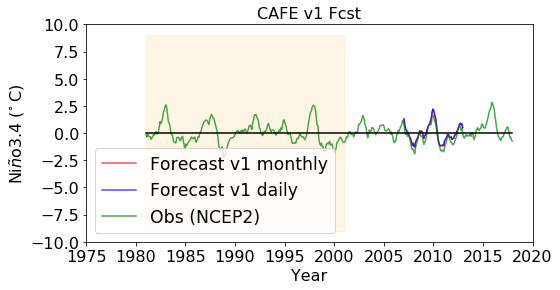

Diag= False
monthly_clim_anom: All years have 12 months.


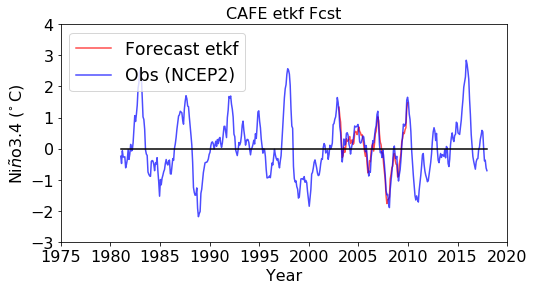

Diag= False
monthly_clim_anom: All years have 12 months.
Diag= False
monthly_clim_anom: All years have 12 months.


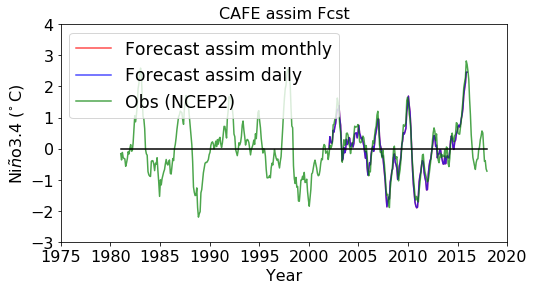

plotting...
Image saved to  panel1.pdf
Image saved to  panel2.pdf
Image saved to  panel3.pdf
Image saved to  panel4.pdf
Image saved to  panel5.pdf
Image saved to  panel6.pdf
Image saved to  panel7.pdf
END


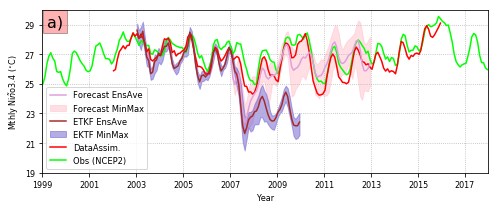

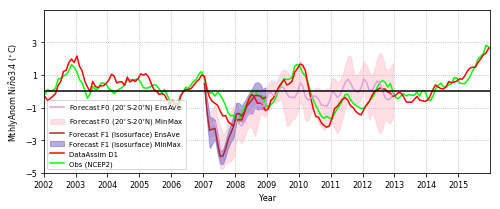

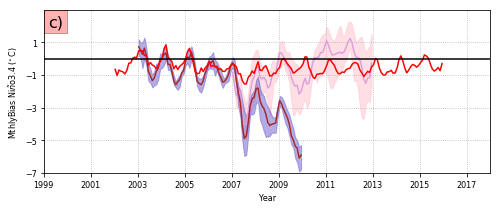

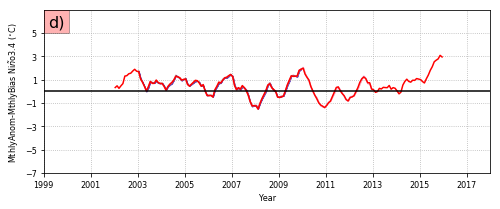

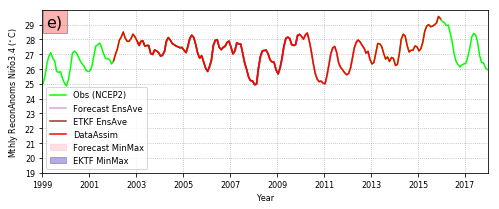

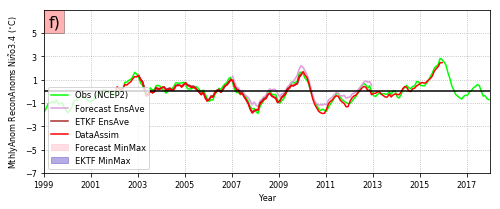

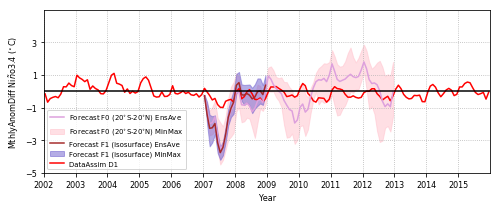

In [54]:
print('BEGIN')

import socket
import re
import os
import sys

print('sys.version=',sys.version)

hostname=socket.gethostname()

print('hostname=',hostname)

if(re.match('raijin',hostname)):
  print('this is rajin')
  rundir='/short/v14/mac599/cafepp/rundir'
  topdir=''
elif(re.match('oa-3.-cdc',hostname)):
  print('this is vm32')
  rundir='/OSM/CBR/OA_DCFP/work/col414/cafepp'
  topdir='/OSM/CBR/OA_DCFP/data/CAFEPP/CMIP6'
  topdir='/OSM/CBR/OA_DCFP/work/col414/CAFEPP/CMIP6'
  topdir_ncep='/OSM/CBR/OA_DCFP/data/CAFEPP/'
else:
  raise SystemExit('host not known:'+__file__+' line number: '+str(inspect.stack()[0][2]))

os.chdir(rundir)

os.chdir('/OSM/CBR/OA_DCFP/work/col414/cafepp')

print('Current Working Directory=',os.getcwd())

Clobber=False
Clobber=True

output_name='cafe_eg12.pkl'
input_name=output_name

output_type='pdf'
#output_type='png'

title=True
title=False #turn off title across whole set.

###

if(Clobber):

  print(CRED+'overwriting output PKL file '+output_name+' and regenerating...'+CEND)
    
  nino_indice_labels=ncepr2_nino_indices.indices_label
    
  ncepr2_year_fraction_from_daily=ncepr2_file_var_from_daily.year_fraction_anomaly
  ncepr2_year_fraction_from_monthly=ncepr2_file_var_from_monthly.year_fraction_anomaly
  hadisst_year_fraction_from_monthly=hadisst_file_var.year_fraction_anomaly
  cafe_assim_year_fraction_from_daily=cafe_daily_files_assim.year_fraction_anomaly
  cafe_assim_year_fraction_from_monthly=cafe_monthly_files_assim.year_fraction_anomaly
  cafe_v3_year_fraction_from_daily=cafe_daily_files_v3.year_fraction_anomaly
  cafe_v3_year_fraction_from_monthly=cafe_monthly_files_v3.year_fraction_anomaly
  cafe_v1_year_fraction_from_daily=cafe_daily_files_v1.year_fraction_anomaly
  cafe_v1_year_fraction_from_monthly=cafe_monthly_files_v1.year_fraction_anomaly
  cafe_etkf_year_fraction_from_daily=cafe_daily_files_etkf.year_fraction_anomaly
  
  ncepr2_date_time_stamp_anomaly_from_daily = ncepr2_file_var_from_daily.date_time_stamp_anomaly
  ncepr2_date_time_stamp_anomaly_from_monthly = ncepr2_file_var_from_monthly.date_time_stamp_anomaly
  hadisst_date_time_stamp_anomaly_from_monthly = hadisst_file_var.date_time_stamp_anomaly
  cafe_v3_date_time_stamp_anomaly_from_daily = cafe_daily_files_v3.date_time_stamp_anomaly
  cafe_v3_date_time_stamp_anomaly_from_monthly = cafe_monthly_files_v3.date_time_stamp_anomaly
  cafe_v1_date_time_stamp_anomaly_from_daily = cafe_daily_files_v1.date_time_stamp_anomaly
  cafe_v1_date_time_stamp_anomaly_from_monthly = cafe_monthly_files_v1.date_time_stamp_anomaly
  cafe_etkf_date_time_stamp_anomaly_from_daily = cafe_daily_files_etkf.date_time_stamp_anomaly
  cafe_assim_date_time_stamp_anomaly_from_daily = cafe_daily_files_assim.date_time_stamp_anomaly
  cafe_assim_date_time_stamp_anomaly_from_monthly = cafe_monthly_files_assim.date_time_stamp_anomaly
  
#   print(ncepr2_file_var_from_daily.num_stamp_anomaly)
#   print(cafe_daily_files_v1.num_stamp_anomaly)
  
#   print(len(cafe_monthly_files_v1.num_stamp_anomaly))
#   print(type(cafe_monthly_files_v1.num_stamp_anomaly))
  
#   print(cafe_monthly_files_v1.num_stamp_anomaly)
#   print(cafe_monthly_files_v1.num_stamp_anomaly[0][:])
  
  ncepr2_num_stamp_anomaly_from_daily = ncepr2_file_var_from_daily.num_stamp_anomaly
  ncepr2_num_stamp_anomaly_from_monthly = ncepr2_file_var_from_monthly.num_stamp_anomaly
  hadisst_num_stamp_anomaly_from_monthly = hadisst_file_var.num_stamp_anomaly
  cafe_v3_num_stamp_anomaly_from_daily = cafe_daily_files_v3.num_stamp_anomaly
  cafe_v3_num_stamp_anomaly_from_monthly = cafe_monthly_files_v3.num_stamp_anomaly[0][:]
  cafe_v1_num_stamp_anomaly_from_daily = cafe_daily_files_v1.num_stamp_anomaly
  cafe_v1_num_stamp_anomaly_from_monthly = cafe_monthly_files_v1.num_stamp_anomaly[0][:]
  cafe_etkf_num_stamp_anomaly_from_daily = cafe_daily_files_etkf.num_stamp_anomaly
  cafe_assim_num_stamp_anomaly_from_daily = cafe_daily_files_assim.num_stamp_anomaly
  cafe_assim_num_stamp_anomaly_from_monthly = cafe_monthly_files_assim.num_stamp_anomaly
    
  #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

  ncepr2_nfiles_from_daily = ncepr2_file_var_from_daily.nfiles
  ncepr2_nfiles_from_monthly = ncepr2_file_var_from_monthly.nfiles
  hadisst_nfiles_from_monthly = hadisst_file_var.nfiles
  cafe_v3_nfiles_from_daily = cafe_daily_files_v3.nfiles
  cafe_v3_nfiles_from_monthly = cafe_monthly_files_v3.nfiles
  cafe_v1_nfiles_from_daily = cafe_daily_files_v1.nfiles
  cafe_v1_nfiles_from_monthly = cafe_monthly_files_v1.nfiles
  cafe_etkf_nfiles_from_daily = cafe_daily_files_etkf.nfiles
  cafe_assim_nfiles_from_daily = cafe_daily_files_assim.nfiles
  cafe_assim_nfiles_from_monthly = cafe_monthly_files_assim.nfiles

  ncepr2_nindices_nino = ncepr2_nino_indices.nindices_nino
  hadisst_nindices_nino = hadisst_nino_indices.nindices_nino
  cafe_v3_nindices_nino = cafe_v3_nino_indices.nindices_nino
  cafe_v1_nindices_nino = cafe_v1_nino_indices.nindices_nino
  cafe_etkf_nindices_nino = cafe_etkf_nino_indices.nindices_nino
  cafe_assim_nindices_nino = cafe_assim_nino_indices.nindices_nino
    
  ncepr2_nindices_label = ncepr2_nino_indices.indices_label
  hadisst_nindices_label = hadisst_nino_indices.indices_label
  cafe_v3_nindices_label = cafe_v3_nino_indices.indices_label
  cafe_v1_nindices_label = cafe_v1_nino_indices.indices_label
  cafe_etkf_nindices_label = cafe_etkf_nino_indices.indices_label
  cafe_assim_nindices_label = cafe_assim_nino_indices.indices_label

  ncepr2_date_time_stamp_from_daily=ncepr2_file_var_from_daily.date_time_stamp_monthly
  ncepr2_date_time_stamp_from_monthly=ncepr2_file_var_from_monthly.date_time_stamp_tfreq
  hadiist_date_time_stamp_from_monthly=hadisst_file_var.date_time_stamp_tfreq
  cafe_v3_date_time_stamp_from_daily=cafe_daily_files_v3.date_time_stamp_monthly
  cafe_v3_date_time_stamp_from_monthly=cafe_monthly_files_v3.date_time_stamp_tfreq
  cafe_v1_date_time_stamp_from_daily=cafe_daily_files_v1.date_time_stamp_monthly
  cafe_v1_date_time_stamp_from_monthly=cafe_monthly_files_v1.date_time_stamp_tfreq
  cafe_etkf_date_time_stamp_from_daily=cafe_daily_files_etkf.date_time_stamp_monthly
  cafe_assim_date_time_stamp_from_daily=cafe_daily_files_assim.date_time_stamp_monthly
  cafe_assim_date_time_stamp_from_monthly=cafe_monthly_files_assim.date_time_stamp_tfreq
  
  ncepr2_time_tfreq_units_from_daily=ncepr2_file_var_from_daily.time_tfreq_units 
  ncepr2_time_tfreq_units_from_monthly=ncepr2_file_var_from_monthly.time_tfreq_units
  hadisst_time_tfreq_units_from_monthly=hadisst_file_var.time_tfreq_units
  cafe_v3_time_tfreq_units_from_daily=cafe_daily_files_v3.time_tfreq_units
  cafe_v3_time_tfreq_units_from_monthly=cafe_monthly_files_v3.time_tfreq_units  
  cafe_v1_time_tfreq_units_from_daily=cafe_daily_files_v1.time_tfreq_units
  cafe_v1_time_tfreq_units_from_monthly=cafe_monthly_files_v1.time_tfreq_units  
  cafe_etkf_time_tfreq_units_from_daily=cafe_daily_files_etkf.time_tfreq_units    
  cafe_assim_time_tfreq_units_from_daily=cafe_daily_files_assim.time_tfreq_units  
  cafe_assim_time_tfreq_units_from_monthly=cafe_monthly_files_assim.time_tfreq_units  

  ncepr2_time_tfreq_calendar_from_daily=ncepr2_file_var_from_daily.time_tfreq_calendar
  ncepr2_time_tfreq_calendar_from_monthly=ncepr2_file_var_from_monthly.time_tfreq_calendar
  hadisst_time_tfreq_calendar_from_monthly=hadisst_file_var.time_tfreq_calendar
  cafe_v3_time_tfreq_calendar_from_daily=cafe_daily_files_v3.time_tfreq_calendar 
  cafe_v3_time_tfreq_calendar_from_monthly=cafe_monthly_files_v3.time_tfreq_calendar  
  cafe_v1_time_tfreq_calendar_from_daily=cafe_daily_files_v1.time_tfreq_calendar  
  cafe_v1_time_tfreq_calendar_from_monthly=cafe_monthly_files_v1.time_tfreq_calendar  
  cafe_etkf_time_tfreq_calendar_from_daily=cafe_daily_files_etkf.time_tfreq_calendar    
  cafe_assim_time_tfreq_calendar_from_daily=cafe_daily_files_assim.time_tfreq_calendar  
  cafe_assim_time_tfreq_calendar_from_monthly=cafe_monthly_files_assim.time_tfreq_calendar  
  
  #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

  pkl_objects=( \
    nino_indice_labels, \
    \
    ncepr2_nino_monthly_from_daily, \
    ncepr2_nino_monthly_from_monthly, \
    hadisst_nino_monthly, \
    cafe_nino_monthly_from_daily_v3, \
    cafe_nino_monthly_from_monthly_v3, \
    cafe_nino_monthly_from_daily_v1, \
    cafe_nino_monthly_from_monthly_v1, \
    cafe_nino_monthly_from_daily_etkf, \
    cafe_nino_monthly_from_daily_assim, \
    cafe_nino_monthly_from_monthly_assim, \
    \
    ncepr2_nino_monthlyanomaly_from_daily, \
    ncepr2_nino_monthlyanomaly_from_monthly, \
    hadisst_nino_monthlyanomaly, \
    cafe_nino_monthlyanomaly_from_daily_v3, \
    cafe_nino_monthlyanomaly_from_monthly_v3, \
    cafe_nino_monthlyanomaly_from_daily_v1, \
    cafe_nino_monthlyanomaly_from_monthly_v1, \
    cafe_nino_monthlyanomaly_from_daily_etkf, \
    cafe_nino_monthlyanomaly_from_daily_assim, \
    cafe_nino_monthlyanomaly_from_monthly_assim, \
    \
    ncepr2_year_fraction_from_daily, \
    ncepr2_year_fraction_from_monthly, \
    hadisst_year_fraction_from_monthly, \
    cafe_v3_year_fraction_from_daily, \
    cafe_v3_year_fraction_from_monthly, \
    cafe_v1_year_fraction_from_daily, \
    cafe_v1_year_fraction_from_monthly, \
    cafe_etkf_year_fraction_from_daily, \
    cafe_assim_year_fraction_from_daily, \
    cafe_assim_year_fraction_from_monthly, \
    \
    ncepr2_date_time_stamp_anomaly_from_daily, \
    ncepr2_date_time_stamp_anomaly_from_monthly, \
    hadisst_date_time_stamp_anomaly_from_monthly, \
    cafe_v3_date_time_stamp_anomaly_from_daily, \
    cafe_v3_date_time_stamp_anomaly_from_monthly, \
    cafe_v1_date_time_stamp_anomaly_from_daily, \
    cafe_v1_date_time_stamp_anomaly_from_monthly, \
    cafe_etkf_date_time_stamp_anomaly_from_daily, \
    cafe_assim_date_time_stamp_anomaly_from_daily, \
    cafe_assim_date_time_stamp_anomaly_from_monthly, \
    \
    ncepr2_num_stamp_anomaly_from_daily, \
    ncepr2_num_stamp_anomaly_from_monthly, \
    hadisst_num_stamp_anomaly_from_monthly, \
    cafe_v3_num_stamp_anomaly_from_daily, \
    cafe_v3_num_stamp_anomaly_from_monthly, \
    cafe_v1_num_stamp_anomaly_from_daily, \
    cafe_v1_num_stamp_anomaly_from_monthly, \
    cafe_etkf_num_stamp_anomaly_from_daily, \
    cafe_assim_num_stamp_anomaly_from_daily, \
    cafe_assim_num_stamp_anomaly_from_monthly, \
    \
    ncepr2_nfiles_from_daily, \
    ncepr2_nfiles_from_monthly, \
    hadisst_nfiles_from_monthly, \
    cafe_v3_nfiles_from_daily, \
    cafe_v3_nfiles_from_monthly, \
    cafe_v1_nfiles_from_daily, \
    cafe_v1_nfiles_from_monthly, \
    cafe_etkf_nfiles_from_daily, \
    cafe_assim_nfiles_from_daily, \
    cafe_assim_nfiles_from_monthly, \
    \
    ncepr2_nindices_nino, \
    hadisst_nindices_nino, \
    cafe_v3_nindices_nino, \
    cafe_v1_nindices_nino, \
    cafe_etkf_nindices_nino, \
    cafe_assim_nindices_nino, \
    \
    ncepr2_nindices_label, \
    hadisst_nindices_label, \
    cafe_v3_nindices_label, \
    cafe_v1_nindices_label, \
    cafe_etkf_nindices_label, \
    cafe_assim_nindices_label, \
    \
    ncepr2_date_time_stamp_from_daily, \
    ncepr2_date_time_stamp_from_monthly, \
    hadiist_date_time_stamp_from_monthly, \
    cafe_v3_date_time_stamp_from_daily, \
    cafe_v3_date_time_stamp_from_monthly, \
    cafe_v1_date_time_stamp_from_daily, \
    cafe_v1_date_time_stamp_from_monthly, \
    cafe_etkf_date_time_stamp_from_daily, \
    cafe_assim_date_time_stamp_from_daily, \
    cafe_assim_date_time_stamp_from_monthly, \
    \
    ncepr2_time_tfreq_units_from_daily, \
    ncepr2_time_tfreq_units_from_monthly, \
    hadisst_time_tfreq_units_from_monthly, \
    cafe_v3_time_tfreq_units_from_daily, \
    cafe_v3_time_tfreq_units_from_monthly, \
    cafe_v1_time_tfreq_units_from_daily, \
    cafe_v1_time_tfreq_units_from_monthly, \
    cafe_etkf_time_tfreq_units_from_daily, \
    cafe_assim_time_tfreq_units_from_daily, \
    cafe_assim_time_tfreq_units_from_monthly, \
    \
    ncepr2_time_tfreq_calendar_from_daily, \
    ncepr2_time_tfreq_calendar_from_monthly, \
    hadisst_time_tfreq_calendar_from_monthly, \
    cafe_v3_time_tfreq_calendar_from_daily, \
    cafe_v3_time_tfreq_calendar_from_monthly, \
    cafe_v1_time_tfreq_calendar_from_daily, \
    cafe_v1_time_tfreq_calendar_from_monthly, \
    cafe_etkf_time_tfreq_calendar_from_daily, \
    cafe_assim_time_tfreq_calendar_from_daily, \
    cafe_assim_time_tfreq_calendar_from_monthly \
    )
  
  #print('len(pkl_objects)=',len(pkl_objects))
  
  if(os.path.exists(output_name)):
    print(CRED+'Pkl file exists and deleting...'+CEND)
    os.remove(output_name)

# print('opening & write & close normal')
# pickling_out = open(output_name, 'wb')
# pickle.dump(pkl_objects, pickling_out)
# pickling_out.close()

  print('opening & write & close small')
  pickling_out = bz2.BZ2File(output_name, 'wb')
  pickle.dump(pkl_objects, pickling_out)
  pickling_out.close()

#raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))
  
if(os.path.exists(output_name) and not Clobber):
  print(CRED+'Pkl file '+output_name+' exists and keeping...'+CEND)
    
print(CRED+'Pkl read from new or existing '+input_name+' ...create different output names compared to input...'+CEND)
if(os.path.exists(input_name)):
  pickling_in = bz2.BZ2File(input_name, "rb")
  nino_indice_labels, \
    ncepr2_mondata_from_daily, ncepr2_mondata_from_monthly, hadisst_mondata_from_monthly, cafe_v3_mondata_from_daily, cafe_v3_mondata_from_monthly, cafe_v1_mondata_from_daily, cafe_v1_mondata_from_monthly, cafe_etkf_mondata_from_daily, cafe_assim_mondata_from_daily, cafe_assim_mondata_from_monthly, \
    \
    ncepr2_anomdata_from_daily, ncepr2_anomdata_from_monthly, hadisst_anomdata_from_monthly, cafe_v3_anomdata_from_daily, cafe_v3_anomdata_from_monthly, cafe_v1_anomdata_from_daily, cafe_v1_anomdata_from_monthly, cafe_etkf_anomdata_from_daily, cafe_assim_anomdata_from_daily, cafe_assim_anomdata_from_monthly, \
    \
    ncepr2_time_from_daily, ncepr2_time_from_monthly, hadisst_time_from_monthly, cafe_v3_time_from_daily, cafe_v3_time_from_monthly, cafe_v1_time_from_daily, cafe_v1_time_from_monthly, cafe_etkf_time_from_daily, cafe_assim_time_from_daily, cafe_assim_time_from_monthly, \
    \
    ncepr2_stamp_anomaly_from_daily, ncepr2_stamp_anomaly_from_monthly, hadisst_stamp_anomaly_from_monthly, cafe_v3_stamp_anomaly_from_daily, cafe_v3_stamp_anomaly_from_monthly, cafe_v1_stamp_anomaly_from_daily, cafe_v1_stamp_anomaly_from_monthly, cafe_etkf_stamp_anomaly_from_daily, cafe_assim_stamp_anomaly_from_daily, cafe_assim_stamp_anomaly_from_monthly, \
    \
    ncepr2_num_stamp_anomaly_from_daily, ncepr2_num_stamp_anomaly_from_monthly, hadisst_num_stamp_anomaly_from_monthly, cafe_v3_num_stamp_anomaly_from_daily, cafe_v3_num_stamp_anomaly_from_monthly, cafe_v1_num_stamp_anomaly_from_daily, cafe_v1_num_stamp_anomaly_from_monthly, cafe_etkf_num_stamp_anomaly_from_daily, cafe_assim_num_stamp_anomaly_from_daily, cafe_assim_num_stamp_anomaly_from_monthly, \
    \
    ncepr2_nfil_from_daily, ncepr2_nfil_from_monthly, hadiist_nfil_from_monthly, cafe_v3_nfil_from_daily, cafe_v3_nfil_from_monthly, cafe_v1_nfil_from_daily, cafe_v1_nfil_from_monthly, cafe_etkf_nfil_from_daily, cafe_assim_nfil_from_daily, cafe_assim_nfil_from_monthly, \
    \
    ncepr2_nind, hadiist_nind, cafe_v3_nind, cafe_v1_nind, cafe_etkf_nind, cafe_assim_nind, \
    \
    ncepr2_labs, hadiist_labs, cafe_v3_labs, cafe_v1_labs, cafe_etkf_labs, cafe_assim_labs, \
    \
    ncepr2_stamp_from_daily, ncepr2_stamp_from_monthly, hadiist_stamp_from_monthly, cafe_v3_stamp_from_daily, cafe_v3_stamp_from_monthly, cafe_v1_stamp_from_daily, cafe_v1_stamp_from_monthly, cafe_etkf_stamp_from_daily, cafe_assim_stamp_from_daily, cafe_assim_stamp_from_monthly, \
    \
    ncepr2_time_units_from_daily, ncepr2_time_units_from_monthly, hadisst_time_units_from_monthly, cafe_v3_time_units_from_daily, cafe_v3_time_units_from_monthly, cafe_v1_time_units_from_daily, cafe_v1_time_units_from_monthly, cafe_etkf_time_units_from_daily, cafe_assim_time_units_from_monthly, cafe_assim_time_units_from_daily, \
    \
    ncepr2_time_calendar_from_daily, ncepr2_time_calendar_from_monthly, hadisst_time_calendar_from_monthly, cafe_v3_time_calendar_from_daily, cafe_v3_time_calendar_from_monthly, cafe_v1_time_calendar_from_daily, cafe_v1_time_calendar_from_monthly,  cafe_etkf_time_calendar_from_daily, cafe_assim_time_calendar_from_daily, cafe_assim_time_calendar_from_monthly \
    = pickle.load(pickling_in)
  pickling_in.close()  
  
  #cafe_v1_time_data_from_daily
  #cafe_etkf_time_calendar_from_daily
  
print(CRED+'aligning model and observational times...'+CEND)

ncepr2_years_months_from_daily=[]
for cnt in range(ncepr2_stamp_anomaly_from_daily.size):
  ncepr2_years_months_from_daily.append(ncepr2_stamp_anomaly_from_daily[cnt].year*100+ncepr2_stamp_anomaly_from_daily[cnt].month)

ncepr2_years_months_from_monthly=[]
for cnt in range(ncepr2_stamp_anomaly_from_monthly.size):
  ncepr2_years_months_from_monthly.append(ncepr2_stamp_anomaly_from_monthly[cnt].year*100+ncepr2_stamp_anomaly_from_monthly[cnt].month)

cafe_assim_year_month1_from_daily=cafe_assim_stamp_from_daily[0].year*100+cafe_assim_stamp_from_daily[0].month
cafe_assim_year_monthN_from_daily=cafe_assim_stamp_from_daily[-1].year*100+cafe_assim_stamp_from_daily[-1].month

cafe_assim_year_month1_from_monthly=cafe_assim_stamp_from_monthly[0].year*100+cafe_assim_stamp_from_daily[0].month
cafe_assim_year_monthN_from_monthly=cafe_assim_stamp_from_monthly[-1].year*100+cafe_assim_stamp_from_daily[-1].month

cafe_v3_year_month1_from_daily=cafe_v3_stamp_from_daily[0].year*100+cafe_v3_stamp_from_daily[0].month
cafe_v3_year_monthN_from_daily=cafe_v3_stamp_from_daily[-1].year*100+cafe_v3_stamp_from_daily[-1].month

cafe_v3_year_month1_from_monthly=cafe_v3_stamp_from_monthly[0][0].year*100+cafe_v3_stamp_from_monthly[0][0].month
cafe_v3_year_monthN_from_monthly=cafe_v3_stamp_from_monthly[0][-1].year*100+cafe_v3_stamp_from_monthly[0][-1].month

cafe_v1_year_month1_from_daily=cafe_v1_stamp_from_daily[0].year*100+cafe_v1_stamp_from_daily[0].month
cafe_v1_year_monthN_from_daily=cafe_v1_stamp_from_daily[-1].year*100+cafe_v1_stamp_from_daily[-1].month

cafe_v1_year_month1_from_monthly=cafe_v1_stamp_from_monthly[0][0].year*100+cafe_v1_stamp_from_monthly[0][0].month
cafe_v1_year_monthN_from_monthly=cafe_v1_stamp_from_monthly[0][-1].year*100+cafe_v1_stamp_from_monthly[0][-1].month

cafe_etkf_year_monthN=cafe_etkf_stamp_from_daily[-1].year*100+cafe_etkf_stamp_from_daily[-1].month
cafe_etkf_year_month1=cafe_etkf_stamp_from_daily[0].year*100+cafe_etkf_stamp_from_daily[0].month

cafe_assim_first_index_from_daily=ncepr2_years_months_from_daily.index(cafe_assim_year_month1_from_daily)
cafe_assim_last_index_from_daily=ncepr2_years_months_from_daily.index(cafe_assim_year_monthN_from_daily)

cafe_assim_first_index_from_monthly=ncepr2_years_months_from_monthly.index(cafe_assim_year_month1_from_monthly)
cafe_assim_last_index_from_monthly=ncepr2_years_months_from_monthly.index(cafe_assim_year_monthN_from_monthly)

cafe_v3_first_index_from_daily=ncepr2_years_months_from_daily.index(cafe_v3_year_month1_from_monthly)
cafe_v3_last_index_from_daily=ncepr2_years_months_from_daily.index(cafe_v3_year_monthN_from_monthly)

cafe_v3_first_index_from_monthly=ncepr2_years_months_from_monthly.index(cafe_v3_year_month1_from_monthly)
cafe_v3_last_index_from_monthly=ncepr2_years_months_from_monthly.index(cafe_v3_year_monthN_from_monthly)

cafe_v1_first_index_from_daily=ncepr2_years_months_from_daily.index(cafe_v1_year_month1_from_monthly)
cafe_v1_last_index_from_daily=ncepr2_years_months_from_daily.index(cafe_v1_year_monthN_from_monthly)

cafe_v1_first_index_from_monthly=ncepr2_years_months_from_monthly.index(cafe_v1_year_month1_from_monthly)
cafe_v1_last_index_from_monthly=ncepr2_years_months_from_monthly.index(cafe_v1_year_monthN_from_monthly)

cafe_etkf_first_index=ncepr2_years_months_from_daily.index(cafe_etkf_year_month1)
cafe_etkf_last_index=ncepr2_years_months_from_daily.index(cafe_etkf_year_monthN)
  
#print('cafe_v1_first_index_from_daily,cafe_v1_last_index_from_daily=',cafe_v1_first_index_from_daily,cafe_v1_last_index_from_daily)
#print('cafe_v1_first_index_from_monthly,cafe_v1_last_index_from_monthly=',cafe_v1_first_index_from_monthly,cafe_v1_last_index_from_monthly)

#print(ncepr2_time[cafe_assim_first_index:cafe_assim_last_index+1])

#raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

#===============================================================================

print(CRED+'generating daily/monthly bias...'+CEND)

cafe_v3_bias_data_from_daily = ma.zeros((cafe_v3_last_index_from_daily-cafe_v3_first_index_from_daily+1, cafe_v3_nfil_from_daily, cafe_v1_nind),\
  dtype='f')
cafe_v3_bias_data_from_monthly = ma.zeros((cafe_v3_last_index_from_monthly-cafe_v3_first_index_from_monthly+1, cafe_v3_nfil_from_monthly, cafe_v3_nind),\
  dtype='f')
for enow in range(max_ensemble+0):
  cafe_v3_bias_data_from_monthly[:,enow,:] = cafe_v3_mondata_from_monthly[:,enow,:] - ncepr2_mondata_from_monthly[cafe_v3_first_index_from_monthly:cafe_v3_last_index_from_monthly+1,:]
cafe_v3_time_data_from_daily = ncepr2_time_from_daily[cafe_v3_first_index_from_daily:cafe_v3_last_index_from_daily+1]
cafe_v3_time_data_from_monthly = ncepr2_time_from_monthly[cafe_v3_first_index_from_monthly:cafe_v3_last_index_from_monthly+1]

cafe_v1_bias_data_from_daily = ma.zeros((cafe_v1_last_index_from_daily-cafe_v1_first_index_from_daily+1, cafe_v1_nfil_from_daily, cafe_v1_nind),\
  dtype='f')
cafe_v1_bias_data_from_monthly = ma.zeros((cafe_v1_last_index_from_monthly-cafe_v1_first_index_from_monthly+1, cafe_v1_nfil_from_monthly, cafe_v1_nind),\
  dtype='f')
for enow in range(max_ensemble+0):
  cafe_v1_bias_data_from_daily[:,enow,:] = cafe_v1_mondata_from_daily[:,enow,:] - ncepr2_mondata_from_daily[cafe_v1_first_index_from_daily:cafe_v1_last_index_from_daily+1,:]
  cafe_v1_bias_data_from_monthly[:,enow,:] = cafe_v1_mondata_from_monthly[:,enow,:] - ncepr2_mondata_from_monthly[cafe_v1_first_index_from_monthly:cafe_v1_last_index_from_monthly+1,:]
cafe_v1_time_data_from_daily = ncepr2_time_from_daily[cafe_v1_first_index_from_daily:cafe_v1_last_index_from_daily+1]
cafe_v1_time_data_from_monthly = ncepr2_time_from_monthly[cafe_v1_first_index_from_monthly:cafe_v1_last_index_from_monthly+1]

cafe_etkf_bias_data_from_daily = ma.zeros((cafe_etkf_last_index-cafe_etkf_first_index+1, cafe_etkf_nfil_from_daily, cafe_etkf_nind),\
  dtype='f')
for enow in range(max_ensemble+0):
  cafe_etkf_bias_data_from_daily[:,enow,:] = cafe_etkf_mondata_from_daily[:,enow,:] - ncepr2_mondata_from_daily[cafe_etkf_first_index:cafe_etkf_last_index+1,:]
cafe_etkf_time_data = ncepr2_time_from_daily[cafe_etkf_first_index:cafe_etkf_last_index+1]
cafe_assim_bias_data_from_daily = cafe_assim_mondata_from_daily - ncepr2_mondata_from_daily[cafe_assim_first_index_from_daily:cafe_assim_last_index_from_daily+1,:]
cafe_assim_bias_data_from_monthly = cafe_assim_mondata_from_monthly - ncepr2_mondata_from_monthly[cafe_assim_first_index_from_monthly:cafe_assim_last_index_from_monthly+1,:]
cafe_assim_time_data_from_daily = ncepr2_time_from_daily[cafe_assim_first_index_from_daily:cafe_assim_last_index_from_daily+1]
cafe_assim_time_data_from_monthly = ncepr2_time_from_monthly[cafe_assim_first_index_from_monthly:cafe_assim_last_index_from_monthly+1]

#===============================================================================

print(CRED+'generating anom MINUS daily/monthly bias...'+CEND)

cafe_v3_anomMbias_data_from_daily = ma.zeros((cafe_v3_last_index_from_daily-cafe_v3_first_index_from_daily+1, cafe_v3_nfil_from_daily, cafe_v3_nind),\
  dtype='f')
cafe_v3_anomMbias_data_from_monthly = ma.zeros((cafe_v3_last_index_from_monthly-cafe_v3_first_index_from_monthly+1, cafe_v3_nfil_from_monthly, cafe_v3_nind),\
  dtype='f')
for enow in range(max_ensemble+0):
  cafe_v3_anomMbias_data_from_daily[:,enow,:] = cafe_v3_anomdata_from_daily[:,enow,:] - (cafe_v3_mondata_from_daily[:,enow,:] - ncepr2_mondata_from_daily[cafe_v3_first_index_from_daily:cafe_v3_last_index_from_daily+1,:])
  cafe_v3_anomMbias_data_from_monthly[:,enow,:] = cafe_v3_anomdata_from_monthly[:,enow,:] - (cafe_v3_mondata_from_monthly[:,enow,:] - ncepr2_mondata_from_monthly[cafe_v3_first_index_from_monthly:cafe_v3_last_index_from_monthly+1,:])

cafe_v1_anomMbias_data_from_daily = ma.zeros((cafe_v1_last_index_from_daily-cafe_v1_first_index_from_daily+1, cafe_v1_nfil_from_daily, cafe_v1_nind),\
  dtype='f')
cafe_v1_anomMbias_data_from_monthly = ma.zeros((cafe_v1_last_index_from_monthly-cafe_v1_first_index_from_monthly+1, cafe_v1_nfil_from_monthly, cafe_v1_nind),\
  dtype='f')
for enow in range(max_ensemble+0):
  cafe_v1_anomMbias_data_from_daily[:,enow,:] = cafe_v1_anomdata_from_daily[:,enow,:] - (cafe_v1_mondata_from_daily[:,enow,:] - ncepr2_mondata_from_daily[cafe_v1_first_index_from_daily:cafe_v1_last_index_from_daily+1,:])
  cafe_v1_anomMbias_data_from_monthly[:,enow,:] = cafe_v1_anomdata_from_monthly[:,enow,:] - (cafe_v1_mondata_from_monthly[:,enow,:] - ncepr2_mondata_from_monthly[cafe_v1_first_index_from_monthly:cafe_v1_last_index_from_monthly+1,:])

cafe_etkf_anomMbias_data = ma.zeros((cafe_etkf_last_index-cafe_etkf_first_index+1, cafe_etkf_nfil_from_daily, cafe_etkf_nind),\
  dtype='f')
for enow in range(max_ensemble+0):
  print('enow=',enow)
  cafe_etkf_anomMbias_data[:,enow,:] = cafe_etkf_anomdata_from_daily[:,enow,:] - (cafe_etkf_mondata_from_daily[:,enow,:] - ncepr2_mondata_from_daily[cafe_etkf_first_index:cafe_etkf_last_index+1,:])
cafe_assim_anomMbias_data_from_daily = cafe_assim_anomdata_from_daily[:,:] - (cafe_assim_mondata_from_daily[:,:] - ncepr2_mondata_from_daily[cafe_assim_first_index_from_daily:cafe_assim_last_index_from_daily+1,:])
cafe_assim_anomMbias_data_from_monthly = cafe_assim_anomdata_from_monthly[:,:] - (cafe_assim_mondata_from_monthly[:,:] - ncepr2_mondata_from_monthly[cafe_assim_first_index_from_monthly:cafe_assim_last_index_from_monthly+1,:])

# anom minus bias = mod_mon - mod_clim,n + ncep_mon - mod_mon = ncep_mon - mod_clim,n: n is repeating monthly clim for every year n.
#===============================================================================

print(CRED+'reconstructing model data from daily/monthly data and bias...'+CEND)

cafe_v3_reconstructed_from_daily = cafe_v3_mondata_from_daily - cafe_v3_bias_data_from_daily
cafe_v3_reconstructed_from_monthly = cafe_v3_mondata_from_monthly - cafe_v3_bias_data_from_monthly
cafe_v1_reconstructed_from_daily = cafe_v1_mondata_from_daily - cafe_v1_bias_data_from_daily
cafe_v1_reconstructed_from_monthly = cafe_v1_mondata_from_monthly - cafe_v1_bias_data_from_monthly
cafe_etkf_reconstructed_from_daily = cafe_etkf_mondata_from_daily - cafe_etkf_bias_data_from_daily
cafe_assim_reconstructed_from_daily = cafe_assim_mondata_from_daily - cafe_assim_bias_data_from_daily
cafe_assim_reconstructed_from_monthly = cafe_assim_mondata_from_monthly - cafe_assim_bias_data_from_monthly

# reconstructed = mod_mon - mod_mon - ncep_mon = ncep_mon

#===============================================================================

# input_datas=(ncepr2_mondata[:,nino_index_k],)
# input_xvals=(ncepr2_time,)

# input_datas = input_datas + (cafe_assim_reconstructed[:,nino_index_k],)
# input_xvals = input_xvals + (cafe_assim_time_data,)

# plot_xy(Diag=False,input_data=input_datas,input_xvals=input_xvals, \
#   title='CAFE Fcst', \
#   units='$\!^\circ$C', \
#   xlab='Year', \
#   ylab=cafe_etkf_nino_indices.indices_label[nino_index_k]+' ('+'$\!^\circ$C'+')', \
#   zero2=True, \
#   reverse_xaxis=False, \
#   reverse_yaxis=False, \
#   line_colors=['red','blue'], \
#   line_labels=['Obs (NCEP2)','Assim'], \
#   legend_position='best', \
#   xysize=(10,5))

#===============================================================================

#This was old way of calculating anomalies, but I have modified n_data_funcs to have a 'dummy_mode'. This tricks it to doing monthly_clim_anom functionality by providing minimum of self.data objects.
#this old way was problematic, when PKLing, as needed to keep original n_data_funcs instances, which cannot be PKLed.

# cbeg=2007
# cend=2012
# abeg=2007
# aend=2012

# cafe_nino_monthlyclimatology_from_daily_v1_reconstructed,cafe_nino_monthlyanomaly_from_daily_v1_reconstructed=cafe_daily_files_v1.monthly_clim_anom( \
#     Diag=True, input=cafe_v1_reconstructed, AnnOut=False, ZeroClim=False, \
#     cbeg=cbeg, cend=cend, abeg=abeg, aend=aend)


# cbeg=2003
# cend=2009
# abeg=2003
# aend=2009
  
# cafe_nino_monthlyclimatology_from_daily_etkf_reconstructed,cafe_nino_monthlyanomaly_from_daily_etkf_reconstructed=cafe_daily_files_etkf.monthly_clim_anom( \
#     Diag=True, input=cafe_etkf_reconstructed, AnnOut=False, ZeroClim=False, \
#     cbeg=cbeg, cend=cend, abeg=abeg, aend=aend)

# input_datas=(ncepr2_nino_monthlyanomaly[:,nino_index_k],)
# input_xvals=(ncepr2_year_fraction,)

# input_datas = input_datas + (np.average(cafe_nino_monthlyanomaly_from_daily_v1_reconstructed[:,:,nino_index_k],axis=1),)
# input_xvals = input_xvals + (cafe_v1_time_data,)

# input_datas = input_datas + (np.average(cafe_nino_monthlyanomaly_from_daily_etkf_reconstructed[:,:,nino_index_k],axis=1),)
# input_xvals = input_xvals + (cafe_etkf_time_data,)

# plot_xy(Diag=False,input_data=input_datas,input_xvals=input_xvals, \
#   title='CAFE Fcst', \
#   units='$\!^\circ$C', \
#   xlab='Year', \
#   ylab=cafe_etkf_nino_indices.indices_label[nino_index_k]+' ('+'$\!^\circ$C'+')', \
#   zero2=True, \
#   reverse_xaxis=False, \
#   reverse_yaxis=False, \
#   line_colors=['red','blue','green'], \
#   line_labels=['Obs (NCEP2)','Forecast','ETKF'], \
#   legend_position='best', \
#   xysize=(10,5))

#===============================================================================

print(CRED+'generating model anomalies from reconstructed data...'+CEND)

#The new approach:

cbeg=2007
cend=2008
abeg=2007
aend=2008

test_v3_monthly = n_data_funcs(Diag=False, input_files=None, input_var_name=None, \
  dummy_mode=(False, cafe_v3_stamp_anomaly_from_monthly, cafe_v3_num_stamp_anomaly_from_monthly, \
  cafe_v3_time_units_from_monthly, cafe_v3_time_calendar_from_monthly)) #I think boolean for dummy_mode should be False but seems to work.

cafe_nino_monthlyclimatology_from_monthly_v3_reconstructed_test, cafe_nino_monthlyanomaly_from_monthly_v3_reconstructed_test= \
  test_v3_monthly.monthly_clim_anom( \
  Diag=False, input=cafe_v3_reconstructed_from_monthly, AnnOut=False, ZeroClim=False, \
  cbeg=cbeg, cend=cend, abeg=abeg, aend=aend)

test_v3_daily = n_data_funcs(Diag=False, input_files=None, input_var_name=None, \
  dummy_mode=(True, cafe_v3_stamp_anomaly_from_daily, cafe_v3_num_stamp_anomaly_from_daily, \
  cafe_v3_time_units_from_daily, cafe_v3_time_calendar_from_daily))

cafe_nino_monthlyclimatology_from_daily_v3_reconstructed_test, cafe_nino_monthlyanomaly_from_daily_v3_reconstructed_test= \
  test_v3_daily.monthly_clim_anom( \
  Diag=False, input=cafe_v3_reconstructed_from_daily, AnnOut=False, ZeroClim=False, \
  cbeg=cbeg, cend=cend, abeg=abeg, aend=aend)

#===============================================================================

cbeg=2007
cend=2012
abeg=2007
aend=2012

test_v1_monthly = n_data_funcs(Diag=False, input_files=None, input_var_name=None, \
  dummy_mode=(False, cafe_v1_stamp_anomaly_from_monthly, cafe_v1_num_stamp_anomaly_from_monthly, \
  cafe_v1_time_units_from_monthly, cafe_v1_time_calendar_from_monthly)) #I think boolean for dummy_mode should be False but seems to work.

cafe_nino_monthlyclimatology_from_monthly_v1_reconstructed_test, cafe_nino_monthlyanomaly_from_monthly_v1_reconstructed_test= \
  test_v1_monthly.monthly_clim_anom( \
  Diag=False, input=cafe_v1_reconstructed_from_monthly, AnnOut=False, ZeroClim=False, \
  cbeg=cbeg, cend=cend, abeg=abeg, aend=aend)

test_v1_daily = n_data_funcs(Diag=False, input_files=None, input_var_name=None, \
  dummy_mode=(True, cafe_v1_stamp_anomaly_from_daily, cafe_v1_num_stamp_anomaly_from_daily, \
  cafe_v1_time_units_from_daily, cafe_v1_time_calendar_from_daily))

cafe_nino_monthlyclimatology_from_daily_v1_reconstructed_test, cafe_nino_monthlyanomaly_from_daily_v1_reconstructed_test= \
  test_v1_daily.monthly_clim_anom( \
  Diag=False, input=cafe_v1_reconstructed_from_daily, AnnOut=False, ZeroClim=False, \
  cbeg=cbeg, cend=cend, abeg=abeg, aend=aend)

#raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

input_xvals = (cafe_v1_time_data_from_monthly,)
input_datas = (np.average(cafe_nino_monthlyanomaly_from_monthly_v1_reconstructed_test[:,:,nino_index_k],axis=1),)

input_xvals = input_xvals + (cafe_v1_time_data_from_daily,)
input_datas = input_datas + (np.average(cafe_nino_monthlyanomaly_from_daily_v1_reconstructed_test[:,1::,nino_index_k],axis=1),)

input_xvals = input_xvals + (ncepr2_time_from_monthly,)
input_datas = input_datas + (ncepr2_anomdata_from_monthly[:,nino_index_k],)

plot_xy(Diag=False,input_data=input_datas,input_xvals=input_xvals, \
  title='CAFE v1 Fcst', \
  units='$\!^\circ$C', \
  xlab='Year', \
  ylab=cafe_v1_labs[nino_index_k]+' ('+'$\!^\circ$C'+')', \
  zero2=True, \
  reverse_xaxis=False, \
  reverse_yaxis=False, \
  line_colors=['red','blue','green'], \
  line_labels=['Forecast v1 monthly','Forecast v1 daily','Obs (NCEP2)'], \
  legend_position='best', \
#  vertical_lines=([1980, 2005],[-10,5],['black','orange'],['--','--']), \
#  vertical_lines=([1980, 2005],['black','orange'],['--',':']), \
  ylim=[-10,10], \
  box_overlay=([[1981,2000+1,-5,5]],['orange'],[0.1]), \
#  box_overlay=([[1980,2005,-5,5],[2006,2008,-2,2]],['orange','yellow'],[0.1,0.1]), \
  xysize=(8,4))

#raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

#===============================================================================

cbeg=2003
cend=2009
abeg=2003
aend=2009

test_etkf_daily = n_data_funcs(Diag=False, input_files=None, input_var_name=None, \
  dummy_mode=(True, cafe_etkf_stamp_anomaly_from_daily, cafe_etkf_num_stamp_anomaly_from_daily, \
  cafe_etkf_time_units_from_daily, cafe_etkf_time_calendar_from_daily))

cafe_nino_monthlyclimatology_from_daily_etkf_reconstructed_test, cafe_nino_monthlyanomaly_from_daily_etkf_reconstructed_test= \
  test_etkf_daily.monthly_clim_anom( \
  Diag=False, input=cafe_etkf_reconstructed_from_daily, AnnOut=False, ZeroClim=False, \
  cbeg=cbeg, cend=cend, abeg=abeg, aend=aend)

input_xvals = (cafe_etkf_time_data,)
input_datas = (np.average(cafe_nino_monthlyanomaly_from_daily_etkf_reconstructed_test[:,1::,nino_index_k],axis=1),)

input_datas = input_datas + (ncepr2_anomdata_from_daily[:,nino_index_k],)
input_xvals = input_xvals + (ncepr2_time_from_daily,)

plot_xy(Diag=False,input_data=input_datas,input_xvals=input_xvals, \
  title='CAFE etkf Fcst', \
  units='$\!^\circ$C', \
  xlab='Year', \
  ylab=cafe_etkf_labs[nino_index_k]+' ('+'$\!^\circ$C'+')', \
  zero2=True, \
  reverse_xaxis=False, \
  reverse_yaxis=False, \
  line_colors=['red','blue'], \
  line_labels=['Forecast etkf','Obs (NCEP2)'], \
  legend_position='best', \
  xysize=(8,4))

#===============================================================================

cbeg=2002
cend=2015
abeg=2002
aend=2015

test_assim_monthly = n_data_funcs(Diag=False,input_files=None, input_var_name=None, \
  dummy_mode=(True, cafe_assim_stamp_anomaly_from_monthly, cafe_assim_num_stamp_anomaly_from_monthly, \
  cafe_assim_time_units_from_monthly, cafe_assim_time_calendar_from_monthly)) #I think boolean for dummy_mode should be False but seems to work.

cafe_nino_monthlyclimatology_from_monthly_assim_reconstructed_test, cafe_nino_monthlyanomaly_from_monthly_assim_reconstructed_test= \
  test_assim_monthly.monthly_clim_anom( \
  Diag=False, input=cafe_assim_reconstructed_from_monthly, AnnOut=False, ZeroClim=False, \
  cbeg=cbeg, cend=cend, abeg=abeg, aend=aend)

test_assim_daily = n_data_funcs(Diag=False,input_files=None, input_var_name=None, \
  dummy_mode=(True, cafe_assim_stamp_anomaly_from_daily, cafe_assim_num_stamp_anomaly_from_daily, \
  cafe_assim_time_units_from_monthly, cafe_assim_time_calendar_from_monthly))

cafe_nino_monthlyclimatology_from_daily_assim_reconstructed_test, cafe_nino_monthlyanomaly_from_daily_assim_reconstructed_test= \
  test_assim_daily.monthly_clim_anom( \
  Diag=False, input=cafe_assim_reconstructed_from_daily, AnnOut=False, ZeroClim=False, \
  cbeg=cbeg, cend=cend, abeg=abeg, aend=aend)

input_xvals = (cafe_assim_time_data_from_monthly,)
input_datas = (cafe_nino_monthlyanomaly_from_monthly_assim_reconstructed_test[:,nino_index_k],)

input_xvals = input_xvals + (cafe_assim_time_data_from_daily,)
input_datas = input_datas + (cafe_nino_monthlyanomaly_from_daily_assim_reconstructed_test[:,nino_index_k],)

input_xvals = input_xvals + (ncepr2_time_from_monthly,)
input_datas = input_datas + (ncepr2_anomdata_from_monthly[:,nino_index_k],)


plot_xy(Diag=False, input_data=input_datas, input_xvals=input_xvals, \
  title='CAFE assim Fcst', \
  units='$\!^\circ$C', \
  xlab='Year', \
  ylab=cafe_assim_labs[nino_index_k]+' ('+'$\!^\circ$C'+')', \
  zero2=True, \
  reverse_xaxis=False, \
  reverse_yaxis=False, \
  line_colors=['red','blue','green'], \
  line_labels=['Forecast assim monthly','Forecast assim daily','Obs (NCEP2)'], \
  legend_position='best', \
  xysize=(8,4))

#raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))
  
#===============================================================================

# print('len(nino_indice_labels)=',len(nino_indice_labels))

# print('ncepr2_mondata.shape=',ncepr2_mondata.shape)
# print('hadisst_mondata.shape=',hadisst_mondata.shape)
# print('cafe_assim_mondata.shape=',cafe_assim_mondata.shape)
# print('cafe_v1_mondata.shape=',cafe_v1_mondata.shape)
# print('cafe_etkf_mondata.shape=',cafe_etkf_mondata.shape)

# print('ncepr2_anomdata.shape=',ncepr2_anomdata.shape)
# print('hadisst_anomdata.shape=',hadisst_anomdata.shape)
# print('cafe_assim_anomdata.shape=',cafe_assim_anomdata.shape)
# print('cafe_v1_anomdata.shape=',cafe_v1_anomdata.shape)
# print('cafe_etkf_anomdata.shape=',cafe_etkf_anomdata.shape)

# print('ncepr2_time.shape=',ncepr2_time.shape)
# print('hadisst_time.shape=',hadisst_time.shape)
# print('cafe_assim_time.shape=',cafe_assim_time.shape)
# print('cafe_v1_time.shape=',cafe_v1_time.shape)
# print('cafe_etkf_time.shape=',cafe_etkf_time.shape)

#===============================================================================

print(CRED+'plotting...'+CEND)

input_xvals = (ncepr2_time_from_monthly,)
#input_xvals = input_xvals + (hadisst_time,)
input_xvals = input_xvals + (cafe_assim_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)

input_mondatas = (ncepr2_mondata_from_monthly[:,nino_index_k],)
#input_mondatas = input_mondatas + (hadisst_mondata[:,nino_index_k],)
input_mondatas = input_mondatas + (cafe_assim_mondata_from_monthly[:,nino_index_k],)
input_mondatas = input_mondatas + (np.min(cafe_v1_mondata_from_monthly[:,1::,nino_index_k],axis=1),)
input_mondatas = input_mondatas + (np.max(cafe_v1_mondata_from_monthly[:,1::,nino_index_k],axis=1),)
input_mondatas = input_mondatas + (np.average(cafe_v1_mondata_from_monthly[:,1::,nino_index_k],axis=1),)
input_mondatas = input_mondatas + (np.min(cafe_etkf_mondata_from_daily[:,1::,nino_index_k],axis=1),)
input_mondatas = input_mondatas + (np.max(cafe_etkf_mondata_from_daily[:,1::,nino_index_k],axis=1),)
input_mondatas = input_mondatas + (np.average(cafe_etkf_mondata_from_daily[:,1::,nino_index_k],axis=1),)

#monthly full
ylim=[19,30]
yticks=np.arange(19,30,2)

texts=None
#texts=[(0.5,0.5,'hello',16,False,True), (0.5,0.5,'there',16,False,True)]
#texts=[(2000,29,'a)',16,True,True)] #world coords.

texts=[(0.01,0.9,'a)',16,False,True)]
if(title): 
  title_here='plot1' 
else: 
  title_here=''
plot_xy(Diag=False, \
  title=title_here, \
  input_data=input_mondatas, \
  input_xvals=input_xvals, \
  units='$\!^\circ$C', \
  xlab='Year', \
  ylab='Mthly '+ncepr2_labs[nino_index_k]+' ($\!^\circ$C)', \
  zero2=True, \
  reverse_xaxis=False, \
  reverse_yaxis=False, \
  grid=True, \
  xysize=(8,3), \
  xlim=[1999,2018], \
  ylim=ylim, \
  xticks=np.arange(1999,2018,2), \
  yticks=yticks, \
  legend_position='lower left', \
  line_colors=['lime','red','pink','plum','SlateBlue','brown'], \
  line_alphas=[1.0,1.0,0.5,1.0,0.5,1.0], \
  line_labels=['Obs (NCEP2)','DataAssim.','Forecast MinMax','Forecast EnsAve','EKTF MinMax','ETKF EnsAve'], \
  fill_between=[0,1,2,2,3,4,4,5], \
  legend_item_reorder = [2,4,3,5,1,0], \
#  legend_item_reorder = [3,5,4,6,2,0,1], \
#   fill_between=[0,1,2,3,3,4,5,5,6], \
#   line_colors=['red','lime','cyan','pink','plum','SlateBlue','brown'], \
#   line_alphas=[1.0,1.0,1.0,0.3,1.0,0.3,1.0], \
#   line_labels=['Obs (NCEP2)','Obs (HadISST)','DataAssim.','Forecast MinMax','Forecast EnsAve','EKTF MinMax','ETKF EnsAve'], \
#   legend_item_reorder = [3,5,4,6,2,0,1], \
  xlab_fontsize=8.0, \
  ylab_fontsize=8.0, \
  xticks_fontsize=8.0, \
  yticks_fontsize=8.0, \
  legend_fontsize='small', \
  grid_linestyle='dotted', \
  xticks_lab_off=False, \
  texts=texts, \
#  vertical_lines=([cbeg_assim, cend_assim+1],['red','red'],[':',':']), \
  output=('panel1',output_type)
  )

#===============================================================================

#monthly anomalies

input_xvals = (ncepr2_time_from_monthly,)
#input_xvals = input_xvals + (hadisst_time,)
input_xvals = input_xvals + (cafe_assim_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_v3_time_from_monthly,)
input_xvals = input_xvals + (cafe_v3_time_from_monthly,)
input_xvals = input_xvals + (cafe_v3_time_from_monthly,)

# input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
# input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
# input_xvals = input_xvals + (cafe_etkf_time_from_daily,)

input_anomdatas = (ncepr2_anomdata_from_monthly[:,nino_index_k],)
#input_anomdatas = input_anomdatas + (hadisst_anomdata[:,nino_index_k],)
input_anomdatas = input_anomdatas + (cafe_assim_anomdata_from_monthly[:,nino_index_k],)
input_anomdatas = input_anomdatas + (np.min(cafe_v1_anomdata_from_monthly[:,1::,nino_index_k],axis=1),)
input_anomdatas = input_anomdatas + (np.max(cafe_v1_anomdata_from_monthly[:,1::,nino_index_k],axis=1),)
input_anomdatas = input_anomdatas + (np.average(cafe_v1_anomdata_from_monthly[:,1::,nino_index_k],axis=1),)
input_anomdatas = input_anomdatas + (np.min(cafe_v3_anomdata_from_monthly[:,1::,nino_index_k],axis=1),)
input_anomdatas = input_anomdatas + (np.max(cafe_v3_anomdata_from_monthly[:,1::,nino_index_k],axis=1),)
input_anomdatas = input_anomdatas + (np.average(cafe_v3_anomdata_from_monthly[:,1::,nino_index_k],axis=1),)

# input_anomdatas = input_anomdatas + (np.min(cafe_etkf_anomdata_from_daily[:,1::,nino_index_k],axis=1),)
# input_anomdatas = input_anomdatas + (np.max(cafe_etkf_anomdata_from_daily[:,1::,nino_index_k],axis=1),)
# input_anomdatas = input_anomdatas + (np.average(cafe_etkf_anomdata_from_daily[:,1::,nino_index_k],axis=1),)

ylim=[-5,5]
yticks=np.arange(-5,5,2)

texts=[(0.01,0.9,'b)',16,False,True)]
if(title): 
  title_here='plot2' 
else: 
  title_here=''
  
plot_xy(Diag=False, \
  title=title_here, \
  input_data=input_anomdatas, \
  input_xvals=input_xvals, \
  units='$\!^\circ$C', \
 xlab='Year', \
  ylab='MthlyAnom '+ncepr2_labs[nino_index_k]+' ($\!^\circ$C)', \
  zero2=True, \
  reverse_xaxis=False, \
  reverse_yaxis=False, \
  grid=True, \
  xysize=(8,3), \
  xlim=[2002,2016], \
  ylim=ylim, \
  xticks=np.arange(2002,2016,1), \
  yticks=yticks, \
  legend_position='lower left', \
  line_colors=['lime','red','pink','plum','SlateBlue','brown'], \
  line_alphas=[1.0,1.0,0.5,1.0,0.5,1.0], \
#   line_labels=['Obs (NCEP2)','DataAssim.','Forecast MinMax','Forecast EnsAve','EKTF MinMax','ETKF EnsAve'], \
#   line_labels=['Obs (NCEP2)','DataAssim.','Forecast v3 MinMax','Forecast v3 EnsAve','Forecast v1 MinMax','Forecast v1 EnsAve'], \
  line_labels=['Obs (NCEP2)', \
               'DataAssim D1', \
               'Forecast F0 (20$\!^\circ\!$S-20$\!^\circ\!$N) MinMax', \
               'Forecast F0 (20$\!^\circ\!$S-20$\!^\circ\!$N) EnsAve', \
               'Forecast F1 (isosurface) MinMax', \
               'Forecast F1 (isosurface) EnsAve'], \
  fill_between=[0,1,2,2,3,4,4,5], \
  legend_item_reorder = [2,4,3,5,1,0], \
#   line_colors=['red','lime','cyan','pink','plum','SlateBlue','brown'], \
#   line_alphas=[1.0,1.0,1.0,0.3,1.0,0.3,1.0], \
#   line_labels=['Obs (NCEP2)','Obs (HadISST)','DataAssim.','Forecast MinMax','Forecast EnsAve','EKTF MinMax','ETKF'], \
#   fill_between=[0,1,2,3,3,4,5,5,6], \
#   legend_item_reorder = [0,1,2,3,4,5,6], \
  xlab_fontsize=8.0, \
  ylab_fontsize=8.0, \
  xticks_fontsize=8.0, \
  yticks_fontsize=8.0, \
  legend_fontsize='x-small', \
  legend_off=False, \
  grid_linestyle='dotted', \
#   texts=texts, \
#  xticks_lab_off=True, \
#  vertical_lines=([1980, 2005],[-10,5],['black','orange'],['--','--']), \
#  vertical_lines=([1980, 2005],['black','orange'],['--',':']), \
#  ylim=[-5,5], \
#   vertical_lines=([2002, 2015+1, 1981, 2000+1],['red','red','green','green'],[':',':',':',':']), \
#  box_overlay=([[2002, 2015+1,-5,5],[1981, 2000+1,-2,2]],['orange','yellow'],[0.1,0.1]), \
  output=('panel2',output_type)
  )

#===============================================================================

input_xvals = (cafe_v1_time_data_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_data_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_data_from_monthly,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_assim_time_from_monthly,)

input_datas = (np.min(cafe_v1_bias_data_from_monthly[:,1::,nino_index_k],axis=1),)
input_datas = input_datas + (np.max(cafe_v1_bias_data_from_monthly[:,1::,nino_index_k],axis=1),)
input_datas = input_datas + (np.average(cafe_v1_bias_data_from_monthly[:,1::,nino_index_k],axis=1),)
input_datas = input_datas + (np.min(cafe_etkf_bias_data_from_daily[:,1::,nino_index_k],axis=1),)
input_datas = input_datas + (np.max(cafe_etkf_bias_data_from_daily[:,1::,nino_index_k],axis=1),)
input_datas = input_datas + (np.average(cafe_etkf_bias_data_from_daily[:,1::,nino_index_k],axis=1),)
input_datas = input_datas + (cafe_assim_bias_data_from_monthly[:,nino_index_k],)

ylim=[-7,3]
yticks=np.arange(-7,3,2)

texts=[(0.01,0.9,'c)',16,False,True)]
if(title): 
  title_here='plot3' 
else: 
  title_here=''
  
plot_xy(Diag=False, \
  title=title_here, \
  input_data=input_datas, \
  input_xvals=input_xvals, \
  units='$\!^\circ$C', \
  xlab='Year', \
  ylab='MthlyBias '+ncepr2_labs[nino_index_k]+' ('+'$\!^\circ$C'+')', \
  zero2=True, \
  grid=True, \
  xysize=(8,3), \
  xlim=[1999,2018], \
  ylim=ylim, \
  fill_between=[0,0,1,2,2,3,4], \
  xticks=np.arange(1999,2018,2), \
  yticks=yticks, \
  legend_position='upper right', \
  line_colors=['pink','plum','SlateBlue','brown','red'], \
  line_alphas=[0.5,1.0,0.5,1.0,1.0], \
  line_labels=['Forecast MinMax','Forecast EnsAve','EKTF MinMax','ETKF EnsAve','DataAssim'], \
  legend_item_reorder = [3,0,2,4,1], \
  xlab_fontsize=8.0, \
  ylab_fontsize=8.0, \
  xticks_fontsize=8.0, \
  yticks_fontsize=8.0, \
  legend_fontsize='small', \
  grid_linestyle='dotted', \
  legend_off=True, \
  xticks_lab_off=False, \
  texts=texts, \
  output=('panel3',output_type)
  )

#===============================================================================

input_xvals = (cafe_v1_time_data_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_assim_time_from_monthly,)

#normal
v1_scale=1.0
etkf_scale=1.0
assim_scale=1.0

#test
# v1_scale=0.0
# etkf_scale=1.2
# assim_scale=1.0

input_datas = (np.min(cafe_v1_anomMbias_data_from_monthly[:,1::,nino_index_k],axis=1)*v1_scale,)
input_datas = input_datas + (np.max(cafe_v1_anomMbias_data_from_monthly[:,1::,nino_index_k],axis=1)*v1_scale,)
input_datas = input_datas + (np.average(cafe_v1_anomMbias_data_from_monthly[:,1::,nino_index_k],axis=1)*v1_scale,)
input_datas = input_datas + (np.min(cafe_etkf_anomMbias_data[:,1::,nino_index_k],axis=1)*etkf_scale,)
input_datas = input_datas + (np.max(cafe_etkf_anomMbias_data[:,1::,nino_index_k],axis=1)*etkf_scale,)
input_datas = input_datas + (np.average(cafe_etkf_anomMbias_data[:,1::,nino_index_k],axis=1)*etkf_scale,)
input_datas = input_datas + (cafe_assim_anomMbias_data_from_monthly[:,nino_index_k]*assim_scale,)

texts=[(0.01,0.9,'d)',16,False,True)]
if(title): 
  title_here='plot4' 
else: 
  title_here=''
  
plot_xy(Diag=False, \
  title=title_here, \
  input_data=input_datas, \
  input_xvals=input_xvals, \
  units='$\!^\circ$C', \
  xlab='Year', \
  ylab='MthlyAnom-MthlyBias '+ncepr2_labs[nino_index_k]+' ('+'$\!^\circ$C'+')', \
  zero2=True, \
  grid=True, \
  xysize=(8,3), \
  xlim=[1999,2018], \
  ylim=[-7,7], \
  fill_between=[0,0,1,2,2,3,4], \
  xticks=np.arange(1999,2018,2), \
  yticks=np.arange(-7,7,2), \
  legend_position='best', \
  line_colors=['pink','plum','SlateBlue','brown','red'], \
  line_alphas=[1.0,0.5,1.0,0.5,1.0], \
  line_labels=['Forecast MinMax','Forecast EnsAve','EKTF MinMax','ETKF EnsAve','DataAssim'], \
  legend_item_reorder = [0,1,2,3,4], \
  xlab_fontsize=8.0, \
  ylab_fontsize=8.0, \
  xticks_fontsize=8.0, \
  yticks_fontsize=8.0, \
  legend_fontsize='small', \
  legend_off=True, \
  grid_linestyle='dotted', \
  texts=texts, \
  output=('panel4',output_type)
  )

#===============================================================================

input_xvals = (ncepr2_time_from_daily,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_assim_time_from_monthly,)

input_datas = (ncepr2_mondata_from_monthly[:,nino_index_k],)
input_datas = input_datas + (np.min(cafe_v1_reconstructed_from_monthly[:,1::,nino_index_k],axis=1),)
input_datas = input_datas + (np.max(cafe_v1_reconstructed_from_monthly[:,1::,nino_index_k],axis=1),)
input_datas = input_datas + (np.average(cafe_v1_reconstructed_from_monthly[:,1::,nino_index_k],axis=1),)
input_datas = input_datas + (np.min(cafe_etkf_reconstructed_from_daily[:,1::,nino_index_k],axis=1),)
input_datas = input_datas + (np.max(cafe_etkf_reconstructed_from_daily[:,1::,nino_index_k],axis=1),)
input_datas = input_datas + (np.average(cafe_etkf_reconstructed_from_daily[:,1::,nino_index_k],axis=1),)
input_datas = input_datas + (cafe_assim_reconstructed_from_monthly[:,nino_index_k],)

#print('ncepr2_time=',ncepr2_time)
#print('cafe_assim_time_data=',cafe_assim_time_data)

ylim=[19,30]
yticks=np.arange(19,30,1)

texts=[(0.01,0.9,'e)',16,False,True)]
if(title): 
  title_here='plot5' 
else: 
  title_here=''
  
plot_xy(Diag=False, \
  title=title_here, \
  input_data=input_datas, \
  input_xvals=input_xvals, \
  units='$\!^\circ$C', \
  xlab='Year', \
  ylab='Mthly ReconAnoms '+ncepr2_labs[nino_index_k]+' ('+'$\!^\circ$C'+')', \
  zero2=True, \
  grid=True, \
  xysize=(8,3), \
  xlim=[1999,2018], \
  ylim=ylim, \
  xticks=np.arange(1999,2018,2), \
  yticks=yticks, \
  legend_position='lower left', \
  fill_between=[0,1,1,2,3,3,4,5], \
  line_colors=['lime','pink','plum','SlateBlue','brown','red'], \
  line_alphas=[1.0,0.5,1.0,0.5,1.0,1.0], \
  line_labels=['Obs (NCEP2)','Forecast MinMax','Forecast EnsAve','EKTF MinMax','ETKF EnsAve','DataAssim'], \
  legend_item_reorder = [0,1,2,3,4,5], \
#   line_colors=['red','cyan'], \
#   line_alphas=[1.0,1.0], \
#   line_labels=['Obs (NCEP2)','DataAssim'], \
#   legend_item_reorder = [0,1], \
  xlab_fontsize=8.0, \
  ylab_fontsize=8.0, \
  xticks_fontsize=8.0, \
  yticks_fontsize=8.0, \
  legend_fontsize='small', \
  legend_off=False, \
  grid_linestyle='dotted', \
  texts=texts, \
  output=('panel5',output_type)
  )

#===============================================================================

#normal
v1_scale=1.0
etkf_scale=1.0
assim_scale=1.0

#test
# v1_scale=0.0
# etkf_scale=0.0
# assim_scale=1.0

input_xvals = (ncepr2_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_assim_time_from_monthly,)

input_datas = (ncepr2_anomdata_from_monthly[:,nino_index_k],)
input_datas = input_datas + (np.min(cafe_nino_monthlyanomaly_from_monthly_v1_reconstructed_test[:,1::,nino_index_k],axis=1)*v1_scale,)
input_datas = input_datas + (np.max(cafe_nino_monthlyanomaly_from_monthly_v1_reconstructed_test[:,1::,nino_index_k],axis=1)*v1_scale,)
input_datas = input_datas + (np.average(cafe_nino_monthlyanomaly_from_monthly_v1_reconstructed_test[:,1::,nino_index_k],axis=1)*v1_scale,)
input_datas = input_datas + (np.min(cafe_nino_monthlyanomaly_from_daily_etkf_reconstructed_test[:,1::,nino_index_k],axis=1)*etkf_scale,)
input_datas = input_datas + (np.max(cafe_nino_monthlyanomaly_from_daily_etkf_reconstructed_test[:,1::,nino_index_k],axis=1)*etkf_scale,)
input_datas = input_datas + (np.average(cafe_nino_monthlyanomaly_from_daily_etkf_reconstructed_test[:,1::,nino_index_k],axis=1)*etkf_scale,)
input_datas = input_datas + (cafe_nino_monthlyanomaly_from_monthly_assim_reconstructed_test[:,nino_index_k]*assim_scale,)

#print('ncepr2_time=',ncepr2_time)
#print('cafe_assim_time_data=',cafe_assim_time_data)

texts=[(0.01,0.9,'f)',16,False,True)]
if(title): 
  title_here='plot6' 
else: 
  title_here=''
  
plot_xy(Diag=False, \
  title=title_here, \
  input_data=input_datas, \
  input_xvals=input_xvals, \
  units='$\!^\circ$C', \
  xlab='Year', \
  ylab='MthlyAnom ReconAnoms '+ncepr2_labs[nino_index_k]+' ('+'$\!^\circ$C'+')', \
  zero2=True, \
  grid=True, \
  xysize=(8,3), \
  xlim=[1999,2018], \
  ylim=[-7,7], \
  xticks=np.arange(1999,2018,2), \
  yticks=np.arange(-7,7,2), \
  legend_position='lower left', \
  fill_between=[0,1,1,2,3,3,4,5], \
  line_colors=['lime','pink','plum','SlateBlue','brown','red'], \
  line_alphas=[1.0,0.5,1.0,0.5,1.0,1.0], \
  line_labels=['Obs (NCEP2)','Forecast MinMax','Forecast EnsAve','EKTF MinMax','ETKF EnsAve','DataAssim'], \
  legend_item_reorder = [0,1,2,3,4,5], \
#   line_colors=['red','cyan'], \
#   line_alphas=[1.0,1.0], \
#   line_labels=['Obs (NCEP2)','DataAssim'], \
#   legend_item_reorder = [0,1], \
  xlab_fontsize=8.0, \
  ylab_fontsize=8.0, \
  xticks_fontsize=8.0, \
  yticks_fontsize=8.0, \
  legend_fontsize='small', \
  legend_off=False, \
  grid_linestyle='dotted', \
  texts=texts, \
  output=('panel6',output_type)
  )

#===============================================================================

#construct plot based on difference b/w mod & obs in panel2.

#input_xvals = (ncepr2_time_from_monthly,)
input_xvals = (cafe_assim_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_v3_time_from_monthly,)
input_xvals = input_xvals + (cafe_v3_time_from_monthly,)
input_xvals = input_xvals + (cafe_v3_time_from_monthly,)
# input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
# input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
# input_xvals = input_xvals + (cafe_etkf_time_from_daily,)

#input_anomdatas = (ncepr2_anomdata_from_monthly[:,nino_index_k],)
input_anomdatas = (cafe_assim_anomdata_from_monthly[:,nino_index_k] - ncepr2_anomdata_from_monthly[cafe_assim_first_index_from_daily:cafe_assim_last_index_from_daily+1,nino_index_k],)
input_anomdatas = input_anomdatas + (np.min(cafe_v1_anomdata_from_monthly[:,1::,nino_index_k],axis=1) - ncepr2_anomdata_from_monthly[cafe_v1_first_index_from_daily:cafe_v1_last_index_from_daily+1,nino_index_k],)
input_anomdatas = input_anomdatas + (np.max(cafe_v1_anomdata_from_monthly[:,1::,nino_index_k],axis=1) - ncepr2_anomdata_from_monthly[cafe_v1_first_index_from_daily:cafe_v1_last_index_from_daily+1,nino_index_k],)
input_anomdatas = input_anomdatas + (np.average(cafe_v1_anomdata_from_monthly[:,1::,nino_index_k],axis=1) - ncepr2_anomdata_from_monthly[cafe_v1_first_index_from_daily:cafe_v1_last_index_from_daily+1,nino_index_k],)
input_anomdatas = input_anomdatas + (np.min(cafe_v3_anomdata_from_monthly[:,1::,nino_index_k],axis=1) - ncepr2_anomdata_from_monthly[cafe_v3_first_index_from_monthly:cafe_v3_last_index_from_monthly+1,nino_index_k],)
input_anomdatas = input_anomdatas + (np.max(cafe_v3_anomdata_from_monthly[:,1::,nino_index_k],axis=1) - ncepr2_anomdata_from_monthly[cafe_v3_first_index_from_monthly:cafe_v3_last_index_from_monthly+1,nino_index_k],)
input_anomdatas = input_anomdatas + (np.average(cafe_v3_anomdata_from_monthly[:,1::,nino_index_k],axis=1) - ncepr2_anomdata_from_monthly[cafe_v3_first_index_from_monthly:cafe_v3_last_index_from_monthly+1,nino_index_k],)
# input_anomdatas = input_anomdatas + (np.min(cafe_etkf_anomdata_from_daily[:,1::,nino_index_k],axis=1) - ncepr2_anomdata_from_monthly[cafe_etkf_first_index:cafe_etkf_last_index+1,nino_index_k],)
# input_anomdatas = input_anomdatas + (np.max(cafe_etkf_anomdata_from_daily[:,1::,nino_index_k],axis=1) - ncepr2_anomdata_from_monthly[cafe_etkf_first_index:cafe_etkf_last_index+1,nino_index_k],)
# input_anomdatas = input_anomdatas + (np.average(cafe_etkf_anomdata_from_daily[:,1::,nino_index_k],axis=1) - ncepr2_anomdata_from_monthly[cafe_etkf_first_index:cafe_etkf_last_index+1,nino_index_k],)


#raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

ylim=[-5,5]
yticks=np.arange(-5,5,2)

texts=[(0.01,0.9,'g)',16,False,True)]
if(title): 
  title_here='plot7' 
else: 
  title_here=''    
    
plot_xy(Diag=False, \
  title=title_here, \
  input_data=input_anomdatas, \
  input_xvals=input_xvals, \
  units='$\!^\circ$C', \
  xlab='Year', \
  ylab='MthlyAnomDiff '+ncepr2_labs[nino_index_k]+' ($\!^\circ$C)', \
  zero2=True, \
  reverse_xaxis=False, \
  reverse_yaxis=False, \
  grid=True, \
  xysize=(8,3), \
  xlim=[2002,2016], \
  ylim=ylim, \
  xticks=np.arange(2002,2016,1), \
  yticks=yticks, \
  legend_position='lower left', \
  line_colors=['red','pink','plum','SlateBlue','brown'], \
  line_alphas=[1.0,0.5,1.0,0.5,1.0], \
#   line_labels=['DataAssim.','Forecast MinMax','Forecast EnsAve','EKTF MinMax','ETKF EnsAve'], \
#   line_labels=['DataAssim.','Forecast v1 MinMax','Forecast v1 EnsAve','Forecast v3 MinMax','Forecast v3 EnsAve'], \
  line_labels=['DataAssim D1', \
               'Forecast F0 (20$\!^\circ\!$S-20$\!^\circ\!$N) MinMax', \
               'Forecast F0 (20$\!^\circ\!$S-20$\!^\circ\!$N) EnsAve', \
               'Forecast F1 (isosurface) MinMax', \
               'Forecast F1 (isosurface) EnsAve'], \
  fill_between=[0,1,1,2,3,3,4], \
#  legend_item_reorder = [2,4,3,5,1,0], \
#   line_colors=['red','lime','cyan','pink','plum','SlateBlue','brown'], \
#   line_alphas=[1.0,1.0,1.0,0.3,1.0,0.3,1.0], \
#   line_labels=['Obs (NCEP2)','Obs (HadISST)','DataAssim.','Forecast MinMax','Forecast EnsAve','EKTF MinMax','ETKF'], \
#   fill_between=[0,1,2,3,3,4,5,5,6], \
#   legend_item_reorder = [0,1,2,3,4,5,6], \
  legend_item_reorder = [1,3,2,4,0], \
  xlab_fontsize=8.0, \
  ylab_fontsize=8.0, \
  xticks_fontsize=8.0, \
  yticks_fontsize=8.0, \
  legend_fontsize='x-small', \
  legend_off=False, \
  grid_linestyle='dotted', \
#   texts=texts, \
#  xticks_lab_off=True, \
#  vertical_lines=([1980, 2005],[-10,5],['black','orange'],['--','--']), \
#  vertical_lines=([1980, 2005],['black','orange'],['--',':']), \
#  ylim=[-5,5], \
#   vertical_lines=([2002, 2015+1, 1981, 2000+1],['red','red','green','green'],[':',':',':',':']), \
#  box_overlay=([[2002, 2015+1,-5,5],[1981, 2000+1,-2,2]],['orange','yellow'],[0.1,0.1]), \
  output=('panel7',output_type)
  )

#===============================================================================


print('END')